In [1]:
reset -fs

In [7]:
#For plotting
import matplotlib.pyplot as plt
#for matrix math
import numpy as np
#for normalization + probability density function computation
from scipy import stats
#for plotting
import seaborn as sns
#for data preprocessing
import pandas as pd

sns.set_style("white")
%matplotlib inline

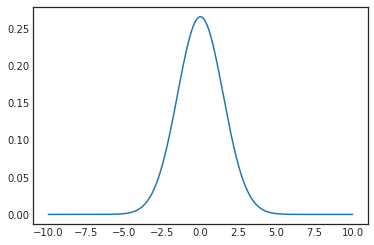

In [8]:
#Return evenly spaced numbers over a specified interval.
x = np.linspace(start=-10, stop=10, num=1000)
#A normal continuous random variable.
#The location (loc) keyword specifies the mean. The scale (scale) keyword specifies the standard deviation.
y = stats.norm.pdf(x, loc=0, scale=1.5) 
#plot it!
plt.plot(x, y)

In [32]:
# get data from the spatialite database
import sqlite3
import matplotlib.pyplot as plt
import geopandas as gpd
from binascii import unhexlify
from codecs import encode
import pysal

db_name = "../Goali/OSM_database/data/USA_osm.db"

conn = sqlite3.connect(db_name)
conn.enable_load_extension(True)
conn.load_extension("mod_spatialite")

query = """
        SELECT ac.HOUR, ac.MONTH, ac.COUNTY, ac.DAY_WEEK, ac.ROAD_FNC, ac.ROUTE
        FROM Fatal_Motor_Vehicle_Accidents as ac
        WHERE ac.HOUR<99
        
        """
accident_data = pd.read_sql(query, conn)
accident_data.head(5)

data = accident_data.HOUR

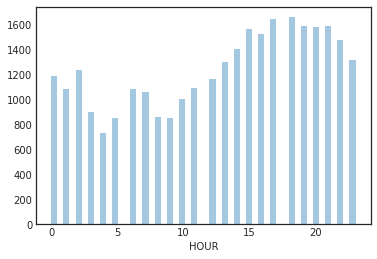

In [20]:
#plot histogram
sns.distplot(accident_data.HOUR, bins=50, kde=False)

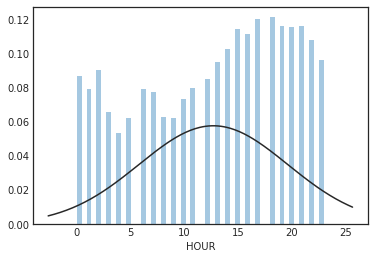

In [21]:
#try to fit a normal distribution to this data
sns.distplot(accident_data.HOUR, fit=stats.norm, bins=50, kde=False,)

In [39]:
class Gaussian:
    "Model univariate Gaussian"
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    #probability density function
    def pdf(self, datum):
        "Probability of a data point given the current parameters"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    #printing model values
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

In [40]:
#gaussian of best fit
best_single = Gaussian(np.mean(accident_data.HOUR), np.std(accident_data.HOUR))
print('Best single Gaussian: μ = {:.2}, σ = {:.2}'.format(best_single.mu, best_single.sigma))

Best single Gaussian: μ = 1.3e+01, σ = 6.9


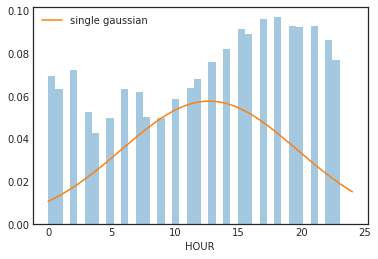

In [41]:
#fit a single gaussian curve to the data
x = np.linspace(0, 24, 200)
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=40, kde=False, norm_hist=True)
plt.plot(x, g_single, label='single gaussian')
plt.legend();

In [42]:
from math import sqrt, log, exp, pi
from random import uniform

In [100]:
class GaussianMixture:
    "Model mixture of two univariate Gaussians and their EM estimation"

    def __init__(self, data, mu_min=min(data), mu_max=max(data), sigma_min=.1, sigma_max=1, mix=.5):
        self.data = data
        #init with multiple gaussians
        self.one = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.two = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        self.three = Gaussian(uniform(mu_min, mu_max), 
                            uniform(sigma_min, sigma_max))
        
        #as well as how much to mix them
        self.mix_1 = 0.33#mix
        self.mix_2 = 0.33
        self.loglike = 0. # = log(p = 1)
    def Estep(self):
        "Perform an E(stimation)-step, freshening up self.loglike in the process"
        # compute weights
        #self.loglike = 0. # = log(p = 1)
        for datum in self.data:
            # unnormalized weights
            wp1 = self.one.pdf(datum) * self.mix_1
            wp2 = self.two.pdf(datum) * self.mix_2#(1. - self.mix)
            wp3 = self.three.pdf(datum) * (1-self.mix_1-self.mix_2)
            # compute denominator
            den = wp1 + wp2 + wp3
            # normalize
            wp1 /= den
            wp2 /= den
            wp3 /= den
            # add into loglike
            self.loglike += log(wp1 + wp2 + wp3)
            # yield weight tuple
            yield (wp1, wp2, wp3)

    def Mstep(self, weights):
        "Perform an M(aximization)-step"
        # compute denominators
        (left, middle, rigt) = zip(*weights)
        one_den = sum(left)
        two_den = sum(middle)
        three_den = sum(rigt)
        # compute new means
        self.one.mu = sum(w * d / one_den for (w, d) in zip(left, data))
        self.two.mu = sum(w * d / two_den for (w, d) in zip(middle, data))
        self.three.mu = sum(w * d / three_den for (w, d) in zip(rigt, data))
        
        # compute new sigmas
        self.one.sigma = sqrt(sum(w * ((d - self.one.mu) ** 2)
                                  for (w, d) in zip(left, data)) / one_den)
        self.two.sigma = sqrt(sum(w * ((d - self.two.mu) ** 2)
                                  for (w, d) in zip(middle, data)) / two_den)
        self.three.sigma = sqrt(sum(w * ((d - self.three.mu) ** 2)
                                  for (w, d) in zip(rigt, data)) / three_den)
        # compute new mix
        self.mix_1 = one_den / len(data)
        self.mix_2 = two_den / len(data)

    def iterate(self, N=1, verbose=False):
        "Perform N iterations, then compute log-likelihood"
        for i in range(1, N+1):
            self.Mstep(self.Estep())
            if verbose:
                print('{0:3} {1}'.format(i, self))
        self.Estep() # to freshen up self.loglike
        
    def pdf(self, x):
        return (self.mix_1)*self.one.pdf(x) + (self.mix_2)*self.two.pdf(x) + (1-self.mix_1-self.mix_2)*self.three.pdf(x)
        
    def __repr__(self):
        return 'GaussianMixture({0}, {1}, {2}, mix_1={3:.03}, mix_2={4:.03})'.format(self.one, 
                                                              self.two,
                                                              self.three,
                                                              self.mix_1,
                                                              self.mix_2)

    def __str__(self):
        return 'Mixture: ({0}, {1}, {2}, mix_1={3:.03}, mix_2={4:.03})'.format(self.one, 
                                                        self.two,
                                                        self.three,
                                                        self.mix_1,
                                                        self.mix_2)

In [105]:
# Find best Mixture Gaussian model
n_iterations = 20
n_random_restarts = 500
best_mix = None
best_loglike = float('-inf')
print('Computing best model with random restarts...\n')
for _ in range(n_random_restarts):
    mix = GaussianMixture(data)
    for _ in range(n_iterations):
        try:
            mix.iterate(verbose=True)
            if mix.loglike > best_loglike:
                best_loglike = mix.loglike
                best_mix = mix
        except (ZeroDivisionError, ValueError, RuntimeWarning): # Catch division errors from bad starts, and just throw them out...
            pass
print('\n\nDone. 🙂')
print(best_mix)

Computing best model with random restarts...

  1 Mixture: (Gaussian(20.3878, 1.68499), Gaussian(15.1031, 1.40684), Gaussian(5.94129, 3.89121), mix_1=0.309, mix_2=0.251)
  1 Mixture: (Gaussian(20.317, 1.79894), Gaussian(15.0984, 1.66104), Gaussian(6.14706, 4.12164), mix_1=0.31, mix_2=0.242)
  1 Mixture: (Gaussian(20.2997, 1.84361), Gaussian(15.0766, 1.81412), Gaussian(6.2051, 4.21652), mix_1=0.308, mix_2=0.244)
  1 Mixture: (Gaussian(20.2974, 1.86387), Gaussian(15.056, 1.92073), Gaussian(6.20738, 4.25352), mix_1=0.305, mix_2=0.248)
  1 Mixture: (Gaussian(20.3018, 1.87295), Gaussian(15.0387, 2.00097), Gaussian(6.18173, 4.26022), mix_1=0.303, mix_2=0.253)
  1 Mixture: (Gaussian(20.31, 1.87602), Gaussian(15.0244, 2.06494), Gaussian(6.14043, 4.24939), mix_1=0.301, mix_2=0.259)
  1 Mixture: (Gaussian(20.3205, 1.8755), Gaussian(15.012, 2.11847), Gaussian(6.0899, 4.22786), mix_1=0.299, mix_2=0.265)
  1 Mixture: (Gaussian(20.3326, 1.87269), Gaussian(15.0008, 2.16517), Gaussian(6.0338, 4.19963)

  1 Mixture: (Gaussian(1.42371, 1.18288), Gaussian(7.08289, 2.63652), Gaussian(17.1365, 3.7746), mix_1=0.136, mix_2=0.227)
  1 Mixture: (Gaussian(1.40406, 1.16924), Gaussian(7.08063, 2.68571), Gaussian(17.1574, 3.76222), mix_1=0.134, mix_2=0.232)
  1 Mixture: (Gaussian(1.38602, 1.15661), Gaussian(7.08151, 2.732), Gaussian(17.1791, 3.74913), mix_1=0.132, mix_2=0.236)
  1 Mixture: (Gaussian(1.36963, 1.14508), Gaussian(7.08534, 2.77576), Gaussian(17.2011, 3.73566), mix_1=0.13, mix_2=0.24)
  1 Mixture: (Gaussian(1.35485, 1.13464), Gaussian(7.09194, 2.81719), Gaussian(17.2233, 3.72198), mix_1=0.129, mix_2=0.244)
  1 Mixture: (Gaussian(1.34162, 1.12528), Gaussian(7.10113, 2.85645), Gaussian(17.2455, 3.70824), mix_1=0.127, mix_2=0.248)
  1 Mixture: (Gaussian(1.32984, 1.11691), Gaussian(7.1127, 2.89364), Gaussian(17.2677, 3.6945), mix_1=0.126, mix_2=0.252)
  1 Mixture: (Gaussian(1.31941, 1.10949), Gaussian(7.12646, 2.92888), Gaussian(17.2898, 3.68083), mix_1=0.125, mix_2=0.255)
  1 Mixture: (G

  1 Mixture: (Gaussian(17.7816, 3.37467), Gaussian(9.74736, 2.43149), Gaussian(3.03963, 2.34696), mix_1=0.57, mix_2=0.188)
  1 Mixture: (Gaussian(17.8101, 3.35737), Gaussian(9.74467, 2.47169), Gaussian(2.99951, 2.32319), mix_1=0.567, mix_2=0.194)
  1 Mixture: (Gaussian(17.8383, 3.34032), Gaussian(9.74139, 2.5118), Gaussian(2.95902, 2.29905), mix_1=0.564, mix_2=0.199)
  1 Mixture: (Gaussian(17.866, 3.32359), Gaussian(9.73748, 2.55193), Gaussian(2.91817, 2.27453), mix_1=0.561, mix_2=0.205)
  1 Mixture: (Gaussian(17.8933, 3.3072), Gaussian(9.73288, 2.59218), Gaussian(2.87695, 2.24962), mix_1=0.558, mix_2=0.211)
  1 Mixture: (Gaussian(17.9202, 3.29119), Gaussian(9.72753, 2.63262), Gaussian(2.83532, 2.22429), mix_1=0.555, mix_2=0.217)
  1 Mixture: (Gaussian(5.26135, 3.60907), Gaussian(17.6349, 3.30847), Gaussian(7.64731, 0.477806), mix_1=0.385, mix_2=0.599)
  1 Mixture: (Gaussian(5.35976, 3.80976), Gaussian(17.4841, 3.51332), Gaussian(7.63642, 0.529836), mix_1=0.385, mix_2=0.604)
  1 Mixtur

  1 Mixture: (Gaussian(12.0223, 1.92928), Gaussian(5.93621, 1.42213), Gaussian(13.6013, 7.38712), mix_1=0.133, mix_2=0.0892)
  1 Mixture: (Gaussian(12.3523, 2.11601), Gaussian(5.66833, 1.59462), Gaussian(13.33, 7.20155), mix_1=0.0916, mix_2=0.0696)
  1 Mixture: (Gaussian(12.719, 2.2761), Gaussian(5.28609, 1.80264), Gaussian(13.2126, 7.08575), mix_1=0.0675, mix_2=0.0596)
  1 Mixture: (Gaussian(13.135, 2.42495), Gaussian(4.70748, 2.04896), Gaussian(13.1927, 6.98593), mix_1=0.0525, mix_2=0.0569)
  1 Mixture: (Gaussian(13.609, 2.56899), Gaussian(3.90933, 2.23854), Gaussian(13.2774, 6.86107), mix_1=0.0428, mix_2=0.0624)
  1 Mixture: (Gaussian(14.1434, 2.71227), Gaussian(3.11033, 2.22077), Gaussian(13.4826, 6.67717), mix_1=0.0366, mix_2=0.0771)
  1 Mixture: (Gaussian(14.734, 2.85795), Gaussian(2.5566, 2.04052), Gaussian(13.7842, 6.42782), mix_1=0.0329, mix_2=0.0987)
  1 Mixture: (Gaussian(15.3733, 3.0037), Gaussian(2.24196, 1.8521), Gaussian(14.1152, 6.13894), mix_1=0.0309, mix_2=0.122)
  1 

  1 Mixture: (Gaussian(21.3579, 0.98797), Gaussian(9.53861, 5.97306), Gaussian(19.3797, 2.38448), mix_1=0.0288, mix_2=0.684)
  1 Mixture: (Gaussian(21.5596, 0.991131), Gaussian(9.44039, 5.93504), Gaussian(19.28, 2.40203), mix_1=0.0323, mix_2=0.675)
  1 Mixture: (Gaussian(21.7353, 0.96158), Gaussian(9.33922, 5.89436), Gaussian(19.1674, 2.41498), mix_1=0.0371, mix_2=0.667)
  1 Mixture: (Gaussian(21.8762, 0.914617), Gaussian(9.23533, 5.8515), Gaussian(19.0414, 2.42249), mix_1=0.0433, mix_2=0.658)
  1 Mixture: (Gaussian(21.9841, 0.866098), Gaussian(9.12908, 5.80691), Gaussian(18.9044, 2.42354), mix_1=0.0502, mix_2=0.65)
  1 Mixture: (Gaussian(22.0639, 0.825183), Gaussian(9.02143, 5.76133), Gaussian(18.7622, 2.41837), mix_1=0.0575, mix_2=0.641)
  1 Mixture: (Gaussian(22.1198, 0.794936), Gaussian(8.91402, 5.71575), Gaussian(18.6239, 2.40943), mix_1=0.0643, mix_2=0.633)
  1 Mixture: (Gaussian(22.156, 0.774969), Gaussian(8.80867, 5.67102), Gaussian(18.4979, 2.40066), mix_1=0.0701, mix_2=0.624)

  1 Mixture: (Gaussian(7.04658, 0.721779), Gaussian(17.3217, 3.66416), Gaussian(5.30104, 3.79295), mix_1=0.00305, mix_2=0.616)
  1 Mixture: (Gaussian(7.03814, 0.711372), Gaussian(17.3099, 3.67152), Gaussian(5.2831, 3.77963), mix_1=0.00272, mix_2=0.617)
  1 Mixture: (Gaussian(7.03028, 0.70014), Gaussian(17.2987, 3.67863), Gaussian(5.26573, 3.767), mix_1=0.00243, mix_2=0.618)
  1 Mixture: (Gaussian(7.02293, 0.688177), Gaussian(17.2878, 3.68549), Gaussian(5.24891, 3.75495), mix_1=0.00218, mix_2=0.619)
  1 Mixture: (Gaussian(7.01605, 0.675535), Gaussian(17.2773, 3.69213), Gaussian(5.23259, 3.74344), mix_1=0.00197, mix_2=0.62)
  1 Mixture: (Gaussian(7.00961, 0.662229), Gaussian(17.2671, 3.69856), Gaussian(5.21676, 3.73242), mix_1=0.00178, mix_2=0.621)
  1 Mixture: (Gaussian(20.344, 1.71722), Gaussian(2.28669, 1.71834), Gaussian(12.1398, 3.46935), mix_1=0.314, mix_2=0.203)
  1 Mixture: (Gaussian(20.2514, 1.89043), Gaussian(2.34101, 1.85241), Gaussian(12.2642, 3.84472), mix_1=0.303, mix_2=0.1

  1 Mixture: (Gaussian(2.29613, 1.81966), Gaussian(20.2956, 1.86352), Gaussian(12.2785, 3.88606), mix_1=0.196, mix_2=0.298)
  1 Mixture: (Gaussian(2.32756, 1.86858), Gaussian(20.2223, 1.94195), Gaussian(12.3527, 4.09549), mix_1=0.194, mix_2=0.292)
  1 Mixture: (Gaussian(2.33978, 1.88881), Gaussian(20.1723, 1.98638), Gaussian(12.3972, 4.22819), mix_1=0.192, mix_2=0.288)
  1 Mixture: (Gaussian(2.34004, 1.89505), Gaussian(20.1381, 2.01415), Gaussian(12.423, 4.31923), mix_1=0.19, mix_2=0.285)
  1 Mixture: (Gaussian(2.33271, 1.89325), Gaussian(20.1144, 2.03234), Gaussian(12.4361, 4.38508), mix_1=0.189, mix_2=0.283)
  1 Mixture: (Gaussian(2.32036, 1.88638), Gaussian(20.0978, 2.04458), Gaussian(12.4404, 4.43476), mix_1=0.187, mix_2=0.282)
  1 Mixture: (Gaussian(2.30458, 1.87613), Gaussian(20.0859, 2.05298), Gaussian(12.4382, 4.47365), mix_1=0.185, mix_2=0.28)
  1 Mixture: (Gaussian(2.28634, 1.8635), Gaussian(20.0773, 2.05886), Gaussian(12.4311, 4.50519), mix_1=0.184, mix_2=0.28)
  1 Mixture: 

  1 Mixture: (Gaussian(14.7886, 1.58361), Gaussian(6.97558, 4.7487), Gaussian(19.8219, 2.15056), mix_1=0.154, mix_2=0.494)
  1 Mixture: (Gaussian(14.7756, 1.62983), Gaussian(6.91783, 4.72206), Gaussian(19.8359, 2.14427), mix_1=0.16, mix_2=0.489)
  1 Mixture: (Gaussian(14.7647, 1.67219), Gaussian(6.85587, 4.69118), Gaussian(19.8504, 2.13736), mix_1=0.165, mix_2=0.485)
  1 Mixture: (Gaussian(14.7555, 1.71158), Gaussian(6.7909, 4.65709), Gaussian(19.8654, 2.12999), mix_1=0.171, mix_2=0.481)
  1 Mixture: (Gaussian(14.7473, 1.74868), Gaussian(6.72381, 4.62058), Gaussian(19.8807, 2.12229), mix_1=0.178, mix_2=0.476)
  1 Mixture: (Gaussian(14.7398, 1.78401), Gaussian(6.65527, 4.58226), Gaussian(19.8963, 2.11434), mix_1=0.184, mix_2=0.471)
  1 Mixture: (Gaussian(14.7327, 1.81803), Gaussian(6.5858, 4.54259), Gaussian(19.9121, 2.10619), mix_1=0.19, mix_2=0.467)
  1 Mixture: (Gaussian(14.7257, 1.85107), Gaussian(6.51579, 4.50194), Gaussian(19.9282, 2.09789), mix_1=0.196, mix_2=0.462)
  1 Mixture: 

  1 Mixture: (Gaussian(8.32136, 1.5087), Gaussian(19.0369, 2.67352), Gaussian(8.53683, 5.56068), mix_1=7.05e-05, mix_2=0.397)
  1 Mixture: (Gaussian(8.29916, 1.61713), Gaussian(19.0126, 2.68825), Gaussian(8.48963, 5.53932), mix_1=5.4e-05, mix_2=0.401)
  1 Mixture: (Gaussian(8.28738, 1.73506), Gaussian(18.9888, 2.70259), Gaussian(8.44314, 5.51806), mix_1=4.2e-05, mix_2=0.404)
  1 Mixture: (Gaussian(8.28978, 1.86642), Gaussian(18.9654, 2.71658), Gaussian(8.39732, 5.4969), mix_1=3.3e-05, mix_2=0.408)
  1 Mixture: (Gaussian(8.31011, 2.01693), Gaussian(18.9426, 2.73024), Gaussian(8.35216, 5.47584), mix_1=2.63e-05, mix_2=0.411)
  1 Mixture: (Gaussian(12.6479, 7.22973), Gaussian(13.2464, 0.457626), Gaussian(13.3696, 1.14933), mix_1=0.914, mix_2=0.0269)
  1 Mixture: (Gaussian(12.6649, 7.10107), Gaussian(13.2512, 0.492264), Gaussian(13.5422, 1.27358), mix_1=0.947, mix_2=0.0141)
  1 Mixture: (Gaussian(12.6723, 7.04244), Gaussian(13.2583, 0.51387), Gaussian(13.7363, 1.35198), mix_1=0.964, mix_2=0

  1 Mixture: (Gaussian(18.4848, 0.570572), Gaussian(6.77227, 4.54071), Gaussian(18.2441, 3.25286), mix_1=0.0571, mix_2=0.484)
  1 Mixture: (Gaussian(18.4861, 0.620919), Gaussian(6.80144, 4.63162), Gaussian(18.1655, 3.2746), mix_1=0.0378, mix_2=0.481)
  1 Mixture: (Gaussian(18.492, 0.662374), Gaussian(6.78576, 4.65039), Gaussian(18.1271, 3.2754), mix_1=0.0275, mix_2=0.479)
  1 Mixture: (Gaussian(18.5017, 0.699062), Gaussian(6.75461, 4.64197), Gaussian(18.1035, 3.2716), mix_1=0.021, mix_2=0.476)
  1 Mixture: (Gaussian(18.515, 0.733093), Gaussian(6.71813, 4.62326), Gaussian(18.0854, 3.26823), mix_1=0.0165, mix_2=0.474)
  1 Mixture: (Gaussian(18.5321, 0.765803), Gaussian(6.68025, 4.60107), Gaussian(18.0689, 3.26681), mix_1=0.0133, mix_2=0.471)
  1 Mixture: (Gaussian(18.5535, 0.798177), Gaussian(6.64246, 4.57808), Gaussian(18.0527, 3.26754), mix_1=0.0108, mix_2=0.469)
  1 Mixture: (Gaussian(18.5797, 0.831033), Gaussian(6.60527, 4.55533), Gaussian(18.0364, 3.27017), mix_1=0.00891, mix_2=0.46

  1 Mixture: (Gaussian(2.09838, 1.72397), Gaussian(10.2105, 3.67049), Gaussian(18.7375, 2.83269), mix_1=0.176, mix_2=0.365)
  1 Mixture: (Gaussian(2.05228, 1.68914), Gaussian(10.1857, 3.72509), Gaussian(18.7464, 2.8305), mix_1=0.172, mix_2=0.37)
  1 Mixture: (Gaussian(2.00487, 1.65233), Gaussian(10.1602, 3.77596), Gaussian(18.7561, 2.82724), mix_1=0.168, mix_2=0.375)
  1 Mixture: (Gaussian(1.95685, 1.61421), Gaussian(10.1342, 3.82401), Gaussian(18.766, 2.82337), mix_1=0.165, mix_2=0.381)
  1 Mixture: (Gaussian(1.90883, 1.57541), Gaussian(10.108, 3.86976), Gaussian(18.7759, 2.81917), mix_1=0.161, mix_2=0.386)
  1 Mixture: (Gaussian(1.86144, 1.53655), Gaussian(10.082, 3.91351), Gaussian(18.7856, 2.81483), mix_1=0.158, mix_2=0.391)
  1 Mixture: (Gaussian(1.81524, 1.49824), Gaussian(10.0564, 3.95542), Gaussian(18.7951, 2.81049), mix_1=0.155, mix_2=0.396)
  1 Mixture: (Gaussian(1.77082, 1.46109), Gaussian(10.0317, 3.99552), Gaussian(18.8042, 2.80622), mix_1=0.151, mix_2=0.401)
  1 Mixture: 

  1 Mixture: (Gaussian(1.83865, 1.46029), Gaussian(16.1989, 4.42669), Gaussian(6.4643, 1.29468), mix_1=0.171, mix_2=0.723)
  1 Mixture: (Gaussian(1.80605, 1.43594), Gaussian(16.2269, 4.40584), Gaussian(6.45752, 1.3421), mix_1=0.169, mix_2=0.72)
  1 Mixture: (Gaussian(1.77484, 1.41294), Gaussian(16.2542, 4.38556), Gaussian(6.45152, 1.38964), mix_1=0.167, mix_2=0.718)
  1 Mixture: (Gaussian(1.7449, 1.39117), Gaussian(16.2811, 4.36571), Gaussian(6.44639, 1.43728), mix_1=0.165, mix_2=0.716)
  1 Mixture: (Gaussian(1.71614, 1.37054), Gaussian(16.3078, 4.34619), Gaussian(6.44219, 1.48503), mix_1=0.163, mix_2=0.713)
  1 Mixture: (Gaussian(1.6885, 1.35096), Gaussian(16.3342, 4.32693), Gaussian(6.43894, 1.53288), mix_1=0.161, mix_2=0.711)
  1 Mixture: (Gaussian(20.3878, 1.685), Gaussian(3.79831, 2.63501), Gaussian(13.5007, 2.5219), mix_1=0.309, mix_2=0.301)
  1 Mixture: (Gaussian(20.3155, 1.83704), Gaussian(3.92267, 2.80676), Gaussian(13.6223, 2.80517), mix_1=0.304, mix_2=0.304)
  1 Mixture: (Ga

  1 Mixture: (Gaussian(16.6835, 0.955249), Gaussian(20.3339, 1.86576), Gaussian(8.87357, 5.52169), mix_1=0.071, mix_2=0.286)
  1 Mixture: (Gaussian(16.5818, 1.0097), Gaussian(20.3439, 1.86794), Gaussian(8.93952, 5.61182), mix_1=0.0776, mix_2=0.278)
  1 Mixture: (Gaussian(16.4914, 1.06569), Gaussian(20.3645, 1.85345), Gaussian(8.95489, 5.65153), mix_1=0.0832, mix_2=0.274)
  1 Mixture: (Gaussian(16.4114, 1.11999), Gaussian(20.3877, 1.83522), Gaussian(8.9403, 5.66707), mix_1=0.0888, mix_2=0.271)
  1 Mixture: (Gaussian(16.3418, 1.17226), Gaussian(20.4103, 1.81766), Gaussian(8.90583, 5.66864), mix_1=0.0947, mix_2=0.269)
  1 Mixture: (Gaussian(16.2821, 1.22281), Gaussian(20.4313, 1.80209), Gaussian(8.85736, 5.66091), mix_1=0.101, mix_2=0.268)
  1 Mixture: (Gaussian(16.2313, 1.27187), Gaussian(20.4505, 1.78865), Gaussian(8.79878, 5.64639), mix_1=0.107, mix_2=0.267)
  1 Mixture: (Gaussian(16.1883, 1.31959), Gaussian(20.4681, 1.77706), Gaussian(8.73282, 5.62661), mix_1=0.114, mix_2=0.266)
  1 M

  1 Mixture: (Gaussian(16.0, 2.38032e-13), Gaussian(17.6565, 3.68262), Gaussian(5.62944, 3.96102), mix_1=0.0514, mix_2=0.544)
  1 Mixture: (Gaussian(16.0, 6.21725e-13), Gaussian(17.6656, 3.67706), Gaussian(5.64243, 3.96847), mix_1=0.0514, mix_2=0.543)
  1 Mixture: (Gaussian(16.0, 2.41585e-13), Gaussian(17.6748, 3.67144), Gaussian(5.65546, 3.97592), mix_1=0.0514, mix_2=0.542)
  1 Mixture: (Gaussian(16.0, 6.21725e-13), Gaussian(17.6841, 3.66578), Gaussian(5.66855, 3.98337), mix_1=0.0514, mix_2=0.542)
  1 Mixture: (Gaussian(16.0, 2.4869e-13), Gaussian(17.6934, 3.6601), Gaussian(5.6817, 3.99086), mix_1=0.0514, mix_2=0.541)
  1 Mixture: (Gaussian(16.0, 7.17648e-13), Gaussian(17.7027, 3.65438), Gaussian(5.69492, 3.99837), mix_1=0.0514, mix_2=0.54)
  1 Mixture: (Gaussian(16.0, 7.17648e-13), Gaussian(17.7121, 3.64863), Gaussian(5.70821, 4.00592), mix_1=0.0514, mix_2=0.539)
  1 Mixture: (Gaussian(16.0, 7.17648e-13), Gaussian(17.7216, 3.64285), Gaussian(5.72158, 4.01349), mix_1=0.0514, mix_2=0.5

  1 Mixture: (Gaussian(15.9544, 4.71375), Gaussian(6.55887, 2.25472), Gaussian(1.80769, 1.4992), mix_1=0.735, mix_2=0.106)
  1 Mixture: (Gaussian(16.0935, 4.59066), Gaussian(6.50337, 2.09431), Gaussian(1.74624, 1.4472), mix_1=0.725, mix_2=0.118)
  1 Mixture: (Gaussian(16.2173, 4.47791), Gaussian(6.47646, 1.98634), Gaussian(1.68632, 1.39232), mix_1=0.716, mix_2=0.128)
  1 Mixture: (Gaussian(16.3194, 4.38349), Gaussian(6.46365, 1.92532), Gaussian(1.63414, 1.34286), mix_1=0.709, mix_2=0.137)
  1 Mixture: (Gaussian(16.3989, 4.31008), Gaussian(6.45765, 1.90228), Gaussian(1.59141, 1.30295), mix_1=0.703, mix_2=0.145)
  1 Mixture: (Gaussian(20.3878, 1.68499), Gaussian(3.82074, 2.64821), Gaussian(13.5203, 2.50664), mix_1=0.309, mix_2=0.303)
  1 Mixture: (Gaussian(20.3155, 1.8366), Gaussian(3.94544, 2.82025), Gaussian(13.6398, 2.78981), mix_1=0.304, mix_2=0.305)
  1 Mixture: (Gaussian(20.2793, 1.8967), Gaussian(3.9861, 2.88239), Gaussian(13.7076, 2.93675), mix_1=0.3, mix_2=0.306)
  1 Mixture: (G

  1 Mixture: (Gaussian(5.76134, 3.86775), Gaussian(19.0676, 2.78174), Gaussian(14.3719, 1.35062), mix_1=0.424, mix_2=0.423)
  1 Mixture: (Gaussian(5.9061, 4.00209), Gaussian(19.1166, 2.65654), Gaussian(14.1834, 1.4945), mix_1=0.431, mix_2=0.424)
  1 Mixture: (Gaussian(5.95607, 4.07182), Gaussian(19.1687, 2.58263), Gaussian(14.0364, 1.58461), mix_1=0.432, mix_2=0.421)
  1 Mixture: (Gaussian(5.95727, 4.10276), Gaussian(19.2118, 2.53594), Gaussian(13.9343, 1.64789), mix_1=0.43, mix_2=0.418)
  1 Mixture: (Gaussian(5.9312, 4.10816), Gaussian(19.2463, 2.5044), Gaussian(13.867, 1.69809), mix_1=0.428, mix_2=0.415)
  1 Mixture: (Gaussian(5.88941, 4.09677), Gaussian(19.2749, 2.48163), Gaussian(13.8233, 1.74149), mix_1=0.424, mix_2=0.413)
  1 Mixture: (Gaussian(5.83843, 4.0745), Gaussian(19.2998, 2.464), Gaussian(13.7948, 1.78097), mix_1=0.421, mix_2=0.41)
  1 Mixture: (Gaussian(5.78214, 4.04535), Gaussian(19.3225, 2.44933), Gaussian(13.7756, 1.81796), mix_1=0.417, mix_2=0.408)
  1 Mixture: (Gaus

  1 Mixture: (Gaussian(14.8286, 5.35988), Gaussian(2.44037, 1.97691), Gaussian(19.0179, 1.13604), mix_1=0.764, mix_2=0.188)
  1 Mixture: (Gaussian(14.8497, 5.31234), Gaussian(2.45099, 1.97937), Gaussian(19.1927, 1.22805), mix_1=0.76, mix_2=0.19)
  1 Mixture: (Gaussian(14.8432, 5.27659), Gaussian(2.46958, 1.99029), Gaussian(19.4064, 1.32558), mix_1=0.754, mix_2=0.193)
  1 Mixture: (Gaussian(14.8097, 5.24225), Gaussian(2.49116, 2.0047), Gaussian(19.6605, 1.42361), mix_1=0.746, mix_2=0.194)
  1 Mixture: (Gaussian(14.7444, 5.20192), Gaussian(2.5131, 2.02002), Gaussian(19.9443, 1.50883), mix_1=0.735, mix_2=0.196)
  1 Mixture: (Gaussian(14.6431, 5.15013), Gaussian(2.53366, 2.03472), Gaussian(20.228, 1.56291), mix_1=0.721, mix_2=0.197)
  1 Mixture: (Gaussian(14.5096, 5.08502), Gaussian(2.55163, 2.04779), Gaussian(20.4733, 1.57747), mix_1=0.705, mix_2=0.199)
  1 Mixture: (Gaussian(14.358, 5.00935), Gaussian(2.56633, 2.05864), Gaussian(20.6582, 1.56304), mix_1=0.689, mix_2=0.2)
  1 Mixture: (Ga

  1 Mixture: (Gaussian(21.9772, 0.864906), Gaussian(4.75238, 3.41959), Gaussian(16.1153, 3.50327), mix_1=0.0972, mix_2=0.35)
  1 Mixture: (Gaussian(21.9484, 0.882834), Gaussian(4.73476, 3.40847), Gaussian(16.0825, 3.5034), mix_1=0.0997, mix_2=0.349)
  1 Mixture: (Gaussian(21.9208, 0.900261), Gaussian(4.71699, 3.39724), Gaussian(16.0503, 3.50403), mix_1=0.102, mix_2=0.348)
  1 Mixture: (Gaussian(21.8941, 0.917198), Gaussian(4.6991, 3.38594), Gaussian(16.0188, 3.5051), mix_1=0.104, mix_2=0.347)
  1 Mixture: (Gaussian(21.8682, 0.933643), Gaussian(4.68112, 3.37459), Gaussian(15.9878, 3.50656), mix_1=0.107, mix_2=0.346)
  1 Mixture: (Gaussian(17.8966, 3.75148), Gaussian(4.90425, 3.32579), Gaussian(15.0942, 0.772678), mix_1=0.497, mix_2=0.371)
  1 Mixture: (Gaussian(17.6674, 3.74985), Gaussian(5.15496, 3.59873), Gaussian(15.0237, 0.911721), mix_1=0.539, mix_2=0.379)
  1 Mixture: (Gaussian(17.6075, 3.71319), Gaussian(5.26406, 3.69992), Gaussian(14.9429, 1.01136), mix_1=0.555, mix_2=0.384)
  1

  1 Mixture: (Gaussian(15.4175, 4.32826), Gaussian(3.94903, 2.90933), Gaussian(19.7566, 1.4323), mix_1=0.539, mix_2=0.298)
  1 Mixture: (Gaussian(15.2925, 4.30305), Gaussian(3.91309, 2.92524), Gaussian(20.095, 1.6482), mix_1=0.554, mix_2=0.292)
  1 Mixture: (Gaussian(15.1299, 4.22062), Gaussian(3.86716, 2.903), Gaussian(20.3826, 1.73306), mix_1=0.553, mix_2=0.289)
  1 Mixture: (Gaussian(14.9838, 4.13713), Gaussian(3.82237, 2.87153), Gaussian(20.5707, 1.72389), mix_1=0.549, mix_2=0.286)
  1 Mixture: (Gaussian(14.8629, 4.06638), Gaussian(3.78325, 2.84119), Gaussian(20.6901, 1.68248), mix_1=0.544, mix_2=0.285)
  1 Mixture: (Gaussian(14.7654, 4.00866), Gaussian(3.75046, 2.81502), Gaussian(20.7704, 1.63999), mix_1=0.54, mix_2=0.283)
  1 Mixture: (Gaussian(14.6896, 3.96303), Gaussian(3.72352, 2.79336), Gaussian(20.8264, 1.60547), mix_1=0.538, mix_2=0.282)
  1 Mixture: (Gaussian(14.6327, 3.92841), Gaussian(3.70176, 2.77582), Gaussian(20.8658, 1.57965), mix_1=0.535, mix_2=0.281)
  1 Mixture: (

  1 Mixture: (Gaussian(3.99669, 2.90702), Gaussian(10.7523, 1.83762), Gaussian(17.6871, 3.44095), mix_1=0.306, mix_2=0.114)
  1 Mixture: (Gaussian(3.9747, 2.89626), Gaussian(10.7443, 1.87179), Gaussian(17.7227, 3.41543), mix_1=0.304, mix_2=0.119)
  1 Mixture: (Gaussian(3.94969, 2.88276), Gaussian(10.7421, 1.90667), Gaussian(17.7564, 3.39246), mix_1=0.303, mix_2=0.124)
  1 Mixture: (Gaussian(3.92267, 2.8675), Gaussian(10.7433, 1.94225), Gaussian(17.789, 3.37114), mix_1=0.301, mix_2=0.129)
  1 Mixture: (Gaussian(3.89428, 2.85111), Gaussian(10.7466, 1.9784), Gaussian(17.8207, 3.35086), mix_1=0.299, mix_2=0.134)
  1 Mixture: (Gaussian(3.86488, 2.83397), Gaussian(10.751, 2.01499), Gaussian(17.8521, 3.33125), mix_1=0.297, mix_2=0.14)
  1 Mixture: (Gaussian(3.83472, 2.81633), Gaussian(10.7561, 2.0519), Gaussian(17.8832, 3.31207), mix_1=0.295, mix_2=0.145)
  1 Mixture: (Gaussian(3.80396, 2.79833), Gaussian(10.7614, 2.08901), Gaussian(17.9142, 3.2932), mix_1=0.293, mix_2=0.15)
  1 Mixture: (Gau

  1 Mixture: (Gaussian(18.8821, 2.71297), Gaussian(6.4718, 4.46117), Gaussian(13.5759, 1.32311), mix_1=0.453, mix_2=0.46)
  1 Mixture: (Gaussian(18.8961, 2.70375), Gaussian(6.4165, 4.4297), Gaussian(13.5668, 1.36175), mix_1=0.452, mix_2=0.457)
  1 Mixture: (Gaussian(18.9109, 2.69409), Gaussian(6.35992, 4.39728), Gaussian(13.5578, 1.39949), mix_1=0.45, mix_2=0.453)
  1 Mixture: (Gaussian(18.9263, 2.68408), Gaussian(6.30214, 4.36397), Gaussian(13.549, 1.4364), mix_1=0.449, mix_2=0.449)
  1 Mixture: (Gaussian(18.9424, 2.67376), Gaussian(6.24328, 4.32977), Gaussian(13.5405, 1.47255), mix_1=0.448, mix_2=0.446)
  1 Mixture: (Gaussian(17.3305, 3.79947), Gaussian(2.69599, 1.99488), Gaussian(9.41431, 1.66898), mix_1=0.61, mix_2=0.229)
  1 Mixture: (Gaussian(17.3543, 3.66385), Gaussian(2.82442, 2.13348), Gaussian(9.14547, 1.92923), mix_1=0.614, mix_2=0.234)
  1 Mixture: (Gaussian(17.3813, 3.62046), Gaussian(2.83103, 2.17471), Gaussian(9.03115, 2.05782), mix_1=0.612, mix_2=0.232)
  1 Mixture: (Ga

  1 Mixture: (Gaussian(3.50684, 2.56621), Gaussian(17.8475, 3.2769), Gaussian(10.2399, 1.85328), mix_1=0.277, mix_2=0.569)
  1 Mixture: (Gaussian(3.50382, 2.58538), Gaussian(17.8401, 3.30207), Gaussian(10.2629, 1.97993), mix_1=0.275, mix_2=0.568)
  1 Mixture: (Gaussian(3.48788, 2.58887), Gaussian(17.8476, 3.31015), Gaussian(10.2794, 2.07688), mix_1=0.273, mix_2=0.566)
  1 Mixture: (Gaussian(3.46479, 2.58356), Gaussian(17.8635, 3.30869), Gaussian(10.2917, 2.15456), mix_1=0.271, mix_2=0.564)
  1 Mixture: (Gaussian(3.43738, 2.57293), Gaussian(17.8844, 3.30149), Gaussian(10.301, 2.21939), mix_1=0.269, mix_2=0.561)
  1 Mixture: (Gaussian(3.40721, 2.55891), Gaussian(17.9084, 3.2907), Gaussian(10.3083, 2.27555), mix_1=0.267, mix_2=0.558)
  1 Mixture: (Gaussian(3.37522, 2.54267), Gaussian(17.9343, 3.27762), Gaussian(10.314, 2.32581), mix_1=0.264, mix_2=0.555)
  1 Mixture: (Gaussian(3.34199, 2.52494), Gaussian(17.9613, 3.26311), Gaussian(10.3187, 2.37207), mix_1=0.262, mix_2=0.552)
  1 Mixture:

  1 Mixture: (Gaussian(17.7209, 3.43377), Gaussian(7.21835, 3.79212), Gaussian(1.10717, 0.949643), mix_1=0.572, mix_2=0.343)
  1 Mixture: (Gaussian(17.7404, 3.41957), Gaussian(7.35024, 3.72625), Gaussian(1.09843, 0.950764), mix_1=0.57, mix_2=0.339)
  1 Mixture: (Gaussian(17.759, 3.40586), Gaussian(7.44822, 3.68107), Gaussian(1.10568, 0.957487), mix_1=0.569, mix_2=0.336)
  1 Mixture: (Gaussian(17.7762, 3.39342), Gaussian(7.52472, 3.65152), Gaussian(1.11991, 0.967437), mix_1=0.567, mix_2=0.334)
  1 Mixture: (Gaussian(17.7922, 3.38231), Gaussian(7.58824, 3.63272), Gaussian(1.13658, 0.978635), mix_1=0.566, mix_2=0.333)
  1 Mixture: (Gaussian(17.8072, 3.37228), Gaussian(7.64365, 3.6211), Gaussian(1.15345, 0.98988), mix_1=0.564, mix_2=0.332)
  1 Mixture: (Gaussian(17.8215, 3.36301), Gaussian(7.69357, 3.6143), Gaussian(1.16944, 1.00054), mix_1=0.563, mix_2=0.332)
  1 Mixture: (Gaussian(17.8355, 3.35424), Gaussian(7.73944, 3.61084), Gaussian(1.18412, 1.01035), mix_1=0.561, mix_2=0.332)
  1 Mix

  1 Mixture: (Gaussian(5.21876, 2.74663), Gaussian(16.6141, 4.13883), Gaussian(0.679001, 0.712547), mix_1=0.246, mix_2=0.685)
  1 Mixture: (Gaussian(5.29786, 2.7661), Gaussian(16.6456, 4.11673), Gaussian(0.718553, 0.737145), mix_1=0.247, mix_2=0.682)
  1 Mixture: (Gaussian(5.38281, 2.78344), Gaussian(16.677, 4.09494), Gaussian(0.759987, 0.761439), mix_1=0.247, mix_2=0.679)
  1 Mixture: (Gaussian(5.47223, 2.79871), Gaussian(16.7083, 4.07332), Gaussian(0.800936, 0.7845), mix_1=0.247, mix_2=0.676)
  1 Mixture: (Gaussian(5.56405, 2.81219), Gaussian(16.7397, 4.05178), Gaussian(0.839578, 0.805916), mix_1=0.247, mix_2=0.673)
  1 Mixture: (Gaussian(7.32046, 5.3289), Gaussian(10.0607, 1.26113), Gaussian(19.3849, 2.25089), mix_1=0.454, mix_2=0.129)
  1 Mixture: (Gaussian(7.64619, 5.40279), Gaussian(10.3735, 1.51218), Gaussian(19.1111, 2.5411), mix_1=0.497, mix_2=0.0814)
  1 Mixture: (Gaussian(7.66229, 5.3847), Gaussian(10.716, 1.68446), Gaussian(18.9518, 2.66668), mix_1=0.507, mix_2=0.0627)
  1 

  1 Mixture: (Gaussian(11.6368, 1.35331), Gaussian(18.3244, 2.94117), Gaussian(4.38598, 3.06385), mix_1=0.14, mix_2=0.524)
  1 Mixture: (Gaussian(11.6616, 1.50649), Gaussian(18.2797, 3.00382), Gaussian(4.41977, 3.12094), mix_1=0.138, mix_2=0.526)
  1 Mixture: (Gaussian(11.6822, 1.6196), Gaussian(18.2659, 3.03252), Gaussian(4.423, 3.14232), mix_1=0.14, mix_2=0.525)
  1 Mixture: (Gaussian(11.6988, 1.70832), Gaussian(18.2675, 3.04448), Gaussian(4.41182, 3.14694), mix_1=0.143, mix_2=0.524)
  1 Mixture: (Gaussian(11.7122, 1.78099), Gaussian(18.278, 3.04695), Gaussian(4.39266, 3.14247), mix_1=0.146, mix_2=0.522)
  1 Mixture: (Gaussian(11.7231, 1.84268), Gaussian(18.294, 3.0435), Gaussian(4.36863, 3.13258), mix_1=0.151, mix_2=0.519)
  1 Mixture: (Gaussian(11.7321, 1.89668), Gaussian(18.3138, 3.03619), Gaussian(4.34148, 3.11925), mix_1=0.155, mix_2=0.517)
  1 Mixture: (Gaussian(11.7398, 1.94522), Gaussian(18.336, 3.02624), Gaussian(4.31225, 3.10365), mix_1=0.16, mix_2=0.514)
  1 Mixture: (Gaus

  1 Mixture: (Gaussian(6.08403, 2.3627), Gaussian(16.628, 4.12727), Gaussian(1.21752, 1.04085), mix_1=0.196, mix_2=0.684)
  1 Mixture: (Gaussian(6.12958, 2.40305), Gaussian(16.6656, 4.10109), Gaussian(1.21843, 1.04175), mix_1=0.2, mix_2=0.68)
  1 Mixture: (Gaussian(6.17403, 2.44189), Gaussian(16.7023, 4.07554), Gaussian(1.2189, 1.04226), mix_1=0.203, mix_2=0.677)
  1 Mixture: (Gaussian(6.2175, 2.47949), Gaussian(16.738, 4.05072), Gaussian(1.21908, 1.04251), mix_1=0.207, mix_2=0.674)
  1 Mixture: (Gaussian(6.26013, 2.51598), Gaussian(16.7729, 4.02663), Gaussian(1.21909, 1.04259), mix_1=0.211, mix_2=0.67)
  1 Mixture: (Gaussian(6.30201, 2.55146), Gaussian(16.8068, 4.00328), Gaussian(1.219, 1.04256), mix_1=0.214, mix_2=0.667)
  1 Mixture: (Gaussian(6.34325, 2.58596), Gaussian(16.8398, 3.98064), Gaussian(1.21887, 1.04247), mix_1=0.218, mix_2=0.664)
  1 Mixture: (Gaussian(6.38392, 2.61951), Gaussian(16.872, 3.95868), Gaussian(1.21874, 1.04235), mix_1=0.221, mix_2=0.661)
  1 Mixture: (Gaussi

  1 Mixture: (Gaussian(7.7605, 3.17307), Gaussian(17.6273, 3.47006), Gaussian(1.41146, 1.17555), mix_1=0.284, mix_2=0.585)
  1 Mixture: (Gaussian(7.75935, 3.20849), Gaussian(17.6443, 3.46041), Gaussian(1.39323, 1.16176), mix_1=0.288, mix_2=0.583)
  1 Mixture: (Gaussian(7.7612, 3.24152), Gaussian(17.6611, 3.45083), Gaussian(1.37732, 1.14975), mix_1=0.291, mix_2=0.582)
  1 Mixture: (Gaussian(7.7658, 3.27228), Gaussian(17.6777, 3.44135), Gaussian(1.36349, 1.13935), mix_1=0.295, mix_2=0.58)
  1 Mixture: (Gaussian(7.77288, 3.30093), Gaussian(17.6942, 3.43197), Gaussian(1.35152, 1.13036), mix_1=0.298, mix_2=0.578)
  1 Mixture: (Gaussian(20.3392, 3.14599), Gaussian(8.42069, 6.47122), Gaussian(12.7562, 1.70524), mix_1=0.268, mix_2=0.48)
  1 Mixture: (Gaussian(19.6704, 2.34183), Gaussian(8.17001, 6.16794), Gaussian(13.0935, 1.98449), mix_1=0.322, mix_2=0.508)
  1 Mixture: (Gaussian(19.65, 2.26718), Gaussian(7.88543, 5.7644), Gaussian(13.3955, 2.07697), mix_1=0.342, mix_2=0.513)
  1 Mixture: (Ga

  1 Mixture: (Gaussian(10.7868, 6.21172), Gaussian(20.5393, 1.71057), Gaussian(5.48264, 1.5452), mix_1=0.722, mix_2=0.225)
  1 Mixture: (Gaussian(10.7422, 6.22315), Gaussian(20.4263, 1.78218), Gaussian(5.18201, 1.73951), mix_1=0.732, mix_2=0.227)
  1 Mixture: (Gaussian(10.7005, 6.20641), Gaussian(20.333, 1.8412), Gaussian(4.70865, 1.96509), mix_1=0.732, mix_2=0.231)
  1 Mixture: (Gaussian(10.687, 6.16542), Gaussian(20.2524, 1.8929), Gaussian(4.02605, 2.15789), mix_1=0.726, mix_2=0.237)
  1 Mixture: (Gaussian(10.7238, 6.09679), Gaussian(20.1813, 1.93942), Gaussian(3.25829, 2.18224), mix_1=0.714, mix_2=0.243)
  1 Mixture: (Gaussian(10.8233, 5.99768), Gaussian(20.1184, 1.98151), Gaussian(2.62363, 2.01404), mix_1=0.697, mix_2=0.25)
  1 Mixture: (Gaussian(10.9921, 5.86133), Gaussian(20.064, 2.01912), Gaussian(2.18204, 1.77307), mix_1=0.676, mix_2=0.255)
  1 Mixture: (Gaussian(11.2169, 5.68441), Gaussian(20.0197, 2.05159), Gaussian(1.88946, 1.55717), mix_1=0.653, mix_2=0.26)
  1 Mixture: (Ga

  1 Mixture: (Gaussian(3.63738, 2.72591), Gaussian(16.1908, 4.4685), Gaussian(13.3992, 0.756133), mix_1=0.276, mix_2=0.719)
  1 Mixture: (Gaussian(3.6767, 2.75028), Gaussian(16.2196, 4.44307), Gaussian(13.3725, 0.770487), mix_1=0.279, mix_2=0.717)
  1 Mixture: (Gaussian(3.71408, 2.77351), Gaussian(16.2471, 4.41948), Gaussian(13.3425, 0.784341), mix_1=0.282, mix_2=0.715)
  1 Mixture: (Gaussian(3.74967, 2.79567), Gaussian(16.2734, 4.39748), Gaussian(13.3091, 0.79787), mix_1=0.284, mix_2=0.713)
  1 Mixture: (Gaussian(3.78359, 2.81683), Gaussian(16.2985, 4.37691), Gaussian(13.272, 0.811214), mix_1=0.286, mix_2=0.711)
  1 Mixture: (Gaussian(3.81595, 2.83706), Gaussian(16.3224, 4.35761), Gaussian(13.2313, 0.824495), mix_1=0.289, mix_2=0.709)
  1 Mixture: (Gaussian(3.84686, 2.85642), Gaussian(16.3452, 4.33946), Gaussian(13.1868, 0.837811), mix_1=0.291, mix_2=0.707)
  1 Mixture: (Gaussian(3.8764, 2.87494), Gaussian(16.367, 4.32235), Gaussian(13.1381, 0.851251), mix_1=0.293, mix_2=0.706)
  1 Mi

  1 Mixture: (Gaussian(13.4588, 0.813582), Gaussian(3.4739, 2.6255), Gaussian(16.0431, 4.5621), mix_1=0.00109, mix_2=0.265)
  1 Mixture: (Gaussian(13.4363, 0.825337), Gaussian(3.51584, 2.65132), Gaussian(16.0771, 4.53559), mix_1=0.000911, mix_2=0.268)
  1 Mixture: (Gaussian(13.4106, 0.837326), Gaussian(3.55625, 2.67623), Gaussian(16.1096, 4.51034), mix_1=0.000766, mix_2=0.271)
  1 Mixture: (Gaussian(13.3814, 0.849614), Gaussian(3.59518, 2.70027), Gaussian(16.1408, 4.48631), mix_1=0.000648, mix_2=0.274)
  1 Mixture: (Gaussian(13.3486, 0.862266), Gaussian(3.63265, 2.72346), Gaussian(16.1707, 4.46343), mix_1=0.000552, mix_2=0.276)
  1 Mixture: (Gaussian(20.355, 1.08131), Gaussian(22.699, 0.491856), Gaussian(9.91441, 5.72788), mix_1=0.194, mix_2=0.0601)
  1 Mixture: (Gaussian(20.2084, 1.25712), Gaussian(22.6573, 0.478266), Gaussian(10.293, 6.00312), mix_1=0.173, mix_2=0.0566)
  1 Mixture: (Gaussian(20.0754, 1.3729), Gaussian(22.6319, 0.486531), Gaussian(10.3928, 6.09283), mix_1=0.17, mix_2

  1 Mixture: (Gaussian(12.4506, 0.567823), Gaussian(16.4066, 4.43257), Gaussian(3.53929, 2.60741), mix_1=0.0394, mix_2=0.685)
  1 Mixture: (Gaussian(12.4343, 0.617132), Gaussian(16.381, 4.41649), Gaussian(3.6568, 2.71103), mix_1=0.0274, mix_2=0.692)
  1 Mixture: (Gaussian(12.408, 0.658317), Gaussian(16.3927, 4.38435), Gaussian(3.73812, 2.77242), mix_1=0.021, mix_2=0.694)
  1 Mixture: (Gaussian(12.3725, 0.695258), Gaussian(16.4158, 4.35099), Gaussian(3.80238, 2.81675), mix_1=0.0171, mix_2=0.694)
  1 Mixture: (Gaussian(12.3282, 0.729656), Gaussian(16.4424, 4.31992), Gaussian(3.85708, 2.85277), mix_1=0.0146, mix_2=0.693)
  1 Mixture: (Gaussian(12.2751, 0.76227), Gaussian(16.4699, 4.29158), Gaussian(3.90552, 2.88395), mix_1=0.0129, mix_2=0.692)
  1 Mixture: (Gaussian(12.2134, 0.793372), Gaussian(16.4971, 4.26565), Gaussian(3.94938, 2.91182), mix_1=0.0117, mix_2=0.69)
  1 Mixture: (Gaussian(12.1434, 0.822954), Gaussian(16.524, 4.24168), Gaussian(3.98964, 2.9372), mix_1=0.0109, mix_2=0.688)


  1 Mixture: (Gaussian(2.76875, 2.19649), Gaussian(13.8017, 4.50689), Gaussian(20.907, 1.52462), mix_1=0.215, mix_2=0.604)
  1 Mixture: (Gaussian(2.77474, 2.19793), Gaussian(13.7952, 4.48408), Gaussian(20.8943, 1.53465), mix_1=0.216, mix_2=0.601)
  1 Mixture: (Gaussian(2.78303, 2.20225), Gaussian(13.7872, 4.46698), Gaussian(20.8813, 1.5442), mix_1=0.217, mix_2=0.598)
  1 Mixture: (Gaussian(2.79209, 2.20768), Gaussian(13.7794, 4.45303), Gaussian(20.8682, 1.55348), mix_1=0.218, mix_2=0.595)
  1 Mixture: (Gaussian(2.80128, 2.21345), Gaussian(13.7724, 4.44099), Gaussian(20.8552, 1.56252), mix_1=0.219, mix_2=0.593)
  1 Mixture: (Gaussian(2.81032, 2.21923), Gaussian(13.766, 4.43022), Gaussian(20.8425, 1.57128), mix_1=0.219, mix_2=0.59)
  1 Mixture: (Gaussian(2.81907, 2.22488), Gaussian(13.7601, 4.42037), Gaussian(20.8301, 1.57974), mix_1=0.22, mix_2=0.588)
  1 Mixture: (Gaussian(2.82748, 2.23033), Gaussian(13.7547, 4.41122), Gaussian(20.8182, 1.58787), mix_1=0.221, mix_2=0.586)
  1 Mixture: 

  1 Mixture: (Gaussian(1.63244, 1.33547), Gaussian(19.9284, 2.14376), Gaussian(11.7641, 4.88361), mix_1=0.139, mix_2=0.289)
  1 Mixture: (Gaussian(1.61802, 1.32349), Gaussian(19.9185, 2.14982), Gaussian(11.7399, 4.89056), mix_1=0.138, mix_2=0.29)
  1 Mixture: (Gaussian(1.60472, 1.31248), Gaussian(19.9088, 2.15576), Gaussian(11.7164, 4.89654), mix_1=0.137, mix_2=0.291)
  1 Mixture: (Gaussian(1.59251, 1.3024), Gaussian(19.8993, 2.1616), Gaussian(11.6935, 4.90165), mix_1=0.137, mix_2=0.292)
  1 Mixture: (Gaussian(1.58133, 1.2932), Gaussian(19.89, 2.16736), Gaussian(11.6715, 4.90601), mix_1=0.136, mix_2=0.293)
  1 Mixture: (Gaussian(1.57113, 1.28484), Gaussian(19.8808, 2.17305), Gaussian(11.6502, 4.90967), mix_1=0.135, mix_2=0.294)
  1 Mixture: (Gaussian(1.78893, 1.35457), Gaussian(16.2212, 4.31091), Gaussian(6.06953, 0.795962), mix_1=0.173, mix_2=0.727)
  1 Mixture: (Gaussian(1.80074, 1.39954), Gaussian(16.0667, 4.48339), Gaussian(6.12705, 0.949724), mix_1=0.171, mix_2=0.736)
  1 Mixture:

  1 Mixture: (Gaussian(11.4185, 7.18513), Gaussian(15.1697, 0.73323), Gaussian(18.3494, 1.3959), mix_1=0.791, mix_2=0.0495)
  1 Mixture: (Gaussian(11.4591, 7.08577), Gaussian(15.15, 0.765217), Gaussian(18.6882, 1.59496), mix_1=0.807, mix_2=0.0409)
  1 Mixture: (Gaussian(11.3319, 6.97293), Gaussian(15.1472, 0.791682), Gaussian(19.0792, 1.78484), mix_1=0.804, mix_2=0.0356)
  1 Mixture: (Gaussian(11.0744, 6.82146), Gaussian(15.1563, 0.814519), Gaussian(19.4725, 1.93089), mix_1=0.789, mix_2=0.0324)
  1 Mixture: (Gaussian(10.7472, 6.64062), Gaussian(15.175, 0.834925), Gaussian(19.7728, 1.99995), mix_1=0.767, mix_2=0.0309)
  1 Mixture: (Gaussian(10.4289, 6.4671), Gaussian(15.2016, 0.853697), Gaussian(19.9435, 2.01325), mix_1=0.745, mix_2=0.0311)
  1 Mixture: (Gaussian(10.1571, 6.3231), Gaussian(15.2332, 0.871746), Gaussian(20.0206, 2.01016), mix_1=0.726, mix_2=0.0325)
  1 Mixture: (Gaussian(9.93281, 6.21004), Gaussian(15.2664, 0.890161), Gaussian(20.0466, 2.00968), mix_1=0.709, mix_2=0.0351)

  1 Mixture: (Gaussian(1.48876, 1.21466), Gaussian(12.6613, 5.20745), Gaussian(20.8317, 1.55216), mix_1=0.131, mix_2=0.684)
  1 Mixture: (Gaussian(1.50489, 1.22749), Gaussian(12.6398, 5.18971), Gaussian(20.7886, 1.58062), mix_1=0.132, mix_2=0.679)
  1 Mixture: (Gaussian(1.51862, 1.23851), Gaussian(12.6156, 5.17365), Gaussian(20.7475, 1.60781), mix_1=0.133, mix_2=0.674)
  1 Mixture: (Gaussian(1.53022, 1.2479), Gaussian(12.5896, 5.15907), Gaussian(20.708, 1.63387), mix_1=0.134, mix_2=0.669)
  1 Mixture: (Gaussian(1.53995, 1.25584), Gaussian(12.5621, 5.14578), Gaussian(20.6701, 1.65888), mix_1=0.134, mix_2=0.665)
  1 Mixture: (Gaussian(1.54803, 1.26248), Gaussian(12.5337, 5.13364), Gaussian(20.6336, 1.68291), mix_1=0.135, mix_2=0.661)
  1 Mixture: (Gaussian(1.55468, 1.26798), Gaussian(12.5046, 5.12254), Gaussian(20.5985, 1.70601), mix_1=0.135, mix_2=0.657)
  1 Mixture: (Gaussian(1.56004, 1.27246), Gaussian(12.475, 5.11235), Gaussian(20.5647, 1.72823), mix_1=0.136, mix_2=0.653)
  1 Mixture

  1 Mixture: (Gaussian(20.865, 1.58608), Gaussian(4.15092, 3.03938), Gaussian(14.7126, 3.45322), mix_1=0.21, mix_2=0.312)
  1 Mixture: (Gaussian(20.8741, 1.57992), Gaussian(4.12638, 3.02409), Gaussian(14.7084, 3.4729), mix_1=0.209, mix_2=0.311)
  1 Mixture: (Gaussian(20.8826, 1.5741), Gaussian(4.10295, 3.00954), Gaussian(14.7044, 3.49192), mix_1=0.207, mix_2=0.309)
  1 Mixture: (Gaussian(20.8906, 1.56858), Gaussian(4.08057, 2.99567), Gaussian(14.7004, 3.51024), mix_1=0.206, mix_2=0.308)
  1 Mixture: (Gaussian(20.8983, 1.56335), Gaussian(4.05918, 2.98243), Gaussian(14.6965, 3.52783), mix_1=0.204, mix_2=0.306)
  1 Mixture: (Gaussian(3.39469, 1.77444), Gaussian(14.1997, 1.41832), Gaussian(15.3275, 6.66601), mix_1=0.197, mix_2=0.235)
  1 Mixture: (Gaussian(2.93621, 2.17588), Gaussian(14.3451, 1.70328), Gaussian(15.2821, 5.93998), mix_1=0.197, mix_2=0.152)
  1 Mixture: (Gaussian(2.8351, 2.23811), Gaussian(14.5022, 1.91835), Gaussian(15.3884, 5.56751), mix_1=0.206, mix_2=0.113)
  1 Mixture: 

  1 Mixture: (Gaussian(13.7649, 6.89326), Gaussian(5.48142, 2.73827), Gaussian(12.2325, 1.08784), mix_1=0.836, mix_2=0.12)
  1 Mixture: (Gaussian(13.9192, 6.61109), Gaussian(4.3487, 2.90954), Gaussian(12.3354, 1.15104), mix_1=0.848, mix_2=0.122)
  1 Mixture: (Gaussian(14.2202, 6.28409), Gaussian(3.47514, 2.7284), Gaussian(12.4288, 1.20291), mix_1=0.841, mix_2=0.137)
  1 Mixture: (Gaussian(14.5663, 5.93871), Gaussian(2.97585, 2.44324), Gaussian(12.5057, 1.24989), mix_1=0.826, mix_2=0.158)
  1 Mixture: (Gaussian(14.8763, 5.61679), Gaussian(2.72483, 2.23736), Gaussian(12.5609, 1.2961), mix_1=0.811, mix_2=0.176)
  1 Mixture: (Gaussian(15.0948, 5.37698), Gaussian(2.62357, 2.13261), Gaussian(12.5904, 1.34398), mix_1=0.801, mix_2=0.19)
  1 Mixture: (Gaussian(15.2274, 5.22991), Gaussian(2.60746, 2.09865), Gaussian(12.5948, 1.39502), mix_1=0.794, mix_2=0.198)
  1 Mixture: (Gaussian(15.309, 5.14383), Gaussian(2.63306, 2.10392), Gaussian(12.5778, 1.45), mix_1=0.79, mix_2=0.204)
  1 Mixture: (Gaus

  1 Mixture: (Gaussian(10.9585, 0.550381), Gaussian(16.4185, 4.29728), Gaussian(3.86962, 2.86233), mix_1=0.00676, mix_2=0.7)
  1 Mixture: (Gaussian(10.9186, 0.552321), Gaussian(16.4505, 4.27411), Gaussian(3.90462, 2.88342), mix_1=0.00717, mix_2=0.698)
  1 Mixture: (Gaussian(10.8794, 0.556705), Gaussian(16.4822, 4.25132), Gaussian(3.93819, 2.90351), mix_1=0.00766, mix_2=0.695)
  1 Mixture: (Gaussian(10.8403, 0.563932), Gaussian(16.5137, 4.22879), Gaussian(3.97032, 2.9226), mix_1=0.00825, mix_2=0.692)
  1 Mixture: (Gaussian(10.8008, 0.573782), Gaussian(16.5453, 4.20637), Gaussian(4.00099, 2.94066), mix_1=0.00895, mix_2=0.689)
  1 Mixture: (Gaussian(10.7606, 0.585448), Gaussian(16.5771, 4.18392), Gaussian(4.03016, 2.95765), mix_1=0.00976, mix_2=0.686)
  1 Mixture: (Gaussian(10.7204, 0.597884), Gaussian(16.6092, 4.16132), Gaussian(4.05778, 2.97353), mix_1=0.0107, mix_2=0.683)
  1 Mixture: (Gaussian(10.6809, 0.610248), Gaussian(16.6416, 4.13849), Gaussian(4.08381, 2.98826), mix_1=0.0118, mi

  1 Mixture: (Gaussian(20.3557, 2.10703), Gaussian(9.99744, 6.05847), Gaussian(19.0, 2.8777e-13), mix_1=0.215, mix_2=0.731)
  1 Mixture: (Gaussian(20.3432, 2.11561), Gaussian(9.98907, 6.05667), Gaussian(19.0, 1.0516e-12), mix_1=0.216, mix_2=0.731)
  1 Mixture: (Gaussian(20.3298, 2.12481), Gaussian(9.9799, 6.05465), Gaussian(19.0, 1.0445e-12), mix_1=0.217, mix_2=0.73)
  1 Mixture: (Gaussian(20.3153, 2.13468), Gaussian(9.9699, 6.05243), Gaussian(19.0, 1.13332e-12), mix_1=0.218, mix_2=0.729)
  1 Mixture: (Gaussian(20.2998, 2.14524), Gaussian(9.95903, 6.04998), Gaussian(19.0, 2.8777e-13), mix_1=0.219, mix_2=0.728)
  1 Mixture: (Gaussian(20.9064, 1.39592), Gaussian(16.1052, 1.39094), Gaussian(6.64763, 4.26527), mix_1=0.254, mix_2=0.257)
  1 Mixture: (Gaussian(20.8561, 1.49605), Gaussian(16.0797, 1.63974), Gaussian(6.89356, 4.52856), mix_1=0.252, mix_2=0.25)
  1 Mixture: (Gaussian(20.8433, 1.53497), Gaussian(16.0407, 1.79252), Gaussian(6.97496, 4.64471), mix_1=0.249, mix_2=0.251)
  1 Mixture

  1 Mixture: (Gaussian(15.1047, 1.82688), Gaussian(6.21203, 4.22175), Gaussian(20.323, 1.83145), mix_1=0.246, mix_2=0.449)
  1 Mixture: (Gaussian(15.0841, 1.93258), Gaussian(6.21331, 4.25783), Gaussian(20.3209, 1.85133), mix_1=0.251, mix_2=0.447)
  1 Mixture: (Gaussian(15.0669, 2.01224), Gaussian(6.18709, 4.26399), Gaussian(20.3253, 1.86025), mix_1=0.256, mix_2=0.444)
  1 Mixture: (Gaussian(15.0526, 2.07585), Gaussian(6.14543, 4.25281), Gaussian(20.3334, 1.86325), mix_1=0.261, mix_2=0.44)
  1 Mixture: (Gaussian(15.0402, 2.12917), Gaussian(6.09466, 4.23105), Gaussian(20.3438, 1.86272), mix_1=0.267, mix_2=0.437)
  1 Mixture: (Gaussian(15.029, 2.17576), Gaussian(6.0384, 4.20268), Gaussian(20.3558, 1.85991), mix_1=0.273, mix_2=0.433)
  1 Mixture: (Gaussian(15.0185, 2.21791), Gaussian(5.97886, 4.17014), Gaussian(20.369, 1.85558), mix_1=0.279, mix_2=0.429)
  1 Mixture: (Gaussian(15.0083, 2.25715), Gaussian(5.91745, 4.13499), Gaussian(20.383, 1.85019), mix_1=0.285, mix_2=0.425)
  1 Mixture: (

  1 Mixture: (Gaussian(20.2283, 1.9783), Gaussian(13.5243, 3.60107), Gaussian(3.5089, 2.6431), mix_1=0.281, mix_2=0.448)
  1 Mixture: (Gaussian(20.2411, 1.97139), Gaussian(13.5382, 3.6292), Gaussian(3.49412, 2.63526), mix_1=0.279, mix_2=0.452)
  1 Mixture: (Gaussian(20.2542, 1.9639), Gaussian(13.5509, 3.65545), Gaussian(3.47916, 2.62708), mix_1=0.276, mix_2=0.456)
  1 Mixture: (Gaussian(20.2677, 1.95606), Gaussian(13.5627, 3.68017), Gaussian(3.46424, 2.61875), mix_1=0.274, mix_2=0.459)
  1 Mixture: (Gaussian(20.2811, 1.94803), Gaussian(13.5737, 3.70359), Gaussian(3.44949, 2.6104), mix_1=0.272, mix_2=0.463)
  1 Mixture: (Gaussian(20.2945, 1.93991), Gaussian(13.5841, 3.72586), Gaussian(3.435, 2.60212), mix_1=0.269, mix_2=0.466)
  1 Mixture: (Gaussian(20.3077, 1.9318), Gaussian(13.594, 3.74711), Gaussian(3.42084, 2.59397), mix_1=0.267, mix_2=0.47)
  1 Mixture: (Gaussian(20.3207, 1.92374), Gaussian(13.6035, 3.76741), Gaussian(3.40705, 2.58598), mix_1=0.265, mix_2=0.473)
  1 Mixture: (Gauss

  1 Mixture: (Gaussian(16.4438, 4.26594), Gaussian(5.55506, 2.40617), Gaussian(1.05452, 0.938747), mix_1=0.7, mix_2=0.197)
  1 Mixture: (Gaussian(16.4939, 4.22893), Gaussian(5.63367, 2.4365), Gaussian(1.06533, 0.945292), mix_1=0.695, mix_2=0.2)
  1 Mixture: (Gaussian(16.5413, 4.19427), Gaussian(5.70896, 2.46652), Gaussian(1.07584, 0.951698), mix_1=0.691, mix_2=0.204)
  1 Mixture: (Gaussian(16.5862, 4.16167), Gaussian(5.78124, 2.49613), Gaussian(1.08595, 0.957898), mix_1=0.687, mix_2=0.207)
  1 Mixture: (Gaussian(2.45854, 1.2831), Gaussian(5.33096, 3.31449), Gaussian(17.2528, 3.56435), mix_1=0.0684, mix_2=0.296)
  1 Mixture: (Gaussian(1.95621, 1.34679), Gaussian(5.62891, 3.49987), Gaussian(17.1583, 3.73773), mix_1=0.0666, mix_2=0.298)
  1 Mixture: (Gaussian(1.60841, 1.27143), Gaussian(5.89677, 3.50107), Gaussian(17.149, 3.77683), mix_1=0.0731, mix_2=0.294)
  1 Mixture: (Gaussian(1.40146, 1.16442), Gaussian(6.14978, 3.44588), Gaussian(17.1675, 3.77574), mix_1=0.0816, mix_2=0.288)
  1 Mix

  1 Mixture: (Gaussian(19.1912, 2.55859), Gaussian(10.5806, 3.98536), Gaussian(1.80135, 1.47387), mix_1=0.408, mix_2=0.433)
  1 Mixture: (Gaussian(19.17, 2.58307), Gaussian(10.5654, 4.09123), Gaussian(1.7773, 1.45834), mix_1=0.407, mix_2=0.438)
  1 Mixture: (Gaussian(19.1579, 2.59766), Gaussian(10.5486, 4.17225), Gaussian(1.74894, 1.437), mix_1=0.405, mix_2=0.443)
  1 Mixture: (Gaussian(19.1514, 2.60627), Gaussian(10.5316, 4.23666), Gaussian(1.71871, 1.4129), mix_1=0.404, mix_2=0.448)
  1 Mixture: (Gaussian(19.1487, 2.6111), Gaussian(10.5151, 4.28938), Gaussian(1.68821, 1.38794), mix_1=0.403, mix_2=0.452)
  1 Mixture: (Gaussian(19.1485, 2.61347), Gaussian(10.4995, 4.33356), Gaussian(1.65855, 1.36335), mix_1=0.401, mix_2=0.456)
  1 Mixture: (Gaussian(19.1498, 2.61423), Gaussian(10.4851, 4.37128), Gaussian(1.63044, 1.33993), mix_1=0.4, mix_2=0.46)
  1 Mixture: (Gaussian(19.1523, 2.61392), Gaussian(10.4722, 4.40395), Gaussian(1.60432, 1.31815), mix_1=0.399, mix_2=0.463)
  1 Mixture: (Gaus

  1 Mixture: (Gaussian(19.5758, 2.33571), Gaussian(9.92922, 5.83437), Gaussian(2.09117, 1.61307), mix_1=0.317, mix_2=0.646)
  1 Mixture: (Gaussian(19.5426, 2.35898), Gaussian(10.0879, 5.72451), Gaussian(1.76242, 1.39463), mix_1=0.322, mix_2=0.627)
  1 Mixture: (Gaussian(19.517, 2.37844), Gaussian(10.3156, 5.57336), Gaussian(1.54716, 1.23488), mix_1=0.325, mix_2=0.606)
  1 Mixture: (Gaussian(19.5019, 2.39275), Gaussian(10.5537, 5.40114), Gaussian(1.41816, 1.14533), mix_1=0.328, mix_2=0.586)
  1 Mixture: (Gaussian(19.4981, 2.40087), Gaussian(10.7351, 5.24765), Gaussian(1.35274, 1.10567), mix_1=0.33, mix_2=0.572)
  1 Mixture: (Gaussian(19.5022, 2.40335), Gaussian(10.8432, 5.13448), Gaussian(1.32919, 1.09357), mix_1=0.332, mix_2=0.562)
  1 Mixture: (Gaussian(19.5091, 2.40227), Gaussian(10.8991, 5.05775), Gaussian(1.32812, 1.09487), mix_1=0.333, mix_2=0.556)
  1 Mixture: (Gaussian(19.5156, 2.39981), Gaussian(10.9269, 5.00575), Gaussian(1.33673, 1.10192), mix_1=0.335, mix_2=0.552)
  1 Mixtur

  1 Mixture: (Gaussian(16.612, 4.12797), Gaussian(6.62616, 1.91906), Gaussian(1.57862, 1.28183), mix_1=0.686, mix_2=0.161)
  1 Mixture: (Gaussian(16.6353, 4.11203), Gaussian(6.62033, 1.96867), Gaussian(1.55196, 1.26355), mix_1=0.684, mix_2=0.165)
  1 Mixture: (Gaussian(16.6592, 4.09579), Gaussian(6.61632, 2.01855), Gaussian(1.52681, 1.24647), mix_1=0.682, mix_2=0.17)
  1 Mixture: (Gaussian(18.3, 2.26407), Gaussian(17.8327, 3.61518), Gaussian(6.00638, 3.93073), mix_1=0.272, mix_2=0.284)
  1 Mixture: (Gaussian(18.4184, 2.64442), Gaussian(17.4623, 3.6992), Gaussian(6.16289, 4.20741), mix_1=0.257, mix_2=0.3)
  1 Mixture: (Gaussian(18.5479, 2.82923), Gaussian(17.2284, 3.66479), Gaussian(6.18225, 4.28625), mix_1=0.254, mix_2=0.306)
  1 Mixture: (Gaussian(18.656, 2.9009), Gaussian(17.0645, 3.63172), Gaussian(6.16007, 4.30044), mix_1=0.254, mix_2=0.309)
  1 Mixture: (Gaussian(18.7508, 2.91418), Gaussian(16.9321, 3.61369), Gaussian(6.12402, 4.29027), mix_1=0.254, mix_2=0.312)
  1 Mixture: (Gaus

  1 Mixture: (Gaussian(13.4514, 2.55123), Gaussian(4.39385, 3.15436), Gaussian(19.7629, 2.20363), mix_1=0.312, mix_2=0.331)
  1 Mixture: (Gaussian(13.4612, 2.60689), Gaussian(4.37024, 3.1463), Gaussian(19.773, 2.20592), mix_1=0.317, mix_2=0.329)
  1 Mixture: (Gaussian(13.4684, 2.65426), Gaussian(4.3426, 3.13325), Gaussian(19.7866, 2.20373), mix_1=0.321, mix_2=0.327)
  1 Mixture: (Gaussian(13.4741, 2.69654), Gaussian(4.31282, 3.11743), Gaussian(19.8022, 2.19882), mix_1=0.326, mix_2=0.325)
  1 Mixture: (Gaussian(13.479, 2.73561), Gaussian(4.28201, 3.10012), Gaussian(19.8192, 2.19221), mix_1=0.331, mix_2=0.323)
  1 Mixture: (Gaussian(13.4835, 2.77264), Gaussian(4.25083, 3.08208), Gaussian(19.8369, 2.18454), mix_1=0.336, mix_2=0.321)
  1 Mixture: (Gaussian(13.4879, 2.80833), Gaussian(4.21965, 3.06375), Gaussian(19.8552, 2.17617), mix_1=0.34, mix_2=0.319)
  1 Mixture: (Gaussian(13.4924, 2.84314), Gaussian(4.18874, 3.04541), Gaussian(19.8737, 2.16737), mix_1=0.345, mix_2=0.317)
  1 Mixture: 

  1 Mixture: (Gaussian(11.7632, 0.716441), Gaussian(19.0458, 2.66407), Gaussian(8.51402, 5.58686), mix_1=0.00674, mix_2=0.396)
  1 Mixture: (Gaussian(11.8324, 0.730707), Gaussian(19.0196, 2.67947), Gaussian(8.45409, 5.55612), mix_1=0.00653, mix_2=0.4)
  1 Mixture: (Gaussian(11.9047, 0.744158), Gaussian(18.9936, 2.69472), Gaussian(8.39583, 5.52702), mix_1=0.00643, mix_2=0.405)
  1 Mixture: (Gaussian(11.9794, 0.756519), Gaussian(18.9681, 2.70964), Gaussian(8.3386, 5.49892), mix_1=0.00645, mix_2=0.409)
  1 Mixture: (Gaussian(12.0559, 0.76752), Gaussian(18.9431, 2.7241), Gaussian(8.28194, 5.4714), mix_1=0.00658, mix_2=0.413)
  1 Mixture: (Gaussian(12.1334, 0.776957), Gaussian(18.9188, 2.73804), Gaussian(8.22551, 5.44415), mix_1=0.0068, mix_2=0.417)
  1 Mixture: (Gaussian(12.2109, 0.784746), Gaussian(18.8952, 2.75141), Gaussian(8.16901, 5.41695), mix_1=0.00714, mix_2=0.42)
  1 Mixture: (Gaussian(12.2875, 0.790943), Gaussian(18.8723, 2.76418), Gaussian(8.11221, 5.38962), mix_1=0.00758, mix_2

  1 Mixture: (Gaussian(19.3759, 1.72799), Gaussian(11.8591, 6.90126), Gaussian(15.2487, 0.729595), mix_1=0.109, mix_2=0.882)
  1 Mixture: (Gaussian(19.6822, 1.82212), Gaussian(11.6146, 6.81867), Gaussian(15.2738, 0.727187), mix_1=0.131, mix_2=0.86)
  1 Mixture: (Gaussian(19.9276, 1.87482), Gaussian(11.3222, 6.70608), Gaussian(15.3003, 0.725503), mix_1=0.156, mix_2=0.834)
  1 Mixture: (Gaussian(20.0832, 1.89504), Gaussian(11.0217, 6.58015), Gaussian(15.3285, 0.724644), mix_1=0.181, mix_2=0.808)
  1 Mixture: (Gaussian(15.0548, 1.89589), Gaussian(5.35863, 3.56763), Gaussian(20.7015, 1.53776), mix_1=0.325, mix_2=0.401)
  1 Mixture: (Gaussian(15.058, 2.15146), Gaussian(5.50313, 3.76509), Gaussian(20.6467, 1.63704), mix_1=0.324, mix_2=0.405)
  1 Mixture: (Gaussian(15.0569, 2.29519), Gaussian(5.52922, 3.83285), Gaussian(20.6255, 1.68037), mix_1=0.328, mix_2=0.404)
  1 Mixture: (Gaussian(15.0545, 2.39288), Gaussian(5.51498, 3.85105), Gaussian(20.6181, 1.70127), mix_1=0.333, mix_2=0.401)
  1 Mi

  1 Mixture: (Gaussian(2.80677, 2.16661), Gaussian(17.0353, 3.82149), Gaussian(8.38498, 1.71965), mix_1=0.23, mix_2=0.648)
  1 Mixture: (Gaussian(2.76127, 2.14742), Gaussian(17.0388, 3.82828), Gaussian(8.36523, 1.80879), mix_1=0.227, mix_2=0.647)
  1 Mixture: (Gaussian(2.71225, 2.12157), Gaussian(17.0515, 3.82523), Gaussian(8.34664, 1.87928), mix_1=0.223, mix_2=0.645)
  1 Mixture: (Gaussian(2.66107, 2.09176), Gaussian(17.0696, 3.8165), Gaussian(8.3281, 1.93824), mix_1=0.22, mix_2=0.643)
  1 Mixture: (Gaussian(2.60836, 2.05933), Gaussian(17.0907, 3.80442), Gaussian(8.30902, 1.99006), mix_1=0.216, mix_2=0.641)
  1 Mixture: (Gaussian(2.55444, 2.02496), Gaussian(17.1135, 3.79039), Gaussian(8.28906, 2.03754), mix_1=0.212, mix_2=0.639)
  1 Mixture: (Gaussian(2.49947, 1.98902), Gaussian(17.1371, 3.7753), Gaussian(8.26806, 2.08247), mix_1=0.209, mix_2=0.636)
  1 Mixture: (Gaussian(2.44357, 1.95171), Gaussian(17.161, 3.75972), Gaussian(8.24589, 2.12604), mix_1=0.205, mix_2=0.634)
  1 Mixture: (

  1 Mixture: (Gaussian(21.8511, 0.911263), Gaussian(13.529, 5.35038), Gaussian(1.54018, 1.25273), mix_1=0.0974, mix_2=0.766)
  1 Mixture: (Gaussian(21.787, 0.949778), Gaussian(13.5072, 5.32277), Gaussian(1.56428, 1.27212), mix_1=0.102, mix_2=0.76)
  1 Mixture: (Gaussian(21.7236, 0.987973), Gaussian(13.4824, 5.29752), Gaussian(1.58561, 1.28947), mix_1=0.107, mix_2=0.754)
  1 Mixture: (Gaussian(21.6614, 1.02551), Gaussian(13.4549, 5.2743), Gaussian(1.60452, 1.30497), mix_1=0.112, mix_2=0.747)
  1 Mixture: (Gaussian(21.6009, 1.06225), Gaussian(13.4254, 5.2529), Gaussian(1.62128, 1.3188), mix_1=0.117, mix_2=0.742)
  1 Mixture: (Gaussian(21.5423, 1.09822), Gaussian(13.3945, 5.23317), Gaussian(1.63609, 1.33111), mix_1=0.122, mix_2=0.736)
  1 Mixture: (Gaussian(21.4856, 1.13348), Gaussian(13.3626, 5.21499), Gaussian(1.64916, 1.34204), mix_1=0.126, mix_2=0.73)
  1 Mixture: (Gaussian(21.4307, 1.16804), Gaussian(13.3299, 5.19826), Gaussian(1.66064, 1.35169), mix_1=0.131, mix_2=0.725)
  1 Mixture

  1 Mixture: (Gaussian(12.8393, 1.05156), Gaussian(19.6051, 2.31492), Gaussian(9.50564, 5.94892), mix_1=0.00169, mix_2=0.316)
  1 Mixture: (Gaussian(12.9922, 1.04302), Gaussian(19.5613, 2.34308), Gaussian(9.43676, 5.92551), mix_1=0.00181, mix_2=0.322)
  1 Mixture: (Gaussian(13.1361, 1.02961), Gaussian(19.5196, 2.36983), Gaussian(9.36871, 5.902), mix_1=0.00198, mix_2=0.328)
  1 Mixture: (Gaussian(13.2688, 1.01219), Gaussian(19.4798, 2.3952), Gaussian(9.30137, 5.87838), mix_1=0.00222, mix_2=0.334)
  1 Mixture: (Gaussian(15.6429, 5.12394), Gaussian(17.3244, 1.44963), Gaussian(3.367, 2.37861), mix_1=0.477, mix_2=0.25)
  1 Mixture: (Gaussian(15.4871, 5.12281), Gaussian(17.5036, 1.77388), Gaussian(3.43323, 2.58658), mix_1=0.561, mix_2=0.179)
  1 Mixture: (Gaussian(15.4141, 5.06503), Gaussian(17.7985, 2.05431), Gaussian(3.4462, 2.63474), mix_1=0.591, mix_2=0.153)
  1 Mixture: (Gaussian(15.3278, 4.98711), Gaussian(18.1991, 2.29477), Gaussian(3.43548, 2.63805), mix_1=0.601, mix_2=0.144)
  1 Mix

  1 Mixture: (Gaussian(2.98446, 2.4133), Gaussian(15.7768, 4.74103), Gaussian(4.78336, 0.747186), mix_1=0.226, mix_2=0.758)
  1 Mixture: (Gaussian(3.036, 2.42365), Gaussian(15.7858, 4.7412), Gaussian(4.97951, 0.815026), mix_1=0.231, mix_2=0.757)
  1 Mixture: (Gaussian(3.07623, 2.43508), Gaussian(15.8073, 4.72756), Gaussian(5.21028, 0.86034), mix_1=0.234, mix_2=0.755)
  1 Mixture: (Gaussian(3.10958, 2.4475), Gaussian(15.8344, 4.70803), Gaussian(5.45874, 0.87823), mix_1=0.237, mix_2=0.752)
  1 Mixture: (Gaussian(3.1371, 2.45989), Gaussian(15.8641, 4.68578), Gaussian(5.70283, 0.870154), mix_1=0.24, mix_2=0.75)
  1 Mixture: (Gaussian(3.15856, 2.47105), Gaussian(15.8948, 4.66226), Gaussian(5.92345, 0.844301), mix_1=0.242, mix_2=0.747)
  1 Mixture: (Gaussian(3.17319, 2.47981), Gaussian(15.9255, 4.63828), Gaussian(6.11106, 0.811109), mix_1=0.243, mix_2=0.745)
  1 Mixture: (Gaussian(3.18016, 2.48507), Gaussian(15.9556, 4.61447), Gaussian(6.26532, 0.778434), mix_1=0.244, mix_2=0.742)
  1 Mixtur

  1 Mixture: (Gaussian(12.6169, 6.99378), Gaussian(15.9708, 1.57727), Gaussian(10.5077, 1.13118), mix_1=0.971, mix_2=0.0277)
  1 Mixture: (Gaussian(12.6089, 6.98786), Gaussian(16.2377, 1.61935), Gaussian(10.566, 1.14534), mix_1=0.972, mix_2=0.0275)
  1 Mixture: (Gaussian(12.5976, 6.98377), Gaussian(16.5213, 1.66305), Gaussian(10.6275, 1.15959), mix_1=0.971, mix_2=0.0281)
  1 Mixture: (Gaussian(12.5817, 6.98091), Gaussian(16.8233, 1.7098), Gaussian(10.6925, 1.17411), mix_1=0.97, mix_2=0.0297)
  1 Mixture: (Gaussian(12.559, 6.97866), Gaussian(17.1464, 1.76109), Gaussian(10.7612, 1.18903), mix_1=0.967, mix_2=0.0323)
  1 Mixture: (Gaussian(12.5265, 6.97619), Gaussian(17.4937, 1.8178), Gaussian(10.8343, 1.20447), mix_1=0.963, mix_2=0.0364)
  1 Mixture: (Gaussian(12.4791, 6.97212), Gaussian(17.8676, 1.87886), Gaussian(10.9122, 1.22053), mix_1=0.958, mix_2=0.0423)
  1 Mixture: (Gaussian(12.409, 6.96401), Gaussian(18.2661, 1.93928), Gaussian(10.996, 1.23732), mix_1=0.949, mix_2=0.0509)
  1 Mix

  1 Mixture: (Gaussian(8.80617, 5.70447), Gaussian(19.8054, 2.14409), Gaussian(15.0, 7.10543e-13), mix_1=0.622, mix_2=0.325)
  1 Mixture: (Gaussian(8.72707, 5.66048), Gaussian(19.7753, 2.16259), Gaussian(15.0, 7.78044e-13), mix_1=0.617, mix_2=0.33)
  1 Mixture: (Gaussian(8.65695, 5.62076), Gaussian(19.7486, 2.17908), Gaussian(15.0, 7.15872e-13), mix_1=0.612, mix_2=0.335)
  1 Mixture: (Gaussian(8.59495, 5.58511), Gaussian(19.7249, 2.19383), Gaussian(15.0, 8.01137e-13), mix_1=0.608, mix_2=0.339)
  1 Mixture: (Gaussian(1.41967, 1.09018), Gaussian(18.1018, 1.93888), Gaussian(12.1288, 5.8536), mix_1=0.148, mix_2=0.362)
  1 Mixture: (Gaussian(1.45638, 1.17017), Gaussian(18.6277, 2.42412), Gaussian(11.9661, 5.73246), mix_1=0.128, mix_2=0.313)
  1 Mixture: (Gaussian(1.46818, 1.18964), Gaussian(19.0161, 2.58462), Gaussian(11.6999, 5.50619), mix_1=0.123, mix_2=0.31)
  1 Mixture: (Gaussian(1.46589, 1.19276), Gaussian(19.2251, 2.57217), Gaussian(11.5139, 5.34056), mix_1=0.122, mix_2=0.314)
  1 Mix

  1 Mixture: (Gaussian(3.1773, 2.45166), Gaussian(15.7558, 4.98634), Gaussian(15.5951, 1.50253), mix_1=0.242, mix_2=0.698)
  1 Mixture: (Gaussian(3.21918, 2.47886), Gaussian(15.7891, 4.91357), Gaussian(15.6923, 1.60931), mix_1=0.245, mix_2=0.707)
  1 Mixture: (Gaussian(3.25935, 2.50286), Gaussian(15.8255, 4.85084), Gaussian(15.804, 1.71517), mix_1=0.248, mix_2=0.712)
  1 Mixture: (Gaussian(3.29932, 2.52625), Gaussian(15.8617, 4.79657), Gaussian(15.9339, 1.82621), mix_1=0.251, mix_2=0.715)
  1 Mixture: (Gaussian(3.33923, 2.54965), Gaussian(15.8965, 4.74896), Gaussian(16.088, 1.94812), mix_1=0.254, mix_2=0.717)
  1 Mixture: (Gaussian(3.3788, 2.57302), Gaussian(15.9295, 4.70655), Gaussian(16.2758, 2.0865), mix_1=0.257, mix_2=0.717)
  1 Mixture: (Gaussian(3.41774, 2.5962), Gaussian(15.96, 4.66819), Gaussian(16.511, 2.24565), mix_1=0.26, mix_2=0.717)
  1 Mixture: (Gaussian(3.45576, 2.619), Gaussian(15.9875, 4.63303), Gaussian(16.81, 2.42412), mix_1=0.263, mix_2=0.716)
  1 Mixture: (Gaussian

  1 Mixture: (Gaussian(21.0045, 0.769763), Gaussian(8.70406, 5.64384), Gaussian(19.0435, 2.65583), mix_1=0.0115, mix_2=0.615)
  1 Mixture: (Gaussian(21.1557, 0.800691), Gaussian(8.64428, 5.61758), Gaussian(19.0023, 2.67174), mix_1=0.0125, mix_2=0.61)
  1 Mixture: (Gaussian(21.3234, 0.828865), Gaussian(8.58396, 5.59039), Gaussian(18.956, 2.68628), mix_1=0.0141, mix_2=0.606)
  1 Mixture: (Gaussian(21.5021, 0.848953), Gaussian(8.52256, 5.56205), Gaussian(18.9018, 2.69865), mix_1=0.0167, mix_2=0.601)
  1 Mixture: (Gaussian(21.6803, 0.8541), Gaussian(8.45932, 5.53216), Gaussian(18.8359, 2.70761), mix_1=0.0204, mix_2=0.596)
  1 Mixture: (Gaussian(21.8424, 0.841122), Gaussian(8.39343, 5.50035), Gaussian(18.7546, 2.71162), mix_1=0.0256, mix_2=0.591)
  1 Mixture: (Gaussian(21.9771, 0.814581), Gaussian(8.32421, 5.46638), Gaussian(18.6554, 2.70902), mix_1=0.0323, mix_2=0.586)
  1 Mixture: (Gaussian(22.0808, 0.783628), Gaussian(8.25144, 5.43037), Gaussian(18.5394, 2.69864), mix_1=0.0404, mix_2=0.5

  1 Mixture: (Gaussian(13.5931, 3.71494), Gaussian(20.2916, 1.94206), Gaussian(3.45, 2.61131), mix_1=0.465, mix_2=0.27)
  1 Mixture: (Gaussian(13.6024, 3.73585), Gaussian(20.3054, 1.93348), Gaussian(3.43523, 2.60269), mix_1=0.468, mix_2=0.267)
  1 Mixture: (Gaussian(13.6115, 3.756), Gaussian(20.3189, 1.92507), Gaussian(3.42095, 2.59435), mix_1=0.471, mix_2=0.265)
  1 Mixture: (Gaussian(12.1524, 3.49962), Gaussian(2.24612, 1.68305), Gaussian(20.3878, 1.685), mix_1=0.489, mix_2=0.201)
  1 Mixture: (Gaussian(12.2785, 3.88607), Gaussian(2.29613, 1.81966), Gaussian(20.2957, 1.86352), mix_1=0.505, mix_2=0.196)
  1 Mixture: (Gaussian(12.3527, 4.0955), Gaussian(2.32755, 1.86857), Gaussian(20.2223, 1.94194), mix_1=0.514, mix_2=0.194)
  1 Mixture: (Gaussian(12.3972, 4.22819), Gaussian(2.33977, 1.88881), Gaussian(20.1723, 1.98638), mix_1=0.52, mix_2=0.192)
  1 Mixture: (Gaussian(12.423, 4.31923), Gaussian(2.34003, 1.89505), Gaussian(20.1381, 2.01415), mix_1=0.524, mix_2=0.19)
  1 Mixture: (Gaussi

  1 Mixture: (Gaussian(16.6778, 4.24451), Gaussian(12.0, 7.63833e-14), Gaussian(3.90565, 2.86419), mix_1=0.664, mix_2=0.039)
  1 Mixture: (Gaussian(16.7555, 4.18269), Gaussian(12.0, 1.74083e-13), Gaussian(3.9961, 2.91785), mix_1=0.658, mix_2=0.039)
  1 Mixture: (Gaussian(16.8307, 4.12231), Gaussian(12.0, 7.81597e-14), Gaussian(4.08368, 2.96931), mix_1=0.652, mix_2=0.039)
  1 Mixture: (Gaussian(16.903, 4.06411), Gaussian(12.0, 8.34888e-14), Gaussian(4.16849, 3.01899), mix_1=0.646, mix_2=0.039)
  1 Mixture: (Gaussian(16.9721, 4.00839), Gaussian(12.0, 1.81188e-13), Gaussian(4.25038, 3.06697), mix_1=0.641, mix_2=0.039)
  1 Mixture: (Gaussian(17.038, 3.95528), Gaussian(12.0, 3.90799e-14), Gaussian(4.32914, 3.11316), mix_1=0.636, mix_2=0.039)
  1 Mixture: (Gaussian(17.1005, 3.90489), Gaussian(12.0, 3.37508e-14), Gaussian(4.4046, 3.1575), mix_1=0.631, mix_2=0.039)
  1 Mixture: (Gaussian(17.1594, 3.85726), Gaussian(12.0, 4.61853e-14), Gaussian(4.47658, 3.19991), mix_1=0.626, mix_2=0.039)
  1 M

  1 Mixture: (Gaussian(10.3184, 1.88958), Gaussian(3.7713, 2.77397), Gaussian(17.5996, 3.48455), mix_1=0.119, mix_2=0.291)
  1 Mixture: (Gaussian(10.3257, 1.93465), Gaussian(3.74363, 2.75873), Gaussian(17.6288, 3.46722), mix_1=0.124, mix_2=0.289)
  1 Mixture: (Gaussian(10.3323, 1.97812), Gaussian(3.71467, 2.74256), Gaussian(17.6586, 3.44936), mix_1=0.129, mix_2=0.287)
  1 Mixture: (Gaussian(10.3382, 2.02032), Gaussian(3.68459, 2.72559), Gaussian(17.6889, 3.43113), mix_1=0.134, mix_2=0.285)
  1 Mixture: (Gaussian(10.3436, 2.06152), Gaussian(3.65354, 2.70794), Gaussian(17.7194, 3.41264), mix_1=0.14, mix_2=0.283)
  1 Mixture: (Gaussian(10.3486, 2.10193), Gaussian(3.62165, 2.68972), Gaussian(17.7502, 3.394), mix_1=0.145, mix_2=0.281)
  1 Mixture: (Gaussian(10.3532, 2.1417), Gaussian(3.58905, 2.67102), Gaussian(17.7811, 3.37528), mix_1=0.151, mix_2=0.279)
  1 Mixture: (Gaussian(10.3576, 2.18098), Gaussian(3.55585, 2.65192), Gaussian(17.812, 3.35655), mix_1=0.156, mix_2=0.276)
  1 Mixture: (

  1 Mixture: (Gaussian(1.70458, 1.35387), Gaussian(15.8092, 4.73558), Gaussian(6.02828, 1.1114), mix_1=0.161, mix_2=0.754)
  1 Mixture: (Gaussian(1.69274, 1.34485), Gaussian(15.8759, 4.68264), Gaussian(6.0557, 1.16167), mix_1=0.161, mix_2=0.749)
  1 Mixture: (Gaussian(1.41965, 1.09017), Gaussian(5.27835, 0.98829), Gaussian(15.5211, 4.89), mix_1=0.148, mix_2=0.0711)
  1 Mixture: (Gaussian(1.4398, 1.14828), Gaussian(5.37199, 1.09459), Gaussian(15.5396, 4.92215), mix_1=0.144, mix_2=0.0789)
  1 Mixture: (Gaussian(1.44998, 1.16375), Gaussian(5.46903, 1.18075), Gaussian(15.6014, 4.88669), mix_1=0.144, mix_2=0.0846)
  1 Mixture: (Gaussian(1.4551, 1.17087), Gaussian(5.55629, 1.25122), Gaussian(15.6762, 4.83471), mix_1=0.144, mix_2=0.0906)
  1 Mixture: (Gaussian(1.45781, 1.17489), Gaussian(5.63286, 1.31214), Gaussian(15.7543, 4.77736), mix_1=0.145, mix_2=0.0967)
  1 Mixture: (Gaussian(1.45882, 1.17721), Gaussian(5.70024, 1.36737), Gaussian(15.831, 4.71941), mix_1=0.145, mix_2=0.103)
  1 Mixture

  1 Mixture: (Gaussian(11.9113, 6.64494), Gaussian(11.3023, 1.61847), Gaussian(22.1243, 0.75559), mix_1=0.911, mix_2=0.0101)
  1 Mixture: (Gaussian(11.853, 6.61808), Gaussian(11.5002, 1.69471), Gaussian(22.034, 0.801281), mix_1=0.909, mix_2=0.00696)
  1 Mixture: (Gaussian(11.7931, 6.59368), Gaussian(11.7332, 1.77251), Gaussian(21.9469, 0.847497), mix_1=0.905, mix_2=0.00495)
  1 Mixture: (Gaussian(11.7328, 6.57136), Gaussian(12.0085, 1.85177), Gaussian(21.8613, 0.895842), mix_1=0.9, mix_2=0.00363)
  1 Mixture: (Gaussian(11.6713, 6.5504), Gaussian(12.3338, 1.93121), Gaussian(21.7748, 0.946112), mix_1=0.895, mix_2=0.00277)
  1 Mixture: (Gaussian(11.6078, 6.53014), Gaussian(12.7164, 2.00815), Gaussian(21.687, 0.997282), mix_1=0.889, mix_2=0.0022)
  1 Mixture: (Gaussian(11.5424, 6.51025), Gaussian(13.1612, 2.07761), Gaussian(21.5988, 1.04871), mix_1=0.883, mix_2=0.00184)
  1 Mixture: (Gaussian(11.4756, 6.49068), Gaussian(13.6661, 2.13064), Gaussian(21.5114, 1.1004), mix_1=0.876, mix_2=0.001

  1 Mixture: (Gaussian(18.0566, 3.17071), Gaussian(5.78637, 4.05374), Gaussian(12.0, 4.44089e-14), mix_1=0.544, mix_2=0.417)
  1 Mixture: (Gaussian(18.0343, 3.18503), Gaussian(5.74341, 4.02276), Gaussian(12.0, 5.32907e-14), mix_1=0.547, mix_2=0.414)
  1 Mixture: (Gaussian(18.0137, 3.19844), Gaussian(5.70449, 3.99474), Gaussian(12.0, 4.08562e-14), mix_1=0.549, mix_2=0.412)
  1 Mixture: (Gaussian(17.9948, 3.21093), Gaussian(5.66929, 3.96947), Gaussian(12.0, 4.26326e-14), mix_1=0.551, mix_2=0.41)
  1 Mixture: (Gaussian(17.9774, 3.22253), Gaussian(5.63753, 3.94672), Gaussian(12.0, 4.61853e-14), mix_1=0.553, mix_2=0.408)
  1 Mixture: (Gaussian(17.9616, 3.23324), Gaussian(5.6089, 3.92628), Gaussian(12.0, 7.10543e-15), mix_1=0.554, mix_2=0.407)
  1 Mixture: (Gaussian(17.9471, 3.24312), Gaussian(5.58313, 3.90793), Gaussian(12.0, 5.32907e-14), mix_1=0.556, mix_2=0.405)
  1 Mixture: (Gaussian(17.934, 3.2522), Gaussian(5.55994, 3.89148), Gaussian(12.0, 3.90799e-14), mix_1=0.557, mix_2=0.404)
  1 

/home/brianyao/Envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


  1 Mixture: (Gaussian(16.5701, 4.04872), Gaussian(6.51382, 1.07984), Gaussian(1.7889, 1.35461), mix_1=0.697, mix_2=0.13)
  1 Mixture: (Gaussian(16.4206, 4.21499), Gaussian(6.50594, 1.25489), Gaussian(1.79908, 1.40335), mix_1=0.707, mix_2=0.123)
  1 Mixture: (Gaussian(16.3746, 4.27214), Gaussian(6.50448, 1.36031), Gaussian(1.77924, 1.40458), mix_1=0.709, mix_2=0.122)
  1 Mixture: (Gaussian(16.365, 4.29058), Gaussian(6.50177, 1.43729), Gaussian(1.75285, 1.39217), mix_1=0.709, mix_2=0.125)
  1 Mixture: (Gaussian(16.3719, 4.29162), Gaussian(6.49772, 1.50058), Gaussian(1.72474, 1.37515), mix_1=0.708, mix_2=0.128)
  1 Mixture: (Gaussian(16.3871, 4.28397), Gaussian(6.49317, 1.55684), Gaussian(1.69652, 1.35667), mix_1=0.707, mix_2=0.131)
  1 Mixture: (Gaussian(16.4066, 4.27176), Gaussian(6.48883, 1.60942), Gaussian(1.66883, 1.33801), mix_1=0.705, mix_2=0.135)
  1 Mixture: (Gaussian(16.4287, 4.25705), Gaussian(6.48516, 1.6601), Gaussian(1.64197, 1.31974), mix_1=0.703, mix_2=0.139)
  1 Mixture:

  1 Mixture: (Gaussian(17.0909, 2.46187), Gaussian(13.1182, 6.77308), Gaussian(3.51346, 2.80124), mix_1=0.0956, mix_2=0.822)
  1 Mixture: (Gaussian(17.6674, 2.54763), Gaussian(13.2762, 6.56685), Gaussian(2.9668, 2.43624), mix_1=0.104, mix_2=0.796)
  1 Mixture: (Gaussian(18.2172, 2.57585), Gaussian(13.4389, 6.31053), Gaussian(2.60333, 2.15299), mix_1=0.117, mix_2=0.764)
  1 Mixture: (Gaussian(18.6949, 2.54188), Gaussian(13.5525, 6.03509), Gaussian(2.3709, 1.96268), mix_1=0.133, mix_2=0.731)
  1 Mixture: (Gaussian(19.0853, 2.46385), Gaussian(13.5722, 5.78847), Gaussian(2.23057, 1.84295), mix_1=0.149, mix_2=0.702)
  1 Mixture: (Gaussian(19.3958, 2.36608), Gaussian(13.4955, 5.59368), Gaussian(2.14842, 1.76972), mix_1=0.166, mix_2=0.678)
  1 Mixture: (Gaussian(19.6379, 2.26791), Gaussian(13.3523, 5.44308), Gaussian(2.0974, 1.72359), mix_1=0.182, mix_2=0.658)
  1 Mixture: (Gaussian(19.8217, 2.18127), Gaussian(13.1795, 5.32092), Gaussian(2.06043, 1.69113), mix_1=0.197, mix_2=0.643)
  1 Mixtur

  1 Mixture: (Gaussian(18.7543, 2.84152), Gaussian( 6.0, 2.54907e-13), Gaussian(8.06784, 5.39286), mix_1=0.438, mix_2=0.0211)
  1 Mixture: (Gaussian(18.7236, 2.85987), Gaussian( 6.0, 1.44773e-13), Gaussian(8.10396, 5.46199), mix_1=0.441, mix_2=0.0364)
  1 Mixture: (Gaussian(18.6887, 2.88219), Gaussian( 6.0, 1.28786e-13), Gaussian(8.08908, 5.47462), mix_1=0.443, mix_2=0.0364)
  1 Mixture: (Gaussian(18.6624, 2.9001), Gaussian( 6.0, 2.54907e-13), Gaussian(8.06635, 5.47472), mix_1=0.445, mix_2=0.0364)
  1 Mixture: (Gaussian(18.6405, 2.91457), Gaussian( 6.0, 8.70415e-14), Gaussian(8.03887, 5.46836), mix_1=0.447, mix_2=0.0364)
  1 Mixture: (Gaussian(18.6212, 2.92687), Gaussian( 6.0, 8.43769e-14), Gaussian(8.00868, 5.45825), mix_1=0.45, mix_2=0.0364)
  1 Mixture: (Gaussian(4.96271, 3.51545), Gaussian(4.00438, 0.931062), Gaussian(17.256, 3.56245), mix_1=0.303, mix_2=0.0627)
  1 Mixture: (Gaussian(5.06594, 3.67223), Gaussian(3.87722, 1.15977), Gaussian(17.1404, 3.75213), mix_1=0.326, mix_2=0.03

  1 Mixture: (Gaussian(5.97336, 2.66736), Gaussian(17.2511, 3.56534), Gaussian(0.703914, 0.75037), mix_1=0.283, mix_2=0.635)
  1 Mixture: (Gaussian(6.08718, 2.90707), Gaussian(17.1401, 3.72807), Gaussian(0.79498, 0.781538), mix_1=0.277, mix_2=0.639)
  1 Mixture: (Gaussian(6.16213, 3.00365), Gaussian(17.1169, 3.77409), Gaussian(0.859875, 0.814774), mix_1=0.276, mix_2=0.639)
  1 Mixture: (Gaussian(6.23389, 3.04935), Gaussian(17.12, 3.78448), Gaussian(0.909823, 0.842487), mix_1=0.275, mix_2=0.637)
  1 Mixture: (Gaussian(6.30592, 3.07345), Gaussian(17.1337, 3.78112), Gaussian(0.949763, 0.865865), mix_1=0.274, mix_2=0.636)
  1 Mixture: (Gaussian(6.37752, 3.08788), Gaussian(17.152, 3.77181), Gaussian(0.98292, 0.88604), mix_1=0.274, mix_2=0.634)
  1 Mixture: (Gaussian(6.44776, 3.09801), Gaussian(17.1725, 3.75978), Gaussian(1.01131, 0.903762), mix_1=0.274, mix_2=0.631)
  1 Mixture: (Gaussian(6.516, 3.10636), Gaussian(17.194, 3.74646), Gaussian(1.03617, 0.91952), mix_1=0.274, mix_2=0.629)
  1 M

  1 Mixture: (Gaussian(17.0784, 3.89832), Gaussian(11.2422, 1.38349), Gaussian(4.16259, 3.00207), mix_1=0.634, mix_2=0.0498)
  1 Mixture: (Gaussian(17.1382, 3.84515), Gaussian(11.1205, 1.4066), Gaussian(4.19689, 3.02471), mix_1=0.63, mix_2=0.0519)
  1 Mixture: (Gaussian(17.1951, 3.79626), Gaussian(11.0193, 1.42335), Gaussian(4.22021, 3.0406), mix_1=0.625, mix_2=0.0547)
  1 Mixture: (Gaussian(17.2485, 3.75147), Gaussian(10.9382, 1.43755), Gaussian(4.23424, 3.05072), mix_1=0.621, mix_2=0.058)
  1 Mixture: (Gaussian(17.2983, 3.71066), Gaussian(10.8755, 1.45188), Gaussian(4.24046, 3.05588), mix_1=0.617, mix_2=0.0616)
  1 Mixture: (Gaussian(17.3442, 3.6737), Gaussian(10.8285, 1.46798), Gaussian(4.24021, 3.05686), mix_1=0.613, mix_2=0.0654)
  1 Mixture: (Gaussian(17.3867, 3.64033), Gaussian(10.7947, 1.48672), Gaussian(4.23467, 3.05434), mix_1=0.61, mix_2=0.0694)
  1 Mixture: (Gaussian(17.426, 3.61021), Gaussian(10.7715, 1.5084), Gaussian(4.22487, 3.04897), mix_1=0.606, mix_2=0.0734)
  1 Mixt

  1 Mixture: (Gaussian(20.0, 1.01963e-12), Gaussian(20.6248, 1.95747), Gaussian(10.5677, 6.25011), mix_1=0.0532, mix_2=0.163)
  1 Mixture: (Gaussian(20.0, 2.80664e-13), Gaussian(20.5474, 2.00266), Gaussian(10.5263, 6.24312), mix_1=0.0532, mix_2=0.167)
  1 Mixture: (Gaussian(20.0, 2.73559e-13), Gaussian(20.4653, 2.04961), Gaussian(10.48, 6.23494), mix_1=0.0532, mix_2=0.172)
  1 Mixture: (Gaussian(20.0, 5.8975e-13), Gaussian(20.3796, 2.09781), Gaussian(10.4288, 6.22553), mix_1=0.0532, mix_2=0.178)
  1 Mixture: (Gaussian(20.0, 5.8975e-13), Gaussian(20.2912, 2.14671), Gaussian(10.3729, 6.21483), mix_1=0.0532, mix_2=0.184)
  1 Mixture: (Gaussian(20.0, 5.64881e-13), Gaussian(20.2013, 2.1958), Gaussian(10.3125, 6.2028), mix_1=0.0532, mix_2=0.19)
  1 Mixture: (Gaussian(20.0, 1.09068e-12), Gaussian(20.1108, 2.24461), Gaussian(10.248, 6.1894), mix_1=0.0532, mix_2=0.197)
  1 Mixture: (Gaussian(20.0, 1.11555e-12), Gaussian(20.0209, 2.29273), Gaussian(10.1798, 6.17458), mix_1=0.0532, mix_2=0.204)
 

  1 Mixture: (Gaussian(1.52425, 1.26248), Gaussian(17.7202, 3.41226), Gaussian(8.05331, 3.16242), mix_1=0.14, mix_2=0.576)
  1 Mixture: (Gaussian(8.06525, 5.05388), Gaussian(19.8646, 1.96603), Gaussian(15.0, 0.00700122), mix_1=0.586, mix_2=0.364)
  1 Mixture: (Gaussian(8.23497, 5.28122), Gaussian(19.7382, 2.14831), Gaussian(15.0, 7.69163e-13), mix_1=0.59, mix_2=0.358)
  1 Mixture: (Gaussian(8.27735, 5.35799), Gaussian(19.67, 2.21283), Gaussian(15.0, 6.83897e-13), mix_1=0.59, mix_2=0.358)
  1 Mixture: (Gaussian(8.28408, 5.38303), Gaussian(19.6344, 2.24419), Gaussian(15.0, 7.76268e-13), mix_1=0.589, mix_2=0.359)
  1 Mixture: (Gaussian(8.27685, 5.38814), Gaussian(19.6137, 2.26159), Gaussian(15.0, 8.02913e-13), mix_1=0.588, mix_2=0.36)
  1 Mixture: (Gaussian(8.26455, 5.38514), Gaussian(19.6002, 2.27234), Gaussian(15.0, 7.17648e-13), mix_1=0.587, mix_2=0.361)
  1 Mixture: (Gaussian(8.2509, 5.379), Gaussian(19.5905, 2.27973), Gaussian(15.0, 5.70211e-13), mix_1=0.586, mix_2=0.362)
  1 Mixture

  1 Mixture: (Gaussian(17.7834, 3.2762), Gaussian(11.731, 7.03578), Gaussian(13.6378, 0.650464), mix_1=0.159, mix_2=0.834)
  1 Mixture: (Gaussian(18.3749, 2.99929), Gaussian(11.4519, 6.93722), Gaussian(13.6626, 0.66148), mix_1=0.179, mix_2=0.815)
  1 Mixture: (Gaussian(18.7975, 2.7652), Gaussian(11.1319, 6.81896), Gaussian(13.6873, 0.669543), mix_1=0.204, mix_2=0.791)
  1 Mixture: (Gaussian(19.0948, 2.596), Gaussian(10.7934, 6.67761), Gaussian(13.7146, 0.675062), mix_1=0.229, mix_2=0.767)
  1 Mixture: (Gaussian(19.2972, 2.48375), Gaussian(10.4687, 6.52366), Gaussian(13.747, 0.678776), mix_1=0.252, mix_2=0.744)
  1 Mixture: (Gaussian(19.4263, 2.41427), Gaussian(10.1838, 6.37465), Gaussian(13.7851, 0.681468), mix_1=0.271, mix_2=0.724)
  1 Mixture: (Gaussian(19.5001, 2.3752), Gaussian(9.94874, 6.24479), Gaussian(13.8282, 0.68373), mix_1=0.287, mix_2=0.708)
  1 Mixture: (Gaussian(19.5344, 2.35726), Gaussian(9.76006, 6.13961), Gaussian(13.875, 0.685965), mix_1=0.299, mix_2=0.695)
  1 Mixtur

  1 Mixture: (Gaussian(3.39231, 2.77643), Gaussian(16.1348, 4.47676), Gaussian( 5.0, 1.2701e-13), mix_1=0.244, mix_2=0.727)
  1 Mixture: (Gaussian(3.39641, 2.77908), Gaussian(16.1374, 4.47485), Gaussian( 5.0, 1.00364e-13), mix_1=0.244, mix_2=0.727)
  1 Mixture: (Gaussian(3.40054, 2.78176), Gaussian(16.1401, 4.47293), Gaussian( 5.0, 8.61533e-14), mix_1=0.244, mix_2=0.727)
  1 Mixture: (Gaussian(3.40472, 2.78447), Gaussian(16.1427, 4.47099), Gaussian( 5.0, 1.2701e-13), mix_1=0.245, mix_2=0.727)
  1 Mixture: (Gaussian(3.40893, 2.78719), Gaussian(16.1454, 4.46903), Gaussian( 5.0, 6.92779e-14), mix_1=0.245, mix_2=0.726)
  1 Mixture: (Gaussian(3.41318, 2.78994), Gaussian(16.1482, 4.46705), Gaussian( 5.0, 8.43769e-14), mix_1=0.245, mix_2=0.726)
  1 Mixture: (Gaussian(3.41746, 2.79272), Gaussian(16.1509, 4.46506), Gaussian( 5.0, 1.37668e-13), mix_1=0.245, mix_2=0.726)
  1 Mixture: (Gaussian(3.42179, 2.79551), Gaussian(16.1537, 4.46305), Gaussian( 5.0, 8.34888e-14), mix_1=0.246, mix_2=0.726)
  

  1 Mixture: (Gaussian(2.90577, 2.26701), Gaussian(17.866, 3.32364), Gaussian(9.72442, 2.55843), mix_1=0.233, mix_2=0.561)
  1 Mixture: (Gaussian(14.1426, 1.39178), Gaussian(12.8179, 7.5871), Gaussian(1.00469, 0.0683612), mix_1=0.234, mix_2=0.731)
  1 Mixture: (Gaussian(14.3733, 1.64465), Gaussian(12.9111, 7.16684), Gaussian( 1.0, 2.88658e-15), mix_1=0.141, mix_2=0.824)
  1 Mixture: (Gaussian(14.6617, 1.81617), Gaussian(12.9675, 6.99433), Gaussian( 1.0, 1.26565e-14), mix_1=0.103, mix_2=0.861)
  1 Mixture: (Gaussian(15.0004, 1.95267), Gaussian(12.9746, 6.91149), Gaussian( 1.0, 2.88658e-15), mix_1=0.0828, mix_2=0.881)
  1 Mixture: (Gaussian(15.39, 2.0715), Gaussian(12.9699, 6.86106), Gaussian( 1.0, 1.26565e-14), mix_1=0.0712, mix_2=0.892)
  1 Mixture: (Gaussian(15.8322, 2.18158), Gaussian(12.9547, 6.82749), Gaussian( 1.0, 2.88658e-15), mix_1=0.065, mix_2=0.899)
  1 Mixture: (Gaussian(16.3298, 2.28613), Gaussian(12.9271, 6.80311), Gaussian( 1.0, 1.26565e-14), mix_1=0.0628, mix_2=0.901)
  

  1 Mixture: (Gaussian(9.83374, 1.96102), Gaussian(17.5221, 3.52551), Gaussian(3.45929, 2.58221), mix_1=0.131, mix_2=0.598)
  1 Mixture: (Gaussian(9.83912, 2.02245), Gaussian(17.546, 3.51397), Gaussian(3.42916, 2.56848), mix_1=0.136, mix_2=0.596)
  1 Mixture: (Gaussian(9.84312, 2.07709), Gaussian(17.5722, 3.49993), Gaussian(3.39675, 2.5522), mix_1=0.141, mix_2=0.593)
  1 Mixture: (Gaussian(9.84607, 2.1269), Gaussian(17.6, 3.48424), Gaussian(3.36266, 2.53411), mix_1=0.146, mix_2=0.59)
  1 Mixture: (Gaussian(9.84818, 2.17327), Gaussian(17.6288, 3.46744), Gaussian(3.32731, 2.5147), mix_1=0.152, mix_2=0.587)
  1 Mixture: (Gaussian(9.8496, 2.21724), Gaussian(17.6582, 3.44996), Gaussian(3.291, 2.49432), mix_1=0.158, mix_2=0.583)
  1 Mixture: (Gaussian(9.85044, 2.25955), Gaussian(17.6879, 3.43207), Gaussian(3.25395, 2.47321), mix_1=0.163, mix_2=0.58)
  1 Mixture: (Gaussian(9.85078, 2.30071), Gaussian(17.7177, 3.41399), Gaussian(3.2163, 2.45153), mix_1=0.169, mix_2=0.577)
  1 Mixture: (Gaussia

  1 Mixture: (Gaussian(5.98401, 2.39385), Gaussian(16.6027, 4.14741), Gaussian(1.18125, 1.01829), mix_1=0.198, mix_2=0.686)
  1 Mixture: (Gaussian(6.03714, 2.43041), Gaussian(16.6431, 4.11866), Gaussian(1.18431, 1.0203), mix_1=0.201, mix_2=0.682)
  1 Mixture: (Gaussian(6.08863, 2.46608), Gaussian(16.682, 4.09115), Gaussian(1.18706, 1.02207), mix_1=0.205, mix_2=0.679)
  1 Mixture: (Gaussian(6.13866, 2.50089), Gaussian(16.7195, 4.06477), Gaussian(1.18954, 1.02366), mix_1=0.209, mix_2=0.675)
  1 Mixture: (Gaussian(6.18736, 2.53487), Gaussian(16.7558, 4.03942), Gaussian(1.19181, 1.02509), mix_1=0.212, mix_2=0.672)
  1 Mixture: (Gaussian(6.23487, 2.56803), Gaussian(16.791, 4.01503), Gaussian(1.19389, 1.02638), mix_1=0.215, mix_2=0.669)
  1 Mixture: (Gaussian(6.2813, 2.60039), Gaussian(16.825, 3.99151), Gaussian(1.19584, 1.02756), mix_1=0.219, mix_2=0.665)
  1 Mixture: (Gaussian(6.32675, 2.63195), Gaussian(16.8581, 3.96879), Gaussian(1.19767, 1.02865), mix_1=0.222, mix_2=0.662)
  1 Mixture: 

  1 Mixture: (Gaussian(12.2519, 2.32162), Gaussian(18.845, 2.73979), Gaussian(4.18316, 3.03328), mix_1=0.226, mix_2=0.457)
  1 Mixture: (Gaussian(14.7136, 6.17626), Gaussian(20.2717, 0.444821), Gaussian(4.48215, 1.81021), mix_1=0.801, mix_2=0.00203)
  1 Mixture: (Gaussian(14.6489, 5.94013), Gaussian(20.2586, 0.468736), Gaussian(3.58807, 2.3209), mix_1=0.82, mix_2=0.00301)
  1 Mixture: (Gaussian(14.9334, 5.54506), Gaussian(20.2662, 0.48828), Gaussian(3.00215, 2.36035), mix_1=0.807, mix_2=0.00432)
  1 Mixture: (Gaussian(15.1499, 5.28217), Gaussian(20.2909, 0.510065), Gaussian(2.81338, 2.26547), mix_1=0.794, mix_2=0.00593)
  1 Mixture: (Gaussian(15.2769, 5.13083), Gaussian(20.3313, 0.53442), Gaussian(2.77445, 2.21653), mix_1=0.783, mix_2=0.00785)
  1 Mixture: (Gaussian(15.3459, 5.04627), Gaussian(20.3848, 0.559088), Gaussian(2.78984, 2.21152), mix_1=0.776, mix_2=0.0102)
  1 Mixture: (Gaussian(15.3847, 4.99376), Gaussian(20.4471, 0.582331), Gaussian(2.82585, 2.22814), mix_1=0.769, mix_2=0.

  1 Mixture: (Gaussian(14.1211, 2.06265), Gaussian(19.7841, 2.17502), Gaussian(5.48218, 3.84614), mix_1=0.243, mix_2=0.358)
  1 Mixture: (Gaussian(14.1142, 2.11495), Gaussian(19.7975, 2.17322), Gaussian(5.43466, 3.823), mix_1=0.249, mix_2=0.356)
  1 Mixture: (Gaussian(14.1073, 2.16052), Gaussian(19.8128, 2.1688), Gaussian(5.38336, 3.79493), mix_1=0.254, mix_2=0.354)
  1 Mixture: (Gaussian(14.1003, 2.20172), Gaussian(19.8294, 2.16268), Gaussian(5.3301, 3.76399), mix_1=0.26, mix_2=0.351)
  1 Mixture: (Gaussian(14.0933, 2.24009), Gaussian(19.8468, 2.15544), Gaussian(5.276, 3.73147), mix_1=0.266, mix_2=0.349)
  1 Mixture: (Gaussian(14.0863, 2.27665), Gaussian(19.8647, 2.14746), Gaussian(5.22178, 3.69819), mix_1=0.272, mix_2=0.347)
  1 Mixture: (Gaussian(14.0794, 2.31206), Gaussian(19.883, 2.13901), Gaussian(5.16789, 3.66469), mix_1=0.278, mix_2=0.344)
  1 Mixture: (Gaussian(14.0726, 2.34676), Gaussian(19.9015, 2.13026), Gaussian(5.11463, 3.63131), mix_1=0.284, mix_2=0.342)
  1 Mixture: (Ga

  1 Mixture: (Gaussian(10.6901, 1.18004), Gaussian(17.376, 3.61943), Gaussian(4.36725, 3.13997), mix_1=0.0574, mix_2=0.613)
  1 Mixture: (Gaussian(10.7017, 1.22004), Gaussian(17.3936, 3.60884), Gaussian(4.35265, 3.13018), mix_1=0.06, mix_2=0.611)
  1 Mixture: (Gaussian(10.7128, 1.25974), Gaussian(17.4126, 3.59739), Gaussian(4.33761, 3.12016), mix_1=0.0629, mix_2=0.609)
  1 Mixture: (Gaussian(10.7234, 1.29925), Gaussian(17.4326, 3.58518), Gaussian(4.32209, 3.10991), mix_1=0.0659, mix_2=0.607)
  1 Mixture: (Gaussian(10.7337, 1.33867), Gaussian(17.4536, 3.57228), Gaussian(4.30604, 3.09942), mix_1=0.069, mix_2=0.605)
  1 Mixture: (Gaussian(10.7437, 1.37805), Gaussian(17.4755, 3.55878), Gaussian(4.2894, 3.08867), mix_1=0.0722, mix_2=0.603)
  1 Mixture: (Gaussian(10.7533, 1.41744), Gaussian(17.4983, 3.54474), Gaussian(4.27213, 3.07764), mix_1=0.0756, mix_2=0.601)
  1 Mixture: (Gaussian(10.7627, 1.45685), Gaussian(17.5219, 3.5302), Gaussian(4.25417, 3.06629), mix_1=0.0792, mix_2=0.598)
  1 Mi

  1 Mixture: (Gaussian(12.349, 6.94613), Gaussian(15.1951, 1.93134), Gaussian(19.0, 6.25278e-13), mix_1=0.946, mix_2=0.000875)
  1 Mixture: (Gaussian(12.3488, 6.94607), Gaussian(15.4513, 1.84624), Gaussian(19.0, 2.94875e-13), mix_1=0.946, mix_2=0.000882)
  1 Mixture: (Gaussian(18.7711, 3.0812), Gaussian(6.6761, 4.28142), Gaussian(17.721, 1.15978), mix_1=0.382, mix_2=0.49)
  1 Mixture: (Gaussian(18.5893, 3.21214), Gaussian(6.92501, 4.58838), Gaussian(17.6297, 1.34631), mix_1=0.408, mix_2=0.496)
  1 Mixture: (Gaussian(18.5032, 3.22251), Gaussian(7.00636, 4.70404), Gaussian(17.5687, 1.51791), mix_1=0.424, mix_2=0.498)
  1 Mixture: (Gaussian(18.4571, 3.20894), Gaussian(7.03275, 4.75039), Gaussian(17.5186, 1.69528), mix_1=0.435, mix_2=0.498)
  1 Mixture: (Gaussian(18.428, 3.19072), Gaussian(7.03446, 4.76621), Gaussian(17.4752, 1.8886), mix_1=0.443, mix_2=0.497)
  1 Mixture: (Gaussian(18.4057, 3.17321), Gaussian(7.02309, 4.76731), Gaussian(17.4392, 2.10189), mix_1=0.449, mix_2=0.496)
  1 Mix

  1 Mixture: (Gaussian(9.52319, 6.49375), Gaussian(18.763, 2.81241), Gaussian(11.0, 8.88178e-15), mix_1=0.625, mix_2=0.339)
  1 Mixture: (Gaussian(9.20606, 6.27782), Gaussian(18.9126, 2.73939), Gaussian(11.0, 1.36779e-13), mix_1=0.609, mix_2=0.354)
  1 Mixture: (Gaussian(8.95028, 6.10211), Gaussian(18.9884, 2.69739), Gaussian(11.0, 1.22569e-13), mix_1=0.596, mix_2=0.367)
  1 Mixture: (Gaussian(8.74332, 5.96304), Gaussian(19.0166, 2.67928), Gaussian(11.0, 8.88178e-15), mix_1=0.585, mix_2=0.378)
  1 Mixture: (Gaussian(8.57117, 5.85293), Gaussian(19.0148, 2.67785), Gaussian(11.0, 1.36779e-13), mix_1=0.576, mix_2=0.387)
  1 Mixture: (Gaussian(8.42199, 5.7632), Gaussian(18.9942, 2.6874), Gaussian(11.0, 1.22569e-13), mix_1=0.567, mix_2=0.396)
  1 Mixture: (Gaussian(8.28716, 5.68657), Gaussian(18.9625, 2.7038), Gaussian(11.0, 1.42109e-13), mix_1=0.559, mix_2=0.405)
  1 Mixture: (Gaussian(8.1609, 5.61765), Gaussian(18.9243, 2.72424), Gaussian(11.0, 9.05942e-14), mix_1=0.551, mix_2=0.413)
  1 M

  1 Mixture: (Gaussian(12.2693, 0.823744), Gaussian(12.6574, 6.95996), Gaussian(16.0348, 0.925439), mix_1=0.00065, mix_2=0.985)
  1 Mixture: (Gaussian(12.3252, 0.83232), Gaussian(12.6571, 6.95772), Gaussian(16.1249, 0.953538), mix_1=0.00047, mix_2=0.985)
  1 Mixture: (Gaussian(12.3833, 0.840365), Gaussian(12.6562, 6.95612), Gaussian(16.2221, 0.98103), mix_1=0.000341, mix_2=0.985)
  1 Mixture: (Gaussian(12.4435, 0.847905), Gaussian(12.6545, 6.95505), Gaussian(16.3264, 1.00789), mix_1=0.000249, mix_2=0.985)
  1 Mixture: (Gaussian(12.506, 0.854953), Gaussian(12.652, 6.95444), Gaussian(16.4378, 1.03408), mix_1=0.000183, mix_2=0.985)
  1 Mixture: (Gaussian(12.5705, 0.861515), Gaussian(12.6486, 6.95424), Gaussian(16.5559, 1.05963), mix_1=0.000136, mix_2=0.985)
  1 Mixture: (Gaussian(12.6371, 0.867599), Gaussian(12.6441, 6.95442), Gaussian(16.6806, 1.08465), mix_1=0.000101, mix_2=0.984)
  1 Mixture: (Gaussian(12.7057, 0.873213), Gaussian(12.6383, 6.95494), Gaussian(16.8117, 1.10938), mix_1=7.

  1 Mixture: (Gaussian(3.66427, 2.72674), Gaussian(12.7136, 3.05486), Gaussian(19.5387, 2.36905), mix_1=0.282, mix_2=0.345)
  1 Mixture: (Gaussian(3.64119, 2.71353), Gaussian(12.7237, 3.08657), Gaussian(19.5592, 2.3586), mix_1=0.28, mix_2=0.35)
  1 Mixture: (Gaussian(3.61843, 2.70053), Gaussian(12.7341, 3.11821), Gaussian(19.5795, 2.34819), mix_1=0.279, mix_2=0.354)
  1 Mixture: (Gaussian(7.86463, 5.71375), Gaussian(10.2593, 1.50359), Gaussian(19.7574, 2.05184), mix_1=0.469, mix_2=0.155)
  1 Mixture: (Gaussian(8.21347, 5.74608), Gaussian(10.6449, 1.82578), Gaussian(19.4754, 2.32737), mix_1=0.522, mix_2=0.101)
  1 Mixture: (Gaussian(8.22245, 5.71132), Gaussian(11.0823, 2.04864), Gaussian(19.3043, 2.45674), mix_1=0.537, mix_2=0.0793)
  1 Mixture: (Gaussian(8.14398, 5.64209), Gaussian(11.533, 2.17554), Gaussian(19.2087, 2.52709), mix_1=0.54, mix_2=0.0691)
  1 Mixture: (Gaussian(8.03858, 5.55981), Gaussian(11.9631, 2.2153), Gaussian(19.1539, 2.56868), mix_1=0.539, mix_2=0.064)
  1 Mixture:

  1 Mixture: (Gaussian(0.478557, 0.558496), Gaussian(4.23286, 2.25708), Gaussian(15.9314, 4.64583), mix_1=0.06, mix_2=0.196)
  1 Mixture: (Gaussian(0.480038, 0.559679), Gaussian(4.30094, 2.3022), Gaussian(15.9936, 4.599), mix_1=0.0597, mix_2=0.202)
  1 Mixture: (Gaussian(0.481919, 0.561107), Gaussian(4.3682, 2.34365), Gaussian(16.0527, 4.55419), mix_1=0.0596, mix_2=0.207)
  1 Mixture: (Gaussian(0.484299, 0.562928), Gaussian(4.43396, 2.38246), Gaussian(16.1087, 4.51172), mix_1=0.0596, mix_2=0.212)
  1 Mixture: (Gaussian(0.487246, 0.565239), Gaussian(4.49792, 2.41922), Gaussian(16.1616, 4.47169), mix_1=0.0596, mix_2=0.216)
  1 Mixture: (Gaussian(0.490821, 0.568111), Gaussian(4.55997, 2.45428), Gaussian(16.2115, 4.43404), mix_1=0.0597, mix_2=0.22)
  1 Mixture: (Gaussian(0.495097, 0.571618), Gaussian(4.62015, 2.48785), Gaussian(16.2585, 4.39865), mix_1=0.0599, mix_2=0.224)
  1 Mixture: (Gaussian(0.500172, 0.57585), Gaussian(4.6786, 2.52006), Gaussian(16.3029, 4.36537), mix_1=0.0601, mix_2=

  1 Mixture: (Gaussian(10.935, 6.34338), Gaussian(5.72819, 0.880013), Gaussian(20.8006, 1.54357), mix_1=0.813, mix_2=0.00492)
  1 Mixture: (Gaussian(10.8551, 6.3239), Gaussian(5.72025, 0.865136), Gaussian(20.718, 1.59636), mix_1=0.806, mix_2=0.00426)
  1 Mixture: (Gaussian(10.7749, 6.30424), Gaussian(5.71553, 0.849571), Gaussian(20.6366, 1.6485), mix_1=0.798, mix_2=0.0037)
  1 Mixture: (Gaussian(10.6945, 6.28435), Gaussian(5.7138, 0.833343), Gaussian(20.5566, 1.69977), mix_1=0.791, mix_2=0.00323)
  1 Mixture: (Gaussian(10.6139, 6.26422), Gaussian(5.7148, 0.816481), Gaussian(20.4782, 1.75001), mix_1=0.784, mix_2=0.00283)
  1 Mixture: (Gaussian(10.5333, 6.24383), Gaussian(5.71826, 0.799026), Gaussian(20.4019, 1.79905), mix_1=0.776, mix_2=0.00248)
  1 Mixture: (Gaussian(10.453, 6.22318), Gaussian(5.72393, 0.78103), Gaussian(20.3278, 1.84678), mix_1=0.769, mix_2=0.00218)
  1 Mixture: (Gaussian(10.373, 6.20227), Gaussian(5.73151, 0.762559), Gaussian(20.256, 1.8931), mix_1=0.761, mix_2=0.001

  1 Mixture: (Gaussian(21.8606, 0.951126), Gaussian(16.7504, 2.97221), Gaussian(6.06612, 4.2344), mix_1=0.113, mix_2=0.454)
  1 Mixture: (Gaussian(18.4474, 2.79891), Gaussian(2.82087, 2.05576), Gaussian(10.2049, 2.05318), mix_1=0.516, mix_2=0.238)
  1 Mixture: (Gaussian(18.3329, 2.95642), Gaussian(2.89528, 2.18868), Gaussian(10.2327, 2.38583), mix_1=0.52, mix_2=0.237)
  1 Mixture: (Gaussian(18.2989, 3.01741), Gaussian(2.90278, 2.22869), Gaussian(10.2534, 2.56467), mix_1=0.52, mix_2=0.235)
  1 Mixture: (Gaussian(18.2923, 3.04285), Gaussian(2.88957, 2.23783), Gaussian(10.2654, 2.68159), mix_1=0.518, mix_2=0.233)
  1 Mixture: (Gaussian(18.2985, 3.05173), Gaussian(2.86658, 2.2332), Gaussian(10.2713, 2.76722), mix_1=0.516, mix_2=0.231)
  1 Mixture: (Gaussian(18.3114, 3.05192), Gaussian(2.83805, 2.22126), Gaussian(10.2732, 2.83535), mix_1=0.514, mix_2=0.228)
  1 Mixture: (Gaussian(18.3281, 3.04729), Gaussian(2.80606, 2.20498), Gaussian(10.2723, 2.89315), mix_1=0.511, mix_2=0.226)
  1 Mixture

  1 Mixture: (Gaussian(2.01725, 1.6021), Gaussian(6.75029, 1.31202), Gaussian(16.3218, 4.33087), mix_1=0.182, mix_2=0.105)
  1 Mixture: (Gaussian(1.96963, 1.56644), Gaussian(6.72778, 1.35888), Gaussian(16.3382, 4.32012), mix_1=0.179, mix_2=0.11)
  1 Mixture: (Gaussian(1.92392, 1.53194), Gaussian(6.7062, 1.40456), Gaussian(16.3563, 4.30767), mix_1=0.176, mix_2=0.114)
  1 Mixture: (Gaussian(1.88032, 1.49898), Gaussian(6.68576, 1.44987), Gaussian(16.3754, 4.29424), mix_1=0.174, mix_2=0.119)
  1 Mixture: (Gaussian(1.83887, 1.46775), Gaussian(6.66665, 1.49525), Gaussian(16.3952, 4.28023), mix_1=0.171, mix_2=0.123)
  1 Mixture: (Gaussian(1.79957, 1.43836), Gaussian(6.64904, 1.54098), Gaussian(16.4156, 4.26582), mix_1=0.169, mix_2=0.128)
  1 Mixture: (Gaussian(1.76236, 1.41081), Gaussian(6.63306, 1.58717), Gaussian(16.4363, 4.25113), mix_1=0.166, mix_2=0.132)
  1 Mixture: (Gaussian(1.72714, 1.38502), Gaussian(6.61879, 1.63389), Gaussian(16.4575, 4.23619), mix_1=0.164, mix_2=0.136)
  1 Mixture

  1 Mixture: (Gaussian(19.1292, 1.95264), Gaussian(9.64817, 5.94261), Gaussian(22.5323, 0.522365), mix_1=0.242, mix_2=0.699)
  1 Mixture: (Gaussian(19.0483, 1.99278), Gaussian(9.55297, 5.91291), Gaussian(22.5237, 0.526308), mix_1=0.249, mix_2=0.69)
  1 Mixture: (Gaussian(18.9728, 2.03171), Gaussian(9.45943, 5.88304), Gaussian(22.5163, 0.530035), mix_1=0.257, mix_2=0.682)
  1 Mixture: (Gaussian(18.9022, 2.06936), Gaussian(9.36763, 5.853), Gaussian(22.5097, 0.53359), mix_1=0.264, mix_2=0.673)
  1 Mixture: (Gaussian(18.8362, 2.10566), Gaussian(9.27764, 5.82279), Gaussian(22.5037, 0.537011), mix_1=0.271, mix_2=0.666)
  1 Mixture: (Gaussian(18.7742, 2.14053), Gaussian(9.18947, 5.79242), Gaussian(22.4982, 0.540327), mix_1=0.278, mix_2=0.658)
  1 Mixture: (Gaussian(18.7159, 2.17396), Gaussian(9.10316, 5.76191), Gaussian(22.4931, 0.543568), mix_1=0.285, mix_2=0.65)
  1 Mixture: (Gaussian(1.55331, 1.20578), Gaussian(7.22525, 1.89689), Gaussian(17.2564, 3.56378), mix_1=0.156, mix_2=0.209)
  1 Mi

  1 Mixture: (Gaussian(1.17901, 1.23572), Gaussian(2.38002, 0.54621), Gaussian(14.7651, 5.40754), mix_1=0.107, mix_2=0.0483)
  1 Mixture: (Gaussian(1.20023, 1.2029), Gaussian(2.42792, 0.607905), Gaussian(14.5673, 5.59652), mix_1=0.105, mix_2=0.0372)
  1 Mixture: (Gaussian(1.19981, 1.15717), Gaussian(2.48262, 0.664489), Gaussian(14.4935, 5.66238), mix_1=0.105, mix_2=0.0321)
  1 Mixture: (Gaussian(1.18816, 1.11718), Gaussian(2.55919, 0.721026), Gaussian(14.4638, 5.68799), mix_1=0.106, mix_2=0.0296)
  1 Mixture: (Gaussian(1.17137, 1.08242), Gaussian(2.66029, 0.776394), Gaussian(14.4564, 5.69528), mix_1=0.106, mix_2=0.0289)
  1 Mixture: (Gaussian(1.1515, 1.0511), Gaussian(2.781, 0.826648), Gaussian(14.4637, 5.69134), mix_1=0.106, mix_2=0.0296)
  1 Mixture: (Gaussian(1.12973, 1.02235), Gaussian(2.91153, 0.869652), Gaussian(14.4827, 5.67896), mix_1=0.106, mix_2=0.0313)
  1 Mixture: (Gaussian(1.10747, 0.996288), Gaussian(3.04222, 0.907628), Gaussian(14.5115, 5.65972), mix_1=0.106, mix_2=0.033

  1 Mixture: (Gaussian(20.8375, 1.59018), Gaussian(5.85819, 4.09356), Gaussian(15.4954, 2.49153), mix_1=0.237, mix_2=0.421)
  1 Mixture: (Gaussian(20.8467, 1.58792), Gaussian(5.80192, 4.06383), Gaussian(15.4868, 2.5388), mix_1=0.235, mix_2=0.417)
  1 Mixture: (Gaussian(20.8573, 1.58393), Gaussian(5.74332, 4.03092), Gaussian(15.4778, 2.58198), mix_1=0.233, mix_2=0.413)
  1 Mixture: (Gaussian(20.8689, 1.57875), Gaussian(5.68353, 3.99613), Gaussian(15.4683, 2.62238), mix_1=0.23, mix_2=0.409)
  1 Mixture: (Gaussian(20.8812, 1.57274), Gaussian(5.62331, 3.96029), Gaussian(15.4585, 2.66086), mix_1=0.228, mix_2=0.405)
  1 Mixture: (Gaussian(20.8939, 1.56616), Gaussian(5.56316, 3.92397), Gaussian(15.4483, 2.69796), mix_1=0.226, mix_2=0.402)
  1 Mixture: (Gaussian(20.9068, 1.55919), Gaussian(5.50341, 3.88753), Gaussian(15.4378, 2.73404), mix_1=0.223, mix_2=0.398)
  1 Mixture: (Gaussian(20.9197, 1.55196), Gaussian(5.44434, 3.85124), Gaussian(15.4271, 2.76931), mix_1=0.221, mix_2=0.394)
  1 Mixtur

  1 Mixture: (Gaussian(9.7799, 6.1216), Gaussian(15.209, 0.92565), Gaussian(20.0683, 2.00231), mix_1=0.699, mix_2=0.0359)
  1 Mixture: (Gaussian(9.62231, 6.05842), Gaussian(15.249, 0.942581), Gaussian(20.0466, 2.01738), mix_1=0.686, mix_2=0.0401)
  1 Mixture: (Gaussian(9.47591, 6.00002), Gaussian(15.282, 0.962807), Gaussian(20.0264, 2.03098), mix_1=0.674, mix_2=0.0447)
  1 Mixture: (Gaussian(9.33846, 5.94424), Gaussian(15.3082, 0.986351), Gaussian(20.0098, 2.04226), mix_1=0.663, mix_2=0.0494)
  1 Mixture: (Gaussian(9.20892, 5.89016), Gaussian(15.3281, 1.01296), Gaussian(19.9973, 2.0509), mix_1=0.652, mix_2=0.0542)
  1 Mixture: (Gaussian(9.08671, 5.83755), Gaussian(15.3426, 1.04223), Gaussian(19.989, 2.05697), mix_1=0.643, mix_2=0.0591)
  1 Mixture: (Gaussian(8.9713, 5.78648), Gaussian(15.3524, 1.07366), Gaussian(19.9845, 2.06069), mix_1=0.634, mix_2=0.064)
  1 Mixture: (Gaussian(21.9353, 0.813835), Gaussian(9.16229, 5.42035), Gaussian(18.8726, 0.923625), mix_1=0.147, mix_2=0.681)
  1 M

  1 Mixture: (Gaussian(1.87822, 1.49065), Gaussian(15.7909, 4.75458), Gaussian(6.25422, 0.995176), mix_1=0.172, mix_2=0.755)
  1 Mixture: (Gaussian(19.8751, 1.97067), Gaussian(5.35863, 3.56763), Gaussian(14.1435, 1.39241), mix_1=0.365, mix_2=0.401)
  1 Mixture: (Gaussian(19.7888, 2.09326), Gaussian(5.53395, 3.76888), Gaussian(14.1553, 1.64705), mix_1=0.367, mix_2=0.408)
  1 Mixture: (Gaussian(19.7667, 2.14275), Gaussian(5.57665, 3.84687), Gaussian(14.1497, 1.80152), mix_1=0.366, mix_2=0.408)
  1 Mixture: (Gaussian(19.7637, 2.16507), Gaussian(5.57153, 3.87313), Gaussian(14.1419, 1.90856), mix_1=0.364, mix_2=0.406)
  1 Mixture: (Gaussian(19.7693, 2.17452), Gaussian(5.54331, 3.8732), Gaussian(14.1342, 1.98842), mix_1=0.361, mix_2=0.403)
  1 Mixture: (Gaussian(19.7798, 2.17695), Gaussian(5.50268, 3.85868), Gaussian(14.1268, 2.05159), mix_1=0.359, mix_2=0.4)
  1 Mixture: (Gaussian(19.7932, 2.1752), Gaussian(5.45508, 3.83565), Gaussian(14.1197, 2.10417), mix_1=0.357, mix_2=0.397)
  1 Mixture

  1 Mixture: (Gaussian(19.2933, 2.48141), Gaussian(12.5879, 2.63075), Gaussian(3.94881, 2.88176), mix_1=0.407, mix_2=0.291)
  1 Mixture: (Gaussian(19.3096, 2.47776), Gaussian(12.6012, 2.67817), Gaussian(3.92803, 2.87349), mix_1=0.404, mix_2=0.295)
  1 Mixture: (Gaussian(19.3281, 2.47133), Gaussian(12.6125, 2.72005), Gaussian(3.90494, 2.86235), mix_1=0.402, mix_2=0.3)
  1 Mixture: (Gaussian(19.3477, 2.46319), Gaussian(12.6226, 2.75841), Gaussian(3.8806, 2.84958), mix_1=0.399, mix_2=0.304)
  1 Mixture: (Gaussian(19.3681, 2.45402), Gaussian(12.632, 2.7945), Gaussian(3.85565, 2.83592), mix_1=0.396, mix_2=0.309)
  1 Mixture: (Gaussian(19.3889, 2.44422), Gaussian(12.641, 2.82913), Gaussian(3.83049, 2.82182), mix_1=0.393, mix_2=0.313)
  1 Mixture: (Gaussian(19.4099, 2.43404), Gaussian(12.6499, 2.86278), Gaussian(3.80534, 2.80754), mix_1=0.39, mix_2=0.318)
  1 Mixture: (Gaussian(19.431, 2.42366), Gaussian(12.6588, 2.89579), Gaussian(3.78037, 2.79326), mix_1=0.387, mix_2=0.323)
  1 Mixture: (Ga

  1 Mixture: (Gaussian( 1.0, 1.22125e-14), Gaussian(16.5836, 4.16889), Gaussian(4.63627, 3.05967), mix_1=0.0364, mix_2=0.687)
  1 Mixture: (Gaussian( 1.0, 4.21885e-15), Gaussian(16.6181, 4.14418), Gaussian(4.68568, 3.08743), mix_1=0.0364, mix_2=0.683)
  1 Mixture: (Gaussian( 1.0, 1.22125e-14), Gaussian(16.651, 4.12074), Gaussian(4.73327, 3.11424), mix_1=0.0364, mix_2=0.68)
  1 Mixture: (Gaussian( 1.0, 4.21885e-15), Gaussian(16.6824, 4.09846), Gaussian(4.77912, 3.14014), mix_1=0.0364, mix_2=0.678)
  1 Mixture: (Gaussian( 1.0, 1.22125e-14), Gaussian(16.7125, 4.07728), Gaussian(4.82334, 3.16516), mix_1=0.0364, mix_2=0.675)
  1 Mixture: (Gaussian( 1.0, 3.33067e-15), Gaussian(16.7412, 4.0571), Gaussian(4.866, 3.18934), mix_1=0.0364, mix_2=0.672)
  1 Mixture: (Gaussian( 1.0, 1.24345e-14), Gaussian(16.7688, 4.03785), Gaussian(4.90718, 3.21272), mix_1=0.0364, mix_2=0.67)
  1 Mixture: (Gaussian( 1.0, 4.21885e-15), Gaussian(16.7953, 4.01947), Gaussian(4.94696, 3.23533), mix_1=0.0364, mix_2=0.667

  1 Mixture: (Gaussian(11.2494, 0.835738), Gaussian(15.4856, 4.97624), Gaussian(2.81711, 2.21638), mix_1=0.000284, mix_2=0.78)
  1 Mixture: (Gaussian(11.1873, 0.843963), Gaussian(15.5313, 4.94244), Gaussian(2.87152, 2.25139), mix_1=0.000246, mix_2=0.777)
  1 Mixture: (Gaussian(18.4552, 2.79332), Gaussian(11.6053, 1.11835), Gaussian(4.25772, 2.91438), mix_1=0.516, mix_2=0.153)
  1 Mixture: (Gaussian(18.3229, 2.942), Gaussian(11.6348, 1.35167), Gaussian(4.38618, 3.06393), mix_1=0.524, mix_2=0.14)
  1 Mixture: (Gaussian(18.278, 3.00476), Gaussian(11.6596, 1.5049), Gaussian(4.42004, 3.12107), mix_1=0.526, mix_2=0.138)
  1 Mixture: (Gaussian(18.2641, 3.03352), Gaussian(11.6802, 1.61804), Gaussian(4.42331, 3.14248), mix_1=0.525, mix_2=0.14)
  1 Mixture: (Gaussian(18.2657, 3.04553), Gaussian(11.6969, 1.7068), Gaussian(4.41216, 3.14712), mix_1=0.524, mix_2=0.142)
  1 Mixture: (Gaussian(18.2761, 3.04801), Gaussian(11.7103, 1.77952), Gaussian(4.39301, 3.14267), mix_1=0.522, mix_2=0.146)
  1 Mixt

  1 Mixture: (Gaussian(12.8254, 3.14801), Gaussian(19.7422, 2.23909), Gaussian(3.54793, 2.64514), mix_1=0.373, mix_2=0.352)
  1 Mixture: (Gaussian(12.8526, 3.2038), Gaussian(19.7483, 2.24353), Gaussian(3.53984, 2.64649), mix_1=0.377, mix_2=0.349)
  1 Mixture: (Gaussian(12.8747, 3.25077), Gaussian(19.7588, 2.24279), Gaussian(3.52729, 2.64304), mix_1=0.381, mix_2=0.346)
  1 Mixture: (Gaussian(12.8937, 3.29221), Gaussian(19.7721, 2.23884), Gaussian(3.51206, 2.63674), mix_1=0.385, mix_2=0.343)
  1 Mixture: (Gaussian(12.9105, 3.33006), Gaussian(19.7871, 2.23285), Gaussian(3.49521, 2.6287), mix_1=0.39, mix_2=0.34)
  1 Mixture: (Gaussian(12.9261, 3.36549), Gaussian(19.8033, 2.22554), Gaussian(3.4774, 2.61959), mix_1=0.394, mix_2=0.337)
  1 Mixture: (Gaussian(12.9407, 3.39924), Gaussian(19.8201, 2.21737), Gaussian(3.45904, 2.60983), mix_1=0.398, mix_2=0.334)
  1 Mixture: (Gaussian(12.9548, 3.43178), Gaussian(19.8373, 2.20863), Gaussian(3.44041, 2.59969), mix_1=0.402, mix_2=0.332)
  1 Mixture: 

  1 Mixture: (Gaussian(4.78627, 3.42567), Gaussian(18.4876, 2.97035), Gaussian(12.3861, 1.98376), mix_1=0.354, mix_2=0.494)
  1 Mixture: (Gaussian(4.73729, 3.39354), Gaussian(18.5267, 2.93914), Gaussian(12.3596, 1.98698), mix_1=0.351, mix_2=0.491)
  1 Mixture: (Gaussian(4.68864, 3.36102), Gaussian(18.5622, 2.91234), Gaussian(12.3423, 1.9973), mix_1=0.349, mix_2=0.488)
  1 Mixture: (Gaussian(4.64108, 3.32903), Gaussian(18.5952, 2.88888), Gaussian(12.3314, 2.01342), mix_1=0.346, mix_2=0.484)
  1 Mixture: (Gaussian(4.59494, 3.29805), Gaussian(18.6263, 2.86788), Gaussian(12.3246, 2.03409), mix_1=0.343, mix_2=0.481)
  1 Mixture: (Gaussian(4.5503, 3.26828), Gaussian(18.6561, 2.84866), Gaussian(12.3206, 2.05826), mix_1=0.34, mix_2=0.478)
  1 Mixture: (Gaussian(4.50713, 3.23975), Gaussian(18.6849, 2.83072), Gaussian(12.3185, 2.08506), mix_1=0.338, mix_2=0.475)
  1 Mixture: (Gaussian(4.46531, 3.21237), Gaussian(18.7131, 2.81371), Gaussian(12.3178, 2.11381), mix_1=0.335, mix_2=0.472)
  1 Mixture

  1 Mixture: (Gaussian(7.76831, 5.20557), Gaussian(16.6743, 2.12642), Gaussian(21.2274, 1.35105), mix_1=0.545, mix_2=0.259)
  1 Mixture: (Gaussian(7.68607, 5.16339), Gaussian(16.6617, 2.16086), Gaussian(21.2383, 1.34568), mix_1=0.54, mix_2=0.266)
  1 Mixture: (Gaussian(20.2549, 0.632051), Gaussian(21.3178, 1.56546), Gaussian(9.91742, 5.72895), mix_1=0.0967, mix_2=0.157)
  1 Mixture: (Gaussian(20.1681, 0.762992), Gaussian(21.1514, 1.63394), Gaussian(10.4075, 6.06067), mix_1=0.0665, mix_2=0.154)
  1 Mixture: (Gaussian(20.0882, 0.87431), Gaussian(21.0166, 1.65476), Gaussian(10.5843, 6.18185), mix_1=0.0545, mix_2=0.154)
  1 Mixture: (Gaussian(20.0087, 0.987319), Gaussian(20.9167, 1.67208), Gaussian(10.645, 6.23145), mix_1=0.0482, mix_2=0.157)
  1 Mixture: (Gaussian(19.9243, 1.10975), Gaussian(20.8366, 1.69004), Gaussian(10.6498, 6.24961), mix_1=0.0447, mix_2=0.161)
  1 Mixture: (Gaussian(19.8317, 1.24393), Gaussian(20.7679, 1.70886), Gaussian(10.624, 6.25172), mix_1=0.0431, mix_2=0.166)
  

  1 Mixture: (Gaussian(3.14676, 2.42086), Gaussian(21.61, 1.0767), Gaussian(14.6575, 4.3181), mix_1=0.244, mix_2=0.124)
  1 Mixture: (Gaussian(3.17886, 2.44172), Gaussian(21.5705, 1.10123), Gaussian(14.666, 4.30003), mix_1=0.246, mix_2=0.126)
  1 Mixture: (Gaussian(3.20825, 2.46036), Gaussian(21.5354, 1.12361), Gaussian(14.6705, 4.27955), mix_1=0.248, mix_2=0.128)
  1 Mixture: (Gaussian(3.23551, 2.47741), Gaussian(21.5036, 1.14427), Gaussian(14.6725, 4.25831), mix_1=0.25, mix_2=0.131)
  1 Mixture: (Gaussian(3.26096, 2.4932), Gaussian(21.4744, 1.16351), Gaussian(14.673, 4.23716), mix_1=0.252, mix_2=0.133)
  1 Mixture: (Gaussian(3.28479, 2.50791), Gaussian(21.4474, 1.1815), Gaussian(14.6725, 4.21654), mix_1=0.253, mix_2=0.136)
  1 Mixture: (Gaussian(3.30714, 2.52166), Gaussian(21.4223, 1.19838), Gaussian(14.6713, 4.19671), mix_1=0.255, mix_2=0.138)
  1 Mixture: (Gaussian(3.32811, 2.53453), Gaussian(21.3988, 1.21425), Gaussian(14.6696, 4.17776), mix_1=0.256, mix_2=0.141)
  1 Mixture: (Gau

  1 Mixture: (Gaussian(6.33571, 0.586824), Gaussian( 9.0, 1.77636e-15), Gaussian(12.8488, 6.99256), mix_1=0.00495, mix_2=0.0285)
  1 Mixture: (Gaussian(6.29855, 0.57719), Gaussian( 9.0, 9.05942e-14), Gaussian(12.847, 6.99226), mix_1=0.00465, mix_2=0.0285)
  1 Mixture: (Gaussian(6.26372, 0.56635), Gaussian( 9.0, 1.22569e-13), Gaussian(12.8455, 6.99201), mix_1=0.0044, mix_2=0.0285)
  1 Mixture: (Gaussian(6.23079, 0.553713), Gaussian( 9.0, 9.9476e-14), Gaussian(12.8442, 6.9918), mix_1=0.00419, mix_2=0.0285)
  1 Mixture: (Gaussian(6.19935, 0.538467), Gaussian( 9.0, 3.55271e-15), Gaussian(12.8431, 6.99162), mix_1=0.00402, mix_2=0.0285)
  1 Mixture: (Gaussian(6.16888, 0.51932), Gaussian( 9.0, 1.01252e-13), Gaussian(12.8422, 6.99146), mix_1=0.00387, mix_2=0.0285)
  1 Mixture: (Gaussian(6.13864, 0.493956), Gaussian( 9.0, 9.05942e-14), Gaussian(12.8415, 6.99132), mix_1=0.00375, mix_2=0.0285)
  1 Mixture: (Gaussian(6.10749, 0.45767), Gaussian( 9.0, 1.24345e-13), Gaussian(12.841, 6.99119), mix_1=

  1 Mixture: (Gaussian(19.5381, 2.37027), Gaussian(12.6939, 3.07613), Gaussian(3.63844, 2.71165), mix_1=0.373, mix_2=0.347)
  1 Mixture: (Gaussian(19.5585, 2.35983), Gaussian(12.7043, 3.10779), Gaussian(3.6156, 2.69861), mix_1=0.37, mix_2=0.352)
  1 Mixture: (Gaussian(17.0492, 3.71228), Gaussian(0.538586, 0.569259), Gaussian(5.28955, 2.76475), mix_1=0.654, mix_2=0.0564)
  1 Mixture: (Gaussian(16.9532, 3.86115), Gaussian(0.517618, 0.58562), Gaussian(5.45366, 2.9353), mix_1=0.656, mix_2=0.0594)
  1 Mixture: (Gaussian(16.9359, 3.89904), Gaussian(0.529202, 0.597701), Gaussian(5.52709, 2.99874), mix_1=0.656, mix_2=0.0606)
  1 Mixture: (Gaussian(16.9402, 3.90537), Gaussian(0.547487, 0.612884), Gaussian(5.57566, 3.0304), mix_1=0.655, mix_2=0.0615)
  1 Mixture: (Gaussian(16.952, 3.90098), Gaussian(0.5706, 0.631664), Gaussian(5.61901, 3.05006), mix_1=0.653, mix_2=0.0626)
  1 Mixture: (Gaussian(16.9666, 3.89267), Gaussian(0.599551, 0.654216), Gaussian(5.66441, 3.06444), mix_1=0.652, mix_2=0.064)

  1 Mixture: (Gaussian(4.5761, 0.644331), Gaussian(1.44721, 1.16786), Gaussian(14.803, 5.45889), mix_1=0.0268, mix_2=0.136)
  1 Mixture: (Gaussian(4.65278, 0.699756), Gaussian(1.44551, 1.16582), Gaussian(14.8474, 5.42874), mix_1=0.0301, mix_2=0.137)
  1 Mixture: (Gaussian(4.74393, 0.766483), Gaussian(1.44423, 1.16466), Gaussian(14.8989, 5.39455), mix_1=0.0339, mix_2=0.137)
  1 Mixture: (Gaussian(4.8491, 0.836267), Gaussian(1.44343, 1.16424), Gaussian(14.9616, 5.35334), mix_1=0.0387, mix_2=0.138)
  1 Mixture: (Gaussian(4.96033, 0.903354), Gaussian(1.44343, 1.1644), Gaussian(15.0365, 5.30358), mix_1=0.0444, mix_2=0.138)
  1 Mixture: (Gaussian(5.07134, 0.967927), Gaussian(1.44442, 1.16514), Gaussian(15.1218, 5.24581), mix_1=0.0507, mix_2=0.139)
  1 Mixture: (Gaussian(5.17939, 1.03098), Gaussian(1.44631, 1.1665), Gaussian(15.2148, 5.18142), mix_1=0.0576, mix_2=0.14)
  1 Mixture: (Gaussian(5.28253, 1.09192), Gaussian(1.44886, 1.16841), Gaussian(15.3132, 5.1119), mix_1=0.0647, mix_2=0.141)
 

  1 Mixture: (Gaussian(17.3498, 2.36564), Gaussian(7.87772, 5.25328), Gaussian(21.7181, 1.05152), mix_1=0.309, mix_2=0.553)
  1 Mixture: (Gaussian(17.3221, 2.39626), Gaussian(7.79712, 5.21426), Gaussian(21.7191, 1.05102), mix_1=0.316, mix_2=0.548)
  1 Mixture: (Gaussian(17.2945, 2.42494), Gaussian(7.71699, 5.17447), Gaussian(21.72, 1.05044), mix_1=0.322, mix_2=0.542)
  1 Mixture: (Gaussian(17.2669, 2.45201), Gaussian(7.63754, 5.13415), Gaussian(21.7209, 1.04987), mix_1=0.328, mix_2=0.536)
  1 Mixture: (Gaussian(17.2392, 2.47773), Gaussian(7.5589, 5.09349), Gaussian(21.7216, 1.04933), mix_1=0.334, mix_2=0.531)
  1 Mixture: (Gaussian(17.2115, 2.50233), Gaussian(7.48114, 5.05262), Gaussian(21.7221, 1.04886), mix_1=0.34, mix_2=0.525)
  1 Mixture: (Gaussian(17.1835, 2.52598), Gaussian(7.40431, 5.01164), Gaussian(21.7224, 1.04848), mix_1=0.346, mix_2=0.52)
  1 Mixture: (Gaussian(17.1552, 2.54882), Gaussian(7.32841, 4.97064), Gaussian(21.7224, 1.04822), mix_1=0.351, mix_2=0.515)
  1 Mixture: 

  1 Mixture: (Gaussian(14.9245, 3.73981), Gaussian(3.90742, 2.88868), Gaussian(21.2087, 1.35437), mix_1=0.538, mix_2=0.296)
  1 Mixture: (Gaussian(15.4944, 0.499968), Gaussian(17.989, 0.812919), Gaussian(11.1243, 7.44092), mix_1=0.104, mix_2=0.164)
  1 Mixture: (Gaussian(15.477, 0.557157), Gaussian(18.13, 0.965072), Gaussian(11.7086, 7.24517), mix_1=0.0632, mix_2=0.118)
  1 Mixture: (Gaussian(15.466, 0.595188), Gaussian(18.2932, 1.09045), Gaussian(11.8766, 7.15814), mix_1=0.0462, mix_2=0.104)
  1 Mixture: (Gaussian(15.4602, 0.624379), Gaussian(18.4829, 1.21383), Gaussian(11.922, 7.10458), mix_1=0.037, mix_2=0.0997)
  1 Mixture: (Gaussian(15.4588, 0.64854), Gaussian(18.7079, 1.34569), Gaussian(11.899, 7.06065), mix_1=0.0314, mix_2=0.102)
  1 Mixture: (Gaussian(15.4613, 0.669669), Gaussian(18.9771, 1.49007), Gaussian(11.8153, 7.01231), mix_1=0.0277, mix_2=0.11)
  1 Mixture: (Gaussian(15.4673, 0.689044), Gaussian(19.2911, 1.6409), Gaussian(11.6607, 6.94503), mix_1=0.0253, mix_2=0.124)
  1

  1 Mixture: (Gaussian(11.142, 0.903196), Gaussian(18.3755, 3.03191), Gaussian(6.96772, 4.827), mix_1=0.0181, mix_2=0.496)
  1 Mixture: (Gaussian(11.2463, 0.918086), Gaussian(18.346, 3.04861), Gaussian(6.90404, 4.78642), mix_1=0.0179, mix_2=0.5)
  1 Mixture: (Gaussian(11.3474, 0.931013), Gaussian(18.3191, 3.06326), Gaussian(6.83885, 4.74534), mix_1=0.018, mix_2=0.504)
  1 Mixture: (Gaussian(11.4448, 0.942621), Gaussian(18.294, 3.07643), Gaussian(6.77242, 4.70396), mix_1=0.0184, mix_2=0.508)
  1 Mixture: (Gaussian(11.5378, 0.95343), Gaussian(18.2707, 3.08839), Gaussian(6.70485, 4.66222), mix_1=0.0192, mix_2=0.511)
  1 Mixture: (Gaussian(11.6259, 0.963869), Gaussian(18.249, 3.09928), Gaussian(6.63615, 4.61996), mix_1=0.0202, mix_2=0.514)
  1 Mixture: (Gaussian(11.7088, 0.974315), Gaussian(18.2288, 3.10916), Gaussian(6.56639, 4.57705), mix_1=0.0215, mix_2=0.517)
  1 Mixture: (Gaussian(11.7862, 0.985112), Gaussian(18.2103, 3.11806), Gaussian(6.49566, 4.53339), mix_1=0.023, mix_2=0.52)
  1 

  1 Mixture: (Gaussian(3.34692, 2.54061), Gaussian(19.3924, 2.45888), Gaussian(12.2758, 3.2326), mix_1=0.26, mix_2=0.387)
  1 Mixture: (Gaussian(3.32501, 2.52827), Gaussian(19.4122, 2.44887), Gaussian(12.2865, 3.26538), mix_1=0.259, mix_2=0.384)
  1 Mixture: (Gaussian(3.30319, 2.51593), Gaussian(19.4318, 2.43884), Gaussian(12.2971, 3.29803), mix_1=0.257, mix_2=0.381)
  1 Mixture: (Gaussian(3.28147, 2.50362), Gaussian(19.4514, 2.42883), Gaussian(12.3078, 3.33061), mix_1=0.255, mix_2=0.379)
  1 Mixture: (Gaussian(3.25984, 2.49133), Gaussian(19.4708, 2.41885), Gaussian(12.3186, 3.36316), mix_1=0.254, mix_2=0.376)
  1 Mixture: (Gaussian(3.23832, 2.47907), Gaussian(19.49, 2.40891), Gaussian(12.3293, 3.39569), mix_1=0.252, mix_2=0.373)
  1 Mixture: (Gaussian(3.21688, 2.46683), Gaussian(19.509, 2.39902), Gaussian(12.3401, 3.42821), mix_1=0.251, mix_2=0.37)
  1 Mixture: (Gaussian(14.2378, 6.19292), Gaussian(15.18, 0.421366), Gaussian(2.32475, 1.06714), mix_1=0.812, mix_2=0.0548)
  1 Mixture: (

  1 Mixture: (Gaussian(4.58538, 3.3113), Gaussian(23.0, 2.62901e-13), Gaussian(16.4454, 3.70587), mix_1=0.34, mix_2=0.0441)
  1 Mixture: (Gaussian(3.28104, 1.14171), Gaussian(17.3087, 3.53074), Gaussian(5.67562, 3.70653), mix_1=0.122, mix_2=0.63)
  1 Mixture: (Gaussian(2.85821, 1.45261), Gaussian(17.2143, 3.72216), Gaussian(5.80786, 3.84416), mix_1=0.0869, mix_2=0.627)
  1 Mixture: (Gaussian(2.35473, 1.60411), Gaussian(17.2104, 3.7563), Gaussian(6.02183, 3.80317), mix_1=0.0828, mix_2=0.625)
  1 Mixture: (Gaussian(1.95904, 1.55703), Gaussian(17.2347, 3.74852), Gaussian(6.26116, 3.71548), mix_1=0.0871, mix_2=0.622)
  1 Mixture: (Gaussian(1.69637, 1.41837), Gaussian(17.269, 3.72709), Gaussian(6.49529, 3.61996), mix_1=0.0934, mix_2=0.618)
  1 Mixture: (Gaussian(1.52073, 1.28334), Gaussian(17.3074, 3.70062), Gaussian(6.71369, 3.52186), mix_1=0.0998, mix_2=0.615)
  1 Mixture: (Gaussian(1.40476, 1.18632), Gaussian(17.347, 3.67194), Gaussian(6.89805, 3.43007), mix_1=0.105, mix_2=0.611)
  1 Mix

  1 Mixture: (Gaussian(1.20304, 1.02819), Gaussian(16.2709, 4.38709), Gaussian(5.66657, 2.03106), mix_1=0.122, mix_2=0.715)
  1 Mixture: (Gaussian(1.20816, 1.03236), Gaussian(16.3236, 4.3486), Gaussian(5.73001, 2.0796), mix_1=0.122, mix_2=0.711)
  1 Mixture: (Gaussian(1.21196, 1.03548), Gaussian(16.3743, 4.31145), Gaussian(5.78996, 2.12554), mix_1=0.122, mix_2=0.706)
  1 Mixture: (Gaussian(1.21478, 1.03783), Gaussian(16.4228, 4.27594), Gaussian(5.84689, 2.16975), mix_1=0.122, mix_2=0.702)
  1 Mixture: (Gaussian(1.21684, 1.0396), Gaussian(16.4692, 4.24214), Gaussian(5.90117, 2.21271), mix_1=0.122, mix_2=0.698)
  1 Mixture: (Gaussian(1.21831, 1.04093), Gaussian(16.5136, 4.20998), Gaussian(5.95313, 2.25468), mix_1=0.121, mix_2=0.694)
  1 Mixture: (Gaussian(1.21932, 1.04189), Gaussian(16.5562, 4.17935), Gaussian(6.00305, 2.29577), mix_1=0.121, mix_2=0.69)
  1 Mixture: (Gaussian(1.21995, 1.04256), Gaussian(16.5971, 4.1501), Gaussian(6.05121, 2.33603), mix_1=0.121, mix_2=0.686)
  1 Mixture: 

  1 Mixture: (Gaussian(13.3465, 1.44217), Gaussian(18.8452, 2.73455), Gaussian(6.52097, 4.53524), mix_1=0.084, mix_2=0.455)
  1 Mixture: (Gaussian(13.3727, 1.45689), Gaussian(18.8544, 2.72827), Gaussian(6.43778, 4.47883), mix_1=0.089, mix_2=0.455)
  1 Mixture: (Gaussian(13.3917, 1.47484), Gaussian(18.8654, 2.721), Gaussian(6.35836, 4.42543), mix_1=0.0943, mix_2=0.455)
  1 Mixture: (Gaussian(13.4045, 1.4956), Gaussian(18.8781, 2.71283), Gaussian(6.28233, 4.37483), mix_1=0.0996, mix_2=0.454)
  1 Mixture: (Gaussian(13.4125, 1.51874), Gaussian(18.8921, 2.70388), Gaussian(6.20922, 4.32673), mix_1=0.105, mix_2=0.453)
  1 Mixture: (Gaussian(13.4165, 1.54386), Gaussian(18.9074, 2.69424), Gaussian(6.13856, 4.28076), mix_1=0.111, mix_2=0.451)
  1 Mixture: (Gaussian(13.4175, 1.57055), Gaussian(18.9237, 2.68402), Gaussian(6.06987, 4.23655), mix_1=0.116, mix_2=0.45)
  1 Mixture: (Gaussian(10.8743, 9.12818), Gaussian(14.5823, 3.27235), Gaussian(10.0, 0.000502471), mix_1=0.467, mix_2=0.502)
  1 Mixtu

  1 Mixture: (Gaussian(18.9006, 2.53253), Gaussian(12.168, 1.40984), Gaussian(4.25606, 2.91353), mix_1=0.469, mix_2=0.201)
  1 Mixture: (Gaussian(18.7892, 2.66962), Gaussian(12.2127, 1.66897), Gaussian(4.3839, 3.06546), mix_1=0.474, mix_2=0.191)
  1 Mixture: (Gaussian(18.7578, 2.72602), Gaussian(12.2425, 1.8251), Gaussian(4.41483, 3.12237), mix_1=0.474, mix_2=0.191)
  1 Mixture: (Gaussian(18.7526, 2.75052), Gaussian(12.2635, 1.93403), Gaussian(4.41436, 3.14247), mix_1=0.472, mix_2=0.194)
  1 Mixture: (Gaussian(18.76, 2.75952), Gaussian(12.2789, 2.01617), Gaussian(4.39907, 3.14503), mix_1=0.47, mix_2=0.197)
  1 Mixture: (Gaussian(18.7744, 2.75994), Gaussian(12.2904, 2.08181), Gaussian(4.37577, 3.13809), mix_1=0.468, mix_2=0.202)
  1 Mixture: (Gaussian(18.7929, 2.75521), Gaussian(12.2993, 2.13681), Gaussian(4.34785, 3.12562), mix_1=0.465, mix_2=0.207)
  1 Mixture: (Gaussian(18.814, 2.74726), Gaussian(12.3066, 2.18479), Gaussian(4.31722, 3.10983), mix_1=0.462, mix_2=0.212)
  1 Mixture: (G

  1 Mixture: (Gaussian(21.3178, 1.30119), Gaussian(16.1267, 2.72648), Gaussian(6.00606, 4.19344), mix_1=0.179, mix_2=0.392)
  1 Mixture: (Gaussian(21.3217, 1.29955), Gaussian(16.1117, 2.76437), Gaussian(5.94652, 4.16027), mix_1=0.177, mix_2=0.398)
  1 Mixture: (Gaussian(21.3265, 1.29692), Gaussian(16.0954, 2.7987), Gaussian(5.88601, 4.12527), mix_1=0.175, mix_2=0.403)
  1 Mixture: (Gaussian(21.3318, 1.29368), Gaussian(16.0778, 2.83046), Gaussian(5.82528, 4.0893), mix_1=0.173, mix_2=0.409)
  1 Mixture: (Gaussian(21.3374, 1.2901), Gaussian(16.0593, 2.86034), Gaussian(5.76485, 4.05294), mix_1=0.172, mix_2=0.414)
  1 Mixture: (Gaussian(21.343, 1.28637), Gaussian(16.0398, 2.88877), Gaussian(5.70504, 4.01657), mix_1=0.171, mix_2=0.419)
  1 Mixture: (Gaussian(21.3484, 1.28263), Gaussian(16.0197, 2.91608), Gaussian(5.64608, 3.98044), mix_1=0.169, mix_2=0.425)
  1 Mixture: (Gaussian(21.3536, 1.27898), Gaussian(15.999, 2.94245), Gaussian(5.58814, 3.94473), mix_1=0.168, mix_2=0.429)
  1 Mixture: 

  1 Mixture: (Gaussian(12.2439, 6.95758), Gaussian(6.16314, 0.811799), Gaussian(18.761, 1.46602), mix_1=0.922, mix_2=0.00351)
  1 Mixture: (Gaussian(12.1288, 6.93335), Gaussian(6.12521, 0.778249), Gaussian(19.0244, 1.59171), mix_1=0.91, mix_2=0.00326)
  1 Mixture: (Gaussian(11.9648, 6.88983), Gaussian(6.09551, 0.747375), Gaussian(19.3225, 1.71758), mix_1=0.894, mix_2=0.00303)
  1 Mixture: (Gaussian(11.7417, 6.81812), Gaussian(6.07247, 0.718773), Gaussian(19.6229, 1.82071), mix_1=0.873, mix_2=0.00283)
  1 Mixture: (Gaussian(11.4704, 6.71742), Gaussian(6.0548, 0.691973), Gaussian(19.8728, 1.8827), mix_1=0.849, mix_2=0.00263)
  1 Mixture: (Gaussian(11.1864, 6.60095), Gaussian(6.04145, 0.666446), Gaussian(20.0379, 1.90926), mix_1=0.824, mix_2=0.00244)
  1 Mixture: (Gaussian(10.926, 6.48744), Gaussian(6.03146, 0.641585), Gaussian(20.1229, 1.92114), mix_1=0.803, mix_2=0.00225)
  1 Mixture: (Gaussian(18.4551, 2.79333), Gaussian(6.1882, 4.3543), Gaussian(9.50784, 0.499939), mix_1=0.516, mix_2=

  1 Mixture: (Gaussian(12.3585, 7.87697), Gaussian(16.5711, 1.68661), Gaussian(5.29713, 2.27432), mix_1=0.546, mix_2=0.315)
  1 Mixture: (Gaussian(12.8267, 7.28475), Gaussian(16.8766, 2.10892), Gaussian(4.70253, 2.6747), mix_1=0.616, mix_2=0.247)
  1 Mixture: (Gaussian(13.0366, 6.85594), Gaussian(17.326, 2.45104), Gaussian(4.01313, 2.81448), mix_1=0.624, mix_2=0.23)
  1 Mixture: (Gaussian(13.1189, 6.46054), Gaussian(17.8456, 2.69728), Gaussian(3.50838, 2.71487), mix_1=0.61, mix_2=0.233)
  1 Mixture: (Gaussian(13.1099, 6.09569), Gaussian(18.3103, 2.804), Gaussian(3.17713, 2.54179), mix_1=0.588, mix_2=0.244)
  1 Mixture: (Gaussian(13.0569, 5.7774), Gaussian(18.6616, 2.79546), Gaussian(2.95246, 2.38606), mix_1=0.568, mix_2=0.256)
  1 Mixture: (Gaussian(12.9757, 5.51521), Gaussian(18.9228, 2.72915), Gaussian(2.79522, 2.26701), mix_1=0.553, mix_2=0.266)
  1 Mixture: (Gaussian(12.8723, 5.30528), Gaussian(19.1274, 2.64446), Gaussian(2.68189, 2.17887), mix_1=0.542, mix_2=0.274)
  1 Mixture: (G

  1 Mixture: (Gaussian(19.3257, 2.44855), Gaussian(4.85663, 3.45744), Gaussian(13.2634, 2.15528), mix_1=0.407, mix_2=0.36)
  1 Mixture: (Gaussian(19.3455, 2.4404), Gaussian(4.81256, 3.43145), Gaussian(13.262, 2.19669), mix_1=0.404, mix_2=0.357)
  1 Mixture: (Gaussian(19.3663, 2.43106), Gaussian(4.76809, 3.40443), Gaussian(13.2603, 2.23521), mix_1=0.401, mix_2=0.354)
  1 Mixture: (Gaussian(19.3876, 2.42097), Gaussian(4.72376, 3.37704), Gaussian(13.2586, 2.27181), mix_1=0.399, mix_2=0.351)
  1 Mixture: (Gaussian(19.4093, 2.41041), Gaussian(4.67993, 3.34968), Gaussian(13.257, 2.30717), mix_1=0.396, mix_2=0.348)
  1 Mixture: (Gaussian(19.4311, 2.39958), Gaussian(4.63681, 3.3226), Gaussian(13.2555, 2.3417), mix_1=0.393, mix_2=0.345)
  1 Mixture: (Gaussian(19.453, 2.38862), Gaussian(4.59454, 3.296), Gaussian(13.2543, 2.3757), mix_1=0.391, mix_2=0.343)
  1 Mixture: (Gaussian(19.4748, 2.37761), Gaussian(4.55321, 3.26996), Gaussian(13.2534, 2.40935), mix_1=0.388, mix_2=0.34)
  1 Mixture: (Gauss

  1 Mixture: (Gaussian(12.5538, 1.46624), Gaussian(6.49185, 4.51315), Gaussian(17.9999, 3.27787), mix_1=0.00418, mix_2=0.458)
  1 Mixture: (Gaussian(12.5553, 1.38709), Gaussian(6.44186, 4.46901), Gaussian(17.999, 3.27014), mix_1=0.00481, mix_2=0.456)
  1 Mixture: (Gaussian(12.5529, 1.31799), Gaussian(6.39814, 4.43694), Gaussian(17.992, 3.27021), mix_1=0.0056, mix_2=0.453)
  1 Mixture: (Gaussian(12.5472, 1.25894), Gaussian(6.35672, 4.40996), Gaussian(17.983, 3.27338), mix_1=0.00656, mix_2=0.451)
  1 Mixture: (Gaussian(12.5392, 1.20908), Gaussian(6.31575, 4.38481), Gaussian(17.974, 3.27741), mix_1=0.00772, mix_2=0.448)
  1 Mixture: (Gaussian(12.5294, 1.16743), Gaussian(6.27435, 4.35999), Gaussian(17.9659, 3.28126), mix_1=0.00907, mix_2=0.446)
  1 Mixture: (Gaussian(6.72552, 0.462824), Gaussian(13.0892, 7.01909), Gaussian(9.00071, 0.0298474), mix_1=0.0427, mix_2=0.93)
  1 Mixture: (Gaussian(6.66756, 0.518631), Gaussian(12.9731, 7.00173), Gaussian( 9.0, 2.11386e-13), mix_1=0.0262, mix_2=0.

  1 Mixture: (Gaussian(16.5085, 4.36854), Gaussian(3.21529, 2.30637), Gaussian(11.3954, 0.852938), mix_1=0.676, mix_2=0.262)
  1 Mixture: (Gaussian(16.443, 4.41329), Gaussian(3.4266, 2.53203), Gaussian(11.2841, 0.962547), mix_1=0.685, mix_2=0.268)
  1 Mixture: (Gaussian(16.4761, 4.36658), Gaussian(3.56506, 2.63647), Gaussian(11.1674, 1.04464), mix_1=0.685, mix_2=0.276)
  1 Mixture: (Gaussian(16.533, 4.30446), Gaussian(3.66628, 2.70353), Gaussian(11.0431, 1.10783), mix_1=0.682, mix_2=0.282)
  1 Mixture: (Gaussian(16.5962, 4.2425), Gaussian(3.74696, 2.75392), Gaussian(10.916, 1.15601), mix_1=0.678, mix_2=0.287)
  1 Mixture: (Gaussian(16.6604, 4.18377), Gaussian(3.81342, 2.79444), Gaussian(10.7925, 1.1921), mix_1=0.674, mix_2=0.292)
  1 Mixture: (Gaussian(16.7237, 4.12855), Gaussian(3.86847, 2.82772), Gaussian(10.6781, 1.21906), mix_1=0.669, mix_2=0.296)
  1 Mixture: (Gaussian(16.7851, 4.07666), Gaussian(3.91361, 2.85502), Gaussian(10.5767, 1.2399), mix_1=0.664, mix_2=0.299)
  1 Mixture: 

  1 Mixture: (Gaussian(12.9653, 6.29881), Gaussian(2.46827, 2.0102), Gaussian(19.3145, 1.89474), mix_1=0.766, mix_2=0.103)
  1 Mixture: (Gaussian(13.0447, 6.00563), Gaussian(2.20801, 1.8264), Gaussian(19.6194, 1.97783), mix_1=0.73, mix_2=0.121)
  1 Mixture: (Gaussian(13.0541, 5.72613), Gaussian(2.04939, 1.69717), Gaussian(19.8587, 2.00212), mix_1=0.698, mix_2=0.135)
  1 Mixture: (Gaussian(12.9967, 5.50056), Gaussian(1.95355, 1.61285), Gaussian(20.0277, 1.98927), mix_1=0.674, mix_2=0.143)
  1 Mixture: (Gaussian(12.8987, 5.33526), Gaussian(1.89399, 1.55852), Gaussian(20.142, 1.96317), mix_1=0.656, mix_2=0.147)
  1 Mixture: (Gaussian(12.7882, 5.21812), Gaussian(1.8538, 1.5219), Gaussian(20.2166, 1.93798), mix_1=0.644, mix_2=0.149)
  1 Mixture: (Gaussian(12.6837, 5.13566), Gaussian(1.82368, 1.49507), Gaussian(20.2624, 1.91938), mix_1=0.634, mix_2=0.149)
  1 Mixture: (Gaussian(12.5927, 5.07802), Gaussian(1.79903, 1.47363), Gaussian(20.2876, 1.90838), mix_1=0.628, mix_2=0.149)
  1 Mixture: (

  1 Mixture: (Gaussian(3.67882, 2.72191), Gaussian(17.6213, 3.47338), Gaussian(10.2443, 1.98152), mix_1=0.285, mix_2=0.587)
  1 Mixture: (Gaussian(3.64808, 2.70445), Gaussian(17.652, 3.45468), Gaussian(10.2496, 2.0232), mix_1=0.283, mix_2=0.584)
  1 Mixture: (Gaussian(3.61641, 2.68635), Gaussian(17.6829, 3.43581), Gaussian(10.2545, 2.06403), mix_1=0.281, mix_2=0.581)
  1 Mixture: (Gaussian(3.58392, 2.66771), Gaussian(17.7139, 3.41684), Gaussian(10.2589, 2.10419), mix_1=0.278, mix_2=0.578)
  1 Mixture: (Gaussian(3.55074, 2.64861), Gaussian(17.745, 3.39784), Gaussian(10.263, 2.14381), mix_1=0.276, mix_2=0.574)
  1 Mixture: (Gaussian(3.51696, 2.62913), Gaussian(17.7761, 3.37888), Gaussian(10.2669, 2.18301), mix_1=0.274, mix_2=0.571)
  1 Mixture: (Gaussian(18.4552, 2.79332), Gaussian(3.36562, 2.3779), Gaussian(10.7563, 1.70276), mix_1=0.516, mix_2=0.273)
  1 Mixture: (Gaussian(18.339, 2.94341), Gaussian(3.48146, 2.52103), Gaussian(10.8225, 1.99684), mix_1=0.521, mix_2=0.277)
  1 Mixture: (

  1 Mixture: (Gaussian(17.0896, 4.45968), Gaussian(12.7522, 1.04592), Gaussian(3.41644, 2.47331), mix_1=0.576, mix_2=0.151)
  1 Mixture: (Gaussian(16.9012, 4.32418), Gaussian(12.6567, 1.26864), Gaussian(3.71165, 2.70445), mix_1=0.617, mix_2=0.096)
  1 Mixture: (Gaussian(16.9089, 4.20948), Gaussian(12.5069, 1.43328), Gaussian(3.88366, 2.8247), mix_1=0.628, mix_2=0.0751)
  1 Mixture: (Gaussian(16.9605, 4.10999), Gaussian(12.3146, 1.55944), Gaussian(4.00161, 2.90159), mix_1=0.63, mix_2=0.0652)
  1 Mixture: (Gaussian(17.0249, 4.02351), Gaussian(12.0968, 1.64984), Gaussian(4.08836, 2.95684), mix_1=0.629, mix_2=0.0608)
  1 Mixture: (Gaussian(17.0929, 3.94712), Gaussian(11.8738, 1.70633), Gaussian(4.15316, 2.99844), mix_1=0.626, mix_2=0.0594)
  1 Mixture: (Gaussian(17.1609, 3.87842), Gaussian(11.6635, 1.73412), Gaussian(4.20062, 3.02976), mix_1=0.622, mix_2=0.0601)
  1 Mixture: (Gaussian(17.2275, 3.81572), Gaussian(11.4781, 1.74119), Gaussian(4.23359, 3.05245), mix_1=0.617, mix_2=0.0623)
  1 

  1 Mixture: (Gaussian(11.3989, 2.20228), Gaussian(18.3526, 3.02055), Gaussian(3.90807, 2.85468), mix_1=0.189, mix_2=0.511)
  1 Mixture: (Gaussian(11.4091, 2.24952), Gaussian(18.3773, 3.00916), Gaussian(3.88077, 2.84106), mix_1=0.194, mix_2=0.508)
  1 Mixture: (Gaussian(11.4181, 2.29304), Gaussian(18.4033, 2.99628), Gaussian(3.85209, 2.82585), mix_1=0.199, mix_2=0.505)
  1 Mixture: (Gaussian(11.4264, 2.33394), Gaussian(18.43, 2.98246), Gaussian(3.82253, 2.8096), mix_1=0.204, mix_2=0.502)
  1 Mixture: (Gaussian(11.4342, 2.37302), Gaussian(18.4571, 2.96805), Gaussian(3.79243, 2.79271), mix_1=0.209, mix_2=0.499)
  1 Mixture: (Gaussian(11.4417, 2.4108), Gaussian(18.4845, 2.9533), Gaussian(3.76206, 2.77542), mix_1=0.215, mix_2=0.496)
  1 Mixture: (Gaussian(11.4489, 2.44765), Gaussian(18.5119, 2.9384), Gaussian(3.73158, 2.75794), mix_1=0.22, mix_2=0.492)
  1 Mixture: (Gaussian(11.4561, 2.48383), Gaussian(18.5392, 2.92347), Gaussian(3.70111, 2.74038), mix_1=0.225, mix_2=0.489)
  1 Mixture: (G

  1 Mixture: (Gaussian(3.94049, 2.94817), Gaussian(15.3338, 4.29515), Gaussian(19.7725, 2.33212), mix_1=0.294, mix_2=0.545)
  1 Mixture: (Gaussian(3.90365, 2.92582), Gaussian(15.1749, 4.25365), Gaussian(19.982, 2.18579), mix_1=0.291, mix_2=0.54)
  1 Mixture: (Gaussian(3.86264, 2.8995), Gaussian(15.0158, 4.20242), Gaussian(20.1629, 2.0601), mix_1=0.289, mix_2=0.535)
  1 Mixture: (Gaussian(3.81975, 2.87063), Gaussian(14.8656, 4.14478), Gaussian(20.3138, 1.95607), mix_1=0.286, mix_2=0.53)
  1 Mixture: (Gaussian(3.7774, 2.84092), Gaussian(14.7321, 4.08562), Gaussian(20.4358, 1.8725), mix_1=0.284, mix_2=0.526)
  1 Mixture: (Gaussian(3.7378, 2.81213), Gaussian(14.6202, 4.03002), Gaussian(20.5315, 1.80696), mix_1=0.282, mix_2=0.523)
  1 Mixture: (Gaussian(3.70249, 2.78574), Gaussian(14.5311, 3.98184), Gaussian(20.6048, 1.75655), mix_1=0.28, mix_2=0.521)
  1 Mixture: (Gaussian(17.2603, 3.55987), Gaussian(1.34329, 1.05811), Gaussian(6.98182, 2.05134), mix_1=0.634, mix_2=0.141)
  1 Mixture: (Gau

  1 Mixture: (Gaussian(1.78893, 1.35457), Gaussian(8.62699, 2.32912), Gaussian(18.028, 3.05605), mix_1=0.173, mix_2=0.268)
  1 Mixture: (Gaussian(1.78674, 1.42438), Gaussian(8.58461, 2.65953), Gaussian(17.9016, 3.22379), mix_1=0.168, mix_2=0.268)
  1 Mixture: (Gaussian(1.76397, 1.43079), Gaussian(8.5386, 2.84103), Gaussian(17.8604, 3.28535), mix_1=0.163, mix_2=0.272)
  1 Mixture: (Gaussian(1.73112, 1.41564), Gaussian(8.4948, 2.96336), Gaussian(17.8479, 3.31109), mix_1=0.159, mix_2=0.276)
  1 Mixture: (Gaussian(1.69357, 1.39121), Gaussian(8.45498, 3.05526), Gaussian(17.8481, 3.32106), mix_1=0.154, mix_2=0.282)
  1 Mixture: (Gaussian(1.65458, 1.3629), Gaussian(8.41948, 3.12937), Gaussian(17.8548, 3.32317), mix_1=0.151, mix_2=0.287)
  1 Mixture: (Gaussian(1.61617, 1.33366), Gaussian(8.38824, 3.19215), Gaussian(17.865, 3.32109), mix_1=0.147, mix_2=0.292)
  1 Mixture: (Gaussian(1.57962, 1.30521), Gaussian(8.36114, 3.24712), Gaussian(17.8769, 3.31671), mix_1=0.144, mix_2=0.297)
  1 Mixture: 

  1 Mixture: (Gaussian(12.3169, 2.99139), Gaussian(3.54508, 2.65072), Gaussian(19.317, 2.48888), mix_1=0.326, mix_2=0.274)
  1 Mixture: (Gaussian(12.3298, 3.02947), Gaussian(3.52453, 2.64044), Gaussian(19.3354, 2.48137), mix_1=0.33, mix_2=0.273)
  1 Mixture: (Gaussian(12.3418, 3.06538), Gaussian(3.50323, 2.62922), Gaussian(19.3546, 2.47278), mix_1=0.335, mix_2=0.271)
  1 Mixture: (Gaussian(12.3533, 3.09991), Gaussian(3.48154, 2.61746), Gaussian(19.3743, 2.46353), mix_1=0.339, mix_2=0.27)
  1 Mixture: (Gaussian(12.3645, 3.13355), Gaussian(3.45967, 2.60541), Gaussian(19.3941, 2.45387), mix_1=0.343, mix_2=0.268)
  1 Mixture: (Gaussian(12.3755, 3.16661), Gaussian(3.43777, 2.59322), Gaussian(19.4141, 2.44398), mix_1=0.348, mix_2=0.267)
  1 Mixture: (Gaussian(12.3864, 3.19929), Gaussian(3.41591, 2.58098), Gaussian(19.4341, 2.43396), mix_1=0.352, mix_2=0.265)
  1 Mixture: (Gaussian(12.3974, 3.23174), Gaussian(3.39415, 2.56874), Gaussian(19.454, 2.42388), mix_1=0.357, mix_2=0.263)
  1 Mixture:

  1 Mixture: (Gaussian(18.3448, 3.06151), Gaussian(8.89463, 3.85993), Gaussian(1.41157, 1.17), mix_1=0.503, mix_2=0.371)
  1 Mixture: (Gaussian(18.3538, 3.05694), Gaussian(8.89615, 3.8797), Gaussian(1.40038, 1.16125), mix_1=0.502, mix_2=0.373)
  1 Mixture: (Gaussian(18.3628, 3.05235), Gaussian(8.89951, 3.89783), Gaussian(1.39078, 1.15377), mix_1=0.501, mix_2=0.375)
  1 Mixture: (Gaussian(18.3717, 3.04776), Gaussian(8.9045, 3.91451), Gaussian(1.38259, 1.1474), mix_1=0.5, mix_2=0.377)
  1 Mixture: (Gaussian(18.3806, 3.04316), Gaussian(8.9109, 3.92991), Gaussian(1.37562, 1.14198), mix_1=0.498, mix_2=0.379)
  1 Mixture: (Gaussian(18.3894, 3.03857), Gaussian(8.91854, 3.94419), Gaussian(1.36972, 1.1374), mix_1=0.497, mix_2=0.381)
  1 Mixture: (Gaussian(16.6465, 2.25452), Gaussian(21.9444, 0.810644), Gaussian(5.94696, 3.8938), mix_1=0.414, mix_2=0.146)
  1 Mixture: (Gaussian(16.6693, 2.54785), Gaussian(21.8977, 0.906855), Gaussian(6.10481, 4.12388), mix_1=0.42, mix_2=0.137)
  1 Mixture: (Gaus

  1 Mixture: (Gaussian(14.1611, 1.08123), Gaussian(6.26231, 4.18501), Gaussian(19.3617, 2.34613), mix_1=0.132, mix_2=0.456)
  1 Mixture: (Gaussian(14.1329, 1.21676), Gaussian(6.34836, 4.28912), Gaussian(19.343, 2.38691), mix_1=0.13, mix_2=0.458)
  1 Mixture: (Gaussian(14.1071, 1.32397), Gaussian(6.37537, 4.33769), Gaussian(19.3404, 2.40443), mix_1=0.132, mix_2=0.458)
  1 Mixture: (Gaussian(14.0847, 1.41198), Gaussian(6.37037, 4.35659), Gaussian(19.3455, 2.41095), mix_1=0.136, mix_2=0.457)
  1 Mixture: (Gaussian(14.0657, 1.48601), Gaussian(6.3457, 4.3574), Gaussian(19.3551, 2.41158), mix_1=0.14, mix_2=0.454)
  1 Mixture: (Gaussian(14.0498, 1.54955), Gaussian(6.30809, 4.34621), Gaussian(19.3673, 2.40873), mix_1=0.145, mix_2=0.451)
  1 Mixture: (Gaussian(14.0366, 1.60509), Gaussian(6.26163, 4.32665), Gaussian(19.3813, 2.40367), mix_1=0.15, mix_2=0.448)
  1 Mixture: (Gaussian(14.0255, 1.65451), Gaussian(6.20901, 4.30108), Gaussian(19.3965, 2.39713), mix_1=0.156, mix_2=0.444)
  1 Mixture: (

  1 Mixture: (Gaussian(12.8823, 3.35995), Gaussian(3.46606, 2.61285), Gaussian(19.7764, 2.24113), mix_1=0.391, mix_2=0.268)
  1 Mixture: (Gaussian(12.8967, 3.39358), Gaussian(3.44746, 2.60288), Gaussian(19.7934, 2.23281), mix_1=0.396, mix_2=0.267)
  1 Mixture: (Gaussian(12.9106, 3.42611), Gaussian(3.42864, 2.59259), Gaussian(19.8109, 2.22396), mix_1=0.4, mix_2=0.265)
  1 Mixture: (Gaussian(12.9242, 3.45781), Gaussian(3.40973, 2.58213), Gaussian(19.8285, 2.21477), mix_1=0.404, mix_2=0.264)
  1 Mixture: (Gaussian(12.9375, 3.48884), Gaussian(3.39086, 2.57158), Gaussian(19.8462, 2.20536), mix_1=0.409, mix_2=0.262)
  1 Mixture: (Gaussian(12.9506, 3.51931), Gaussian(3.37209, 2.56102), Gaussian(19.8639, 2.19582), mix_1=0.413, mix_2=0.261)
  1 Mixture: (Gaussian(12.9636, 3.54926), Gaussian(3.35346, 2.55049), Gaussian(19.8815, 2.18621), mix_1=0.417, mix_2=0.26)
  1 Mixture: (Gaussian(12.9764, 3.57874), Gaussian(3.33503, 2.54002), Gaussian(19.8989, 2.17656), mix_1=0.421, mix_2=0.258)
  1 Mixture

  1 Mixture: (Gaussian(17.1949, 3.88929), Gaussian(11.2336, 3.90571), Gaussian(3.80977, 2.86787), mix_1=0.599, mix_2=0.119)
  1 Mixture: (Gaussian(17.255, 3.84707), Gaussian(11.0593, 3.78633), Gaussian(3.80092, 2.86796), mix_1=0.596, mix_2=0.123)
  1 Mixture: (Gaussian(17.3174, 3.80266), Gaussian(10.9016, 3.64734), Gaussian(3.78348, 2.86235), mix_1=0.592, mix_2=0.128)
  1 Mixture: (Gaussian(17.3823, 3.75543), Gaussian(10.7628, 3.49352), Gaussian(3.75693, 2.85026), mix_1=0.589, mix_2=0.133)
  1 Mixture: (Gaussian(17.4495, 3.70503), Gaussian(10.6453, 3.33138), Gaussian(3.72116, 2.831), mix_1=0.585, mix_2=0.138)
  1 Mixture: (Gaussian(17.5186, 3.65157), Gaussian(10.5499, 3.1692), Gaussian(3.67676, 2.80413), mix_1=0.581, mix_2=0.145)
  1 Mixture: (Gaussian(5.67393, 4.3669), Gaussian(18.0286, 3.05573), Gaussian(6.88705, 0.806862), mix_1=0.341, mix_2=0.559)
  1 Mixture: (Gaussian(5.89135, 4.41143), Gaussian(17.8173, 3.31909), Gaussian(6.87464, 0.91824), mix_1=0.378, mix_2=0.567)
  1 Mixture:

  1 Mixture: (Gaussian(20.0175, 1.90963), Gaussian(5.37805, 3.58042), Gaussian(14.3505, 1.5207), mix_1=0.347, mix_2=0.403)
  1 Mixture: (Gaussian(19.9533, 2.01124), Gaussian(5.53525, 3.77505), Gaussian(14.3454, 1.76435), mix_1=0.348, mix_2=0.408)
  1 Mixture: (Gaussian(19.936, 2.05433), Gaussian(5.56962, 3.84751), Gaussian(14.3357, 1.91074), mix_1=0.346, mix_2=0.407)
  1 Mixture: (Gaussian(19.9343, 2.07409), Gaussian(5.55989, 3.86985), Gaussian(14.3265, 2.01167), mix_1=0.344, mix_2=0.405)
  1 Mixture: (Gaussian(19.9401, 2.08246), Gaussian(5.529, 3.86727), Gaussian(14.3183, 2.08712), mix_1=0.342, mix_2=0.402)
  1 Mixture: (Gaussian(19.9503, 2.08448), Gaussian(5.48686, 3.85104), Gaussian(14.3106, 2.14722), mix_1=0.34, mix_2=0.399)
  1 Mixture: (Gaussian(19.9632, 2.08269), Gaussian(5.43851, 3.82698), Gaussian(14.3031, 2.19777), mix_1=0.337, mix_2=0.395)
  1 Mixture: (Gaussian(19.9778, 2.07847), Gaussian(5.38677, 3.79838), Gaussian(14.2957, 2.24225), mix_1=0.335, mix_2=0.392)
  1 Mixture: 

  1 Mixture: (Gaussian(18.186, 3.10979), Gaussian(4.8664, 3.45645), Gaussian(11.9787, 1.53667), mix_1=0.531, mix_2=0.361)
  1 Mixture: (Gaussian(18.202, 3.10272), Gaussian(4.83055, 3.4357), Gaussian(11.9781, 1.58686), mix_1=0.529, mix_2=0.359)
  1 Mixture: (Gaussian(18.2204, 3.09372), Gaussian(4.79334, 3.41338), Gaussian(11.9775, 1.6327), mix_1=0.527, mix_2=0.356)
  1 Mixture: (Gaussian(18.2405, 3.08322), Gaussian(4.75534, 3.39008), Gaussian(11.9771, 1.67534), mix_1=0.524, mix_2=0.354)
  1 Mixture: (Gaussian(18.2621, 3.07154), Gaussian(4.7169, 3.36621), Gaussian(11.9767, 1.71561), mix_1=0.522, mix_2=0.351)
  1 Mixture: (Gaussian(18.2849, 3.05893), Gaussian(4.67827, 3.34202), Gaussian(11.9765, 1.75414), mix_1=0.519, mix_2=0.349)
  1 Mixture: (Gaussian(18.3087, 3.04558), Gaussian(4.6396, 3.31769), Gaussian(11.9765, 1.7914), mix_1=0.517, mix_2=0.346)
  1 Mixture: (Gaussian(18.3333, 3.03165), Gaussian(4.60102, 3.29336), Gaussian(11.9767, 1.82775), mix_1=0.514, mix_2=0.344)
  1 Mixture: (Ga

  1 Mixture: (Gaussian(13.4521, 3.11359), Gaussian(3.91568, 2.88187), Gaussian(19.9763, 2.11907), mix_1=0.38, mix_2=0.298)
  1 Mixture: (Gaussian(13.4607, 3.14594), Gaussian(3.89053, 2.86721), Gaussian(19.9947, 2.10951), mix_1=0.384, mix_2=0.297)
  1 Mixture: (Gaussian(13.4697, 3.17798), Gaussian(3.86584, 2.85284), Gaussian(20.013, 2.09989), mix_1=0.389, mix_2=0.295)
  1 Mixture: (Gaussian(13.4789, 3.20971), Gaussian(3.84162, 2.83875), Gaussian(20.0313, 2.09023), mix_1=0.393, mix_2=0.293)
  1 Mixture: (Gaussian(13.4884, 3.24112), Gaussian(3.81788, 2.82496), Gaussian(20.0494, 2.08054), mix_1=0.398, mix_2=0.292)
  1 Mixture: (Gaussian(13.4982, 3.2722), Gaussian(3.79462, 2.81147), Gaussian(20.0674, 2.07084), mix_1=0.402, mix_2=0.29)
  1 Mixture: (Gaussian(9.44976, 5.52144), Gaussian(5.49389, 0.501132), Gaussian(20.3878, 1.685), mix_1=0.658, mix_2=0.0323)
  1 Mixture: (Gaussian(9.77399, 5.83748), Gaussian(5.53052, 0.545839), Gaussian(20.2199, 1.89691), mix_1=0.691, mix_2=0.0198)
  1 Mixtur

  1 Mixture: (Gaussian(3.4662, 2.5802), Gaussian(16.3503, 0.604012), Gaussian(16.0913, 4.58739), mix_1=0.269, mix_2=0.0333)
  1 Mixture: (Gaussian(3.5251, 2.64932), Gaussian(16.379, 0.644041), Gaussian(16.0815, 4.59036), mix_1=0.269, mix_2=0.0236)
  1 Mixture: (Gaussian(3.56553, 2.68361), Gaussian(16.4073, 0.67668), Gaussian(16.0997, 4.56645), mix_1=0.271, mix_2=0.0178)
  1 Mixture: (Gaussian(3.59987, 2.70712), Gaussian(16.4361, 0.704779), Gaussian(16.1259, 4.53678), mix_1=0.273, mix_2=0.0138)
  1 Mixture: (Gaussian(3.63227, 2.72728), Gaussian(16.466, 0.729794), Gaussian(16.1538, 4.50745), mix_1=0.276, mix_2=0.011)
  1 Mixture: (Gaussian(3.66392, 2.74642), Gaussian(16.497, 0.752577), Gaussian(16.1815, 4.48002), mix_1=0.278, mix_2=0.00883)
  1 Mixture: (Gaussian(3.69506, 2.7652), Gaussian(16.5293, 0.773676), Gaussian(16.2083, 4.45466), mix_1=0.28, mix_2=0.00718)
  1 Mixture: (Gaussian(3.72565, 2.78372), Gaussian(16.563, 0.793469), Gaussian(16.2342, 4.4312), mix_1=0.282, mix_2=0.00589)
 

  1 Mixture: (Gaussian(6.73855, 4.67162), Gaussian(10.7329, 0.694883), Gaussian(18.1954, 3.143), mix_1=0.472, mix_2=0.0103)
  1 Mixture: (Gaussian(6.68581, 4.63788), Gaussian(10.799, 0.702729), Gaussian(18.171, 3.15598), mix_1=0.469, mix_2=0.0102)
  1 Mixture: (Gaussian(6.6331, 4.6052), Gaussian(10.864, 0.710689), Gaussian(18.1468, 3.16887), mix_1=0.466, mix_2=0.0102)
  1 Mixture: (Gaussian(6.5801, 4.57296), Gaussian(10.9281, 0.71883), Gaussian(18.1232, 3.18147), mix_1=0.463, mix_2=0.0104)
  1 Mixture: (Gaussian(6.52658, 4.5408), Gaussian(10.991, 0.727147), Gaussian(18.1001, 3.1937), mix_1=0.459, mix_2=0.0107)
  1 Mixture: (Gaussian(6.47239, 4.50846), Gaussian(11.0526, 0.735612), Gaussian(18.0776, 3.2055), mix_1=0.456, mix_2=0.0112)
  1 Mixture: (Gaussian(6.4174, 4.47575), Gaussian(11.1126, 0.744229), Gaussian(18.0558, 3.21686), mix_1=0.453, mix_2=0.0118)
  1 Mixture: (Gaussian(6.36154, 4.44253), Gaussian(11.1708, 0.753067), Gaussian(18.0346, 3.22774), mix_1=0.449, mix_2=0.0125)
  1 Mi

  1 Mixture: (Gaussian(18.095, 3.18754), Gaussian(3.10478, 2.38903), Gaussian(10.2588, 2.60914), mix_1=0.537, mix_2=0.246)
  1 Mixture: (Gaussian(18.1222, 3.17184), Gaussian(3.06836, 2.36768), Gaussian(10.2592, 2.64801), mix_1=0.534, mix_2=0.243)
  1 Mixture: (Gaussian(18.149, 3.15644), Gaussian(3.03179, 2.34614), Gaussian(10.2591, 2.68682), mix_1=0.531, mix_2=0.241)
  1 Mixture: (Gaussian(18.1753, 3.14138), Gaussian(2.99506, 2.3244), Gaussian(10.2584, 2.72566), mix_1=0.528, mix_2=0.238)
  1 Mixture: (Gaussian(18.2011, 3.12666), Gaussian(2.95816, 2.30244), Gaussian(10.2572, 2.76458), mix_1=0.525, mix_2=0.236)
  1 Mixture: (Gaussian(21.4226, 1.10245), Gaussian(8.58148, 5.16654), Gaussian(17.9659, 0.841268), mix_1=0.2, mix_2=0.634)
  1 Mixture: (Gaussian(21.3986, 1.16874), Gaussian(9.01903, 5.50809), Gaussian(17.8983, 1.0145), mix_1=0.191, mix_2=0.66)
  1 Mixture: (Gaussian(21.3916, 1.19279), Gaussian(9.2028, 5.66168), Gaussian(17.8261, 1.13993), mix_1=0.184, mix_2=0.67)
  1 Mixture: (Ga

  1 Mixture: (Gaussian(14.5252, 3.74845), Gaussian(21.2872, 1.29111), Gaussian(3.5518, 2.63821), mix_1=0.547, mix_2=0.178)
  1 Mixture: (Gaussian(14.5864, 3.81473), Gaussian(21.2421, 1.32474), Gaussian(3.58427, 2.67314), mix_1=0.55, mix_2=0.174)
  1 Mixture: (Gaussian(14.6228, 3.85064), Gaussian(21.2106, 1.3467), Gaussian(3.60363, 2.6925), mix_1=0.551, mix_2=0.172)
  1 Mixture: (Gaussian(14.6442, 3.87065), Gaussian(21.188, 1.36205), Gaussian(3.61597, 2.70413), mix_1=0.552, mix_2=0.171)
  1 Mixture: (Gaussian(14.6564, 3.88179), Gaussian(21.1712, 1.37337), Gaussian(3.62426, 2.71155), mix_1=0.552, mix_2=0.17)
  1 Mixture: (Gaussian(14.6626, 3.88776), Gaussian(21.1582, 1.38209), Gaussian(3.63005, 2.71652), mix_1=0.552, mix_2=0.17)
  1 Mixture: (Gaussian(14.6652, 3.89066), Gaussian(21.1478, 1.38909), Gaussian(3.63423, 2.71996), mix_1=0.552, mix_2=0.171)
  1 Mixture: (Gaussian(14.6654, 3.89172), Gaussian(21.1391, 1.39493), Gaussian(3.63732, 2.72242), mix_1=0.551, mix_2=0.171)
  1 Mixture: (G

  1 Mixture: (Gaussian(3.35448, 2.75184), Gaussian(16.1105, 4.4944), Gaussian( 5.0, 6.66134e-14), mix_1=0.242, mix_2=0.729)
  1 Mixture: (Gaussian(3.35817, 2.75424), Gaussian(16.1128, 4.49268), Gaussian( 5.0, 8.08242e-14), mix_1=0.242, mix_2=0.729)
  1 Mixture: (Gaussian(3.3619, 2.75667), Gaussian(16.1152, 4.49094), Gaussian( 5.0, 6.57252e-14), mix_1=0.242, mix_2=0.729)
  1 Mixture: (Gaussian(5.72224, 4.54968), Gaussian(6.48829, 1.18591), Gaussian(18.028, 3.05603), mix_1=0.311, mix_2=0.129)
  1 Mixture: (Gaussian(5.91521, 4.55808), Gaussian(6.54975, 1.35772), Gaussian(17.8079, 3.32899), mix_1=0.354, mix_2=0.0786)
  1 Mixture: (Gaussian(5.91616, 4.48381), Gaussian(6.59323, 1.47501), Gaussian(17.7176, 3.41767), mix_1=0.371, mix_2=0.0564)
  1 Mixture: (Gaussian(5.88054, 4.39477), Gaussian(6.6357, 1.57526), Gaussian(17.6739, 3.45372), mix_1=0.381, mix_2=0.0434)
  1 Mixture: (Gaussian(5.83704, 4.31309), Gaussian(6.68499, 1.67451), Gaussian(17.6464, 3.47179), mix_1=0.386, mix_2=0.0346)
  1 M

  1 Mixture: (Gaussian(4.9663, 3.52205), Gaussian(20.3187, 1.88658), Gaussian(14.4384, 2.54345), mix_1=0.366, mix_2=0.296)
  1 Mixture: (Gaussian(4.93043, 3.50682), Gaussian(20.3255, 1.88985), Gaussian(14.4396, 2.60091), mix_1=0.364, mix_2=0.293)
  1 Mixture: (Gaussian(4.89028, 3.4861), Gaussian(20.3356, 1.88894), Gaussian(14.439, 2.65036), mix_1=0.361, mix_2=0.291)
  1 Mixture: (Gaussian(4.84794, 3.46236), Gaussian(20.3479, 1.88541), Gaussian(14.4372, 2.69483), mix_1=0.358, mix_2=0.288)
  1 Mixture: (Gaussian(4.80462, 3.43701), Gaussian(20.3616, 1.88019), Gaussian(14.4349, 2.73614), mix_1=0.355, mix_2=0.286)
  1 Mixture: (Gaussian(4.76105, 3.41091), Gaussian(20.3762, 1.87385), Gaussian(14.4323, 2.77539), mix_1=0.352, mix_2=0.283)
  1 Mixture: (Gaussian(4.7177, 3.38458), Gaussian(20.3914, 1.86678), Gaussian(14.4296, 2.81326), mix_1=0.35, mix_2=0.28)
  1 Mixture: (Gaussian(4.67485, 3.35834), Gaussian(20.4069, 1.8592), Gaussian(14.4271, 2.85016), mix_1=0.347, mix_2=0.278)
  1 Mixture: (G

  1 Mixture: (Gaussian(12.0981, 2.25377), Gaussian(4.17975, 3.02874), Gaussian(18.7213, 2.80877), mix_1=0.212, mix_2=0.317)
  1 Mixture: (Gaussian(12.1035, 2.29009), Gaussian(4.14658, 3.00892), Gaussian(18.7473, 2.795), mix_1=0.217, mix_2=0.315)
  1 Mixture: (Gaussian(12.1089, 2.3256), Gaussian(4.11361, 2.98912), Gaussian(18.7736, 2.78103), mix_1=0.222, mix_2=0.313)
  1 Mixture: (Gaussian(12.1145, 2.36053), Gaussian(4.08093, 2.96946), Gaussian(18.7998, 2.76699), mix_1=0.228, mix_2=0.311)
  1 Mixture: (Gaussian(12.1202, 2.39503), Gaussian(4.04862, 2.95002), Gaussian(18.826, 2.75295), mix_1=0.233, mix_2=0.308)
  1 Mixture: (Gaussian(12.126, 2.4292), Gaussian(4.01673, 2.93085), Gaussian(18.852, 2.73898), mix_1=0.238, mix_2=0.306)
  1 Mixture: (Gaussian(12.132, 2.46312), Gaussian(3.9853, 2.91199), Gaussian(18.878, 2.72511), mix_1=0.243, mix_2=0.304)
  1 Mixture: (Gaussian(12.1383, 2.49683), Gaussian(3.95435, 2.89347), Gaussian(18.9037, 2.71138), mix_1=0.248, mix_2=0.302)
  1 Mixture: (Gaus

  1 Mixture: (Gaussian(9.96662, 4.14216), Gaussian(1.62306, 1.33671), Gaussian(18.8456, 2.78569), mix_1=0.419, mix_2=0.141)
  1 Mixture: (Gaussian(9.95066, 4.17262), Gaussian(1.59262, 1.31127), Gaussian(18.8529, 2.78213), mix_1=0.422, mix_2=0.138)
  1 Mixture: (Gaussian(12.8053, 2.41831), Gaussian(16.0, 0.00109428), Gaussian(12.465, 7.74212), mix_1=0.177, mix_2=0.0514)
  1 Mixture: (Gaussian(13.0652, 2.74338), Gaussian(16.0, 7.17648e-13), Gaussian(12.4498, 7.48716), mix_1=0.122, mix_2=0.0512)
  1 Mixture: (Gaussian(13.461, 3.10783), Gaussian(16.0, 6.2883e-13), Gaussian(12.4284, 7.35288), mix_1=0.0921, mix_2=0.0514)
  1 Mixture: (Gaussian(14.0748, 3.5362), Gaussian(16.0, 2.06057e-13), Gaussian(12.3959, 7.26846), mix_1=0.075, mix_2=0.0514)
  1 Mixture: (Gaussian(14.971, 3.95632), Gaussian(16.0, 6.00409e-13), Gaussian(12.3436, 7.20774), mix_1=0.0668, mix_2=0.0514)
  1 Mixture: (Gaussian(16.0595, 4.16625), Gaussian(16.0, 7.49623e-13), Gaussian(12.2679, 7.15943), mix_1=0.0652, mix_2=0.0514)

  1 Mixture: (Gaussian(4.36938, 3.16444), Gaussian(20.8856, 1.56807), Gaussian(14.7878, 3.23807), mix_1=0.327, mix_2=0.218)
  1 Mixture: (Gaussian(4.34555, 3.15341), Gaussian(20.886, 1.56995), Gaussian(14.7959, 3.27989), mix_1=0.325, mix_2=0.215)
  1 Mixture: (Gaussian(4.31986, 3.13984), Gaussian(20.8894, 1.56911), Gaussian(14.7999, 3.31535), mix_1=0.324, mix_2=0.213)
  1 Mixture: (Gaussian(4.29341, 3.12495), Gaussian(20.8945, 1.56657), Gaussian(14.801, 3.34638), mix_1=0.322, mix_2=0.211)
  1 Mixture: (Gaussian(4.26687, 3.10946), Gaussian(20.9006, 1.56297), Gaussian(14.8003, 3.37419), mix_1=0.32, mix_2=0.209)
  1 Mixture: (Gaussian(4.24063, 3.09383), Gaussian(20.9074, 1.55875), Gaussian(14.7981, 3.39956), mix_1=0.318, mix_2=0.208)
  1 Mixture: (Gaussian(4.21495, 3.07832), Gaussian(20.9144, 1.55418), Gaussian(14.7951, 3.42302), mix_1=0.317, mix_2=0.206)
  1 Mixture: (Gaussian(4.18999, 3.06312), Gaussian(20.9215, 1.54946), Gaussian(14.7914, 3.44492), mix_1=0.315, mix_2=0.204)
  1 Mixture

  1 Mixture: (Gaussian(17.0, 3.19744e-14), Gaussian(6.76162, 4.61465), Gaussian(18.2995, 3.32996), mix_1=0.0552, mix_2=0.478)
  1 Mixture: (Gaussian(17.0, 4.93827e-13), Gaussian(6.75883, 4.61319), Gaussian(18.2976, 3.33106), mix_1=0.0552, mix_2=0.478)
  1 Mixture: (Gaussian(17.0, 1.06581e-13), Gaussian(6.75598, 4.61169), Gaussian(18.2956, 3.33217), mix_1=0.0552, mix_2=0.478)
  1 Mixture: (Gaussian(17.0, 1.3145e-13), Gaussian(6.75309, 4.61015), Gaussian(18.2936, 3.3333), mix_1=0.0552, mix_2=0.478)
  1 Mixture: (Gaussian(17.0, 3.19744e-14), Gaussian(6.75014, 4.60858), Gaussian(18.2916, 3.33443), mix_1=0.0552, mix_2=0.478)
  1 Mixture: (Gaussian(17.0, 4.93827e-13), Gaussian(6.74715, 4.60698), Gaussian(18.2896, 3.33559), mix_1=0.0552, mix_2=0.477)
  1 Mixture: (Gaussian(17.0, 9.9476e-14), Gaussian(6.7441, 4.60536), Gaussian(18.2875, 3.33676), mix_1=0.0552, mix_2=0.477)
  1 Mixture: (Gaussian(17.0, 4.93827e-13), Gaussian(6.74101, 4.60371), Gaussian(18.2854, 3.33794), mix_1=0.0552, mix_2=0.4

  1 Mixture: (Gaussian(21.1018, 1.43004), Gaussian(14.9588, 3.60859), Gaussian(4.09274, 3.00638), mix_1=0.178, mix_2=0.514)
  1 Mixture: (Gaussian(21.1066, 1.42632), Gaussian(14.9445, 3.61443), Gaussian(4.07426, 2.99403), mix_1=0.178, mix_2=0.515)
  1 Mixture: (Gaussian(7.91556, 4.86913), Gaussian(19.259, 0.444003), Gaussian(19.3898, 2.39754), mix_1=0.582, mix_2=0.049)
  1 Mixture: (Gaussian(8.20129, 5.20809), Gaussian(19.2572, 0.495817), Gaussian(19.1969, 2.60809), mix_1=0.59, mix_2=0.0284)
  1 Mixture: (Gaussian(8.29071, 5.34824), Gaussian(19.2654, 0.53463), Gaussian(19.0723, 2.68961), mix_1=0.591, mix_2=0.0196)
  1 Mixture: (Gaussian(8.31063, 5.40735), Gaussian(19.2802, 0.567676), Gaussian(18.995, 2.73245), mix_1=0.589, mix_2=0.0146)
  1 Mixture: (Gaussian(8.29855, 5.42773), Gaussian(19.3003, 0.597631), Gaussian(18.9434, 2.75851), mix_1=0.586, mix_2=0.0114)
  1 Mixture: (Gaussian(8.27046, 5.42816), Gaussian(19.3251, 0.625947), Gaussian(18.9059, 2.77629), mix_1=0.583, mix_2=0.00907)


  1 Mixture: (Gaussian(12.5046, 7.26975), Gaussian(5.48822, 2.16728), Gaussian(16.2238, 3.13714), mix_1=0.767, mix_2=0.062)
  1 Mixture: (Gaussian(12.3342, 7.10711), Gaussian(4.78699, 2.40507), Gaussian(17.0339, 3.19978), mix_1=0.759, mix_2=0.0622)
  1 Mixture: (Gaussian(12.2028, 6.91049), Gaussian(3.97553, 2.51474), Gaussian(17.7238, 3.13619), mix_1=0.736, mix_2=0.0694)
  1 Mixture: (Gaussian(12.1228, 6.67421), Gaussian(3.28226, 2.42131), Gaussian(18.2471, 3.00052), mix_1=0.703, mix_2=0.0823)
  1 Mixture: (Gaussian(12.0885, 6.40362), Gaussian(2.80108, 2.22202), Gaussian(18.6263, 2.85384), mix_1=0.667, mix_2=0.0983)
  1 Mixture: (Gaussian(12.0856, 6.11001), Gaussian(2.48094, 2.02447), Gaussian(18.902, 2.72684), mix_1=0.633, mix_2=0.114)
  1 Mixture: (Gaussian(12.0875, 5.81957), Gaussian(2.26352, 1.86616), Gaussian(19.1086, 2.62518), mix_1=0.606, mix_2=0.128)
  1 Mixture: (Gaussian(12.0696, 5.56238), Gaussian(2.11282, 1.74694), Gaussian(19.2692, 2.54394), mix_1=0.586, mix_2=0.137)
  1 M

  1 Mixture: (Gaussian(19.5278, 2.40954), Gaussian(11.7709, 5.17036), Gaussian(1.62601, 1.32808), mix_1=0.296, mix_2=0.571)
  1 Mixture: (Gaussian(19.595, 2.36484), Gaussian(11.6683, 5.09294), Gaussian(1.602, 1.30901), mix_1=0.3, mix_2=0.567)
  1 Mixture: (Gaussian(19.6409, 2.33332), Gaussian(11.5897, 5.03384), Gaussian(1.58138, 1.29263), mix_1=0.304, mix_2=0.564)
  1 Mixture: (Gaussian(19.6713, 2.31182), Gaussian(11.53, 4.99021), Gaussian(1.56397, 1.27878), mix_1=0.306, mix_2=0.562)
  1 Mixture: (Gaussian(19.6907, 2.29771), Gaussian(11.4843, 4.95891), Gaussian(1.54944, 1.26721), mix_1=0.308, mix_2=0.56)
  1 Mixture: (Gaussian(19.7022, 2.28893), Gaussian(11.4489, 4.93694), Gaussian(1.53738, 1.25759), mix_1=0.31, mix_2=0.559)
  1 Mixture: (Gaussian(19.7084, 2.28391), Gaussian(11.4207, 4.9218), Gaussian(1.52736, 1.2496), mix_1=0.311, mix_2=0.558)
  1 Mixture: (Gaussian(19.7109, 2.28151), Gaussian(11.3977, 4.91149), Gaussian(1.519, 1.24294), mix_1=0.312, mix_2=0.557)
  1 Mixture: (Gaussia

  1 Mixture: (Gaussian(16.7629, 4.03789), Gaussian(0.916625, 0.850152), Gaussian(5.69171, 2.81373), mix_1=0.671, mix_2=0.0859)
  1 Mixture: (Gaussian(16.7969, 4.01395), Gaussian(0.941728, 0.864764), Gaussian(5.78495, 2.82138), mix_1=0.668, mix_2=0.0886)
  1 Mixture: (Gaussian(16.83, 3.99093), Gaussian(0.96556, 0.87896), Gaussian(5.87276, 2.83096), mix_1=0.664, mix_2=0.091)
  1 Mixture: (Gaussian(15.0749, 5.62108), Gaussian(4.83971, 2.61495), Gaussian(19.392, 1.74925), mix_1=0.567, mix_2=0.291)
  1 Mixture: (Gaussian(14.9266, 5.01066), Gaussian(4.01164, 2.98891), Gaussian(19.6152, 1.90002), mix_1=0.581, mix_2=0.268)
  1 Mixture: (Gaussian(14.8617, 4.71429), Gaussian(3.74595, 2.90493), Gaussian(19.8842, 1.97046), mix_1=0.574, mix_2=0.266)
  1 Mixture: (Gaussian(14.763, 4.53323), Gaussian(3.62864, 2.79947), Gaussian(20.1115, 1.96345), mix_1=0.566, mix_2=0.266)
  1 Mixture: (Gaussian(14.6465, 4.40581), Gaussian(3.55715, 2.72883), Gaussian(20.2839, 1.91534), mix_1=0.558, mix_2=0.265)
  1 Mi

  1 Mixture: (Gaussian(12.0, 4.61853e-14), Gaussian(3.30597, 2.51068), Gaussian(16.1341, 4.67716), mix_1=0.039, mix_2=0.255)
  1 Mixture: (Gaussian(12.0, 8.88178e-14), Gaussian(3.40425, 2.57015), Gaussian(16.2229, 4.60823), mix_1=0.039, mix_2=0.261)
  1 Mixture: (Gaussian(12.0, 4.08562e-14), Gaussian(3.50142, 2.62795), Gaussian(16.3119, 4.53801), mix_1=0.039, mix_2=0.268)
  1 Mixture: (Gaussian(12.0, 7.63833e-14), Gaussian(3.5977, 2.68475), Gaussian(16.4, 4.468), mix_1=0.039, mix_2=0.275)
  1 Mixture: (Gaussian(12.0, 3.90799e-14), Gaussian(3.69293, 2.74069), Gaussian(16.4864, 4.39898), mix_1=0.039, mix_2=0.282)
  1 Mixture: (Gaussian(12.0, 4.44089e-14), Gaussian(3.78684, 2.79573), Gaussian(16.5707, 4.33144), mix_1=0.039, mix_2=0.288)
  1 Mixture: (Gaussian(12.0, 7.81597e-14), Gaussian(3.87912, 2.84975), Gaussian(16.6525, 4.26571), mix_1=0.039, mix_2=0.295)
  1 Mixture: (Gaussian(12.0, 7.10543e-15), Gaussian(3.96946, 2.9026), Gaussian(16.7317, 4.20203), mix_1=0.039, mix_2=0.301)
  1 Mix

  1 Mixture: (Gaussian(19.9331, 2.0939), Gaussian(14.8238, 1.39175), Gaussian(9.05142, 5.88371), mix_1=0.301, mix_2=0.0651)
  1 Mixture: (Gaussian(19.9221, 2.10222), Gaussian(14.9054, 1.38088), Gaussian(8.90267, 5.81622), mix_1=0.307, mix_2=0.0706)
  1 Mixture: (Gaussian(19.9175, 2.1062), Gaussian(14.968, 1.37614), Gaussian(8.76051, 5.74826), mix_1=0.311, mix_2=0.0763)
  1 Mixture: (Gaussian(19.9176, 2.10686), Gaussian(15.0161, 1.37733), Gaussian(8.62587, 5.68112), mix_1=0.315, mix_2=0.082)
  1 Mixture: (Gaussian(19.9211, 2.10504), Gaussian(15.0527, 1.38389), Gaussian(8.49905, 5.61578), mix_1=0.318, mix_2=0.0877)
  1 Mixture: (Gaussian(19.9273, 2.10141), Gaussian(15.0805, 1.39512), Gaussian(8.37978, 5.55286), mix_1=0.32, mix_2=0.0935)
  1 Mixture: (Gaussian(19.9353, 2.09645), Gaussian(15.1013, 1.41028), Gaussian(8.2675, 5.49265), mix_1=0.322, mix_2=0.0993)
  1 Mixture: (Gaussian(19.9447, 2.09053), Gaussian(15.1166, 1.42871), Gaussian(8.16146, 5.4352), mix_1=0.324, mix_2=0.105)
  1 Mixt

  1 Mixture: (Gaussian(0.880299, 0.827903), Gaussian(5.77473, 2.89227), Gaussian(16.8505, 3.9754), mix_1=0.0831, mix_2=0.254)
  1 Mixture: (Gaussian(0.91326, 0.846728), Gaussian(5.86327, 2.90105), Gaussian(16.879, 3.95621), mix_1=0.086, mix_2=0.254)
  1 Mixture: (Gaussian(0.942877, 0.864108), Gaussian(5.94914, 2.90976), Gaussian(16.9076, 3.93699), mix_1=0.0886, mix_2=0.254)
  1 Mixture: (Gaussian(0.969622, 0.880201), Gaussian(6.03173, 2.91873), Gaussian(16.9361, 3.91786), mix_1=0.0911, mix_2=0.255)
  1 Mixture: (Gaussian(5.59515, 0.490874), Gaussian(16.3383, 3.05954), Gaussian(8.7857, 8.12443), mix_1=0.0534, mix_2=0.542)
  1 Mixture: (Gaussian(5.62543, 0.559776), Gaussian(17.1114, 3.5998), Gaussian(8.60159, 6.8839), mix_1=0.0395, mix_2=0.496)
  1 Mixture: (Gaussian(5.65926, 0.607682), Gaussian(17.5849, 3.6176), Gaussian(8.24978, 6.23822), mix_1=0.0304, mix_2=0.486)
  1 Mixture: (Gaussian(5.69555, 0.641964), Gaussian(17.8811, 3.47667), Gaussian(7.96046, 5.84215), mix_1=0.0241, mix_2=0.4

  1 Mixture: (Gaussian(9.17898, 5.63907), Gaussian(17.593, 1.02584), Gaussian(20.969, 1.5002), mix_1=0.669, mix_2=0.111)
  1 Mixture: (Gaussian(9.26983, 5.72473), Gaussian(17.4721, 1.10102), Gaussian(21.0027, 1.46119), mix_1=0.673, mix_2=0.113)
  1 Mixture: (Gaussian(9.29665, 5.7687), Gaussian(17.3763, 1.16861), Gaussian(21.0289, 1.43731), mix_1=0.673, mix_2=0.118)
  1 Mixture: (Gaussian(9.28485, 5.78782), Gaussian(17.2984, 1.23283), Gaussian(21.0494, 1.42181), mix_1=0.67, mix_2=0.124)
  1 Mixture: (Gaussian(9.24832, 5.79111), Gaussian(17.233, 1.29478), Gaussian(21.0662, 1.41117), mix_1=0.665, mix_2=0.13)
  1 Mixture: (Gaussian(9.19538, 5.78376), Gaussian(17.1768, 1.35465), Gaussian(21.0805, 1.40344), mix_1=0.66, mix_2=0.136)
  1 Mixture: (Gaussian(9.1313, 5.76895), Gaussian(17.1273, 1.41244), Gaussian(21.0932, 1.39746), mix_1=0.654, mix_2=0.143)
  1 Mixture: (Gaussian(9.0596, 5.74875), Gaussian(17.0832, 1.46818), Gaussian(21.1049, 1.39255), mix_1=0.647, mix_2=0.15)
  1 Mixture: (Gauss

  1 Mixture: (Gaussian(6.43077, 2.21029), Gaussian(1.37678, 1.14381), Gaussian(16.6857, 4.08101), mix_1=0.185, mix_2=0.136)
  1 Mixture: (Gaussian(6.44736, 2.25841), Gaussian(1.36479, 1.13654), Gaussian(16.7152, 4.06102), mix_1=0.189, mix_2=0.134)
  1 Mixture: (Gaussian(6.46472, 2.30566), Gaussian(1.35331, 1.1295), Gaussian(16.7448, 4.04098), mix_1=0.193, mix_2=0.133)
  1 Mixture: (Gaussian(6.48291, 2.352), Gaussian(1.34238, 1.12274), Gaussian(16.7743, 4.02101), mix_1=0.198, mix_2=0.132)
  1 Mixture: (Gaussian(6.50198, 2.39738), Gaussian(1.33204, 1.11629), Gaussian(16.8038, 4.00114), mix_1=0.202, mix_2=0.131)
  1 Mixture: (Gaussian(6.52197, 2.44173), Gaussian(1.32231, 1.11017), Gaussian(16.8331, 3.98144), mix_1=0.206, mix_2=0.129)
  1 Mixture: (Gaussian(6.54291, 2.48496), Gaussian(1.3132, 1.10438), Gaussian(16.8623, 3.96192), mix_1=0.21, mix_2=0.128)
  1 Mixture: (Gaussian(6.56481, 2.527), Gaussian(1.30472, 1.09895), Gaussian(16.8912, 3.94262), mix_1=0.214, mix_2=0.127)
  1 Mixture: (G

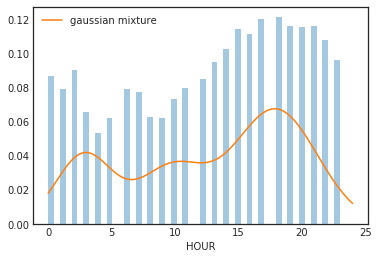

In [106]:
#mixture
sns.distplot(data, bins=50, kde=False, norm_hist=True)
g_both = [best_mix.pdf(e) for e in x]
plt.plot(x, g_both, label='gaussian mixture');
plt.legend();
plt.savefig("GMM_hour.png")